In [1]:
import numpy as np
import matplotlib.pyplot as plt


def qdot( state, params ):
    return state[:,2:4]


def pdot(state, params):
    positions = state[:, 0:2]
    
    n  = params[0]  #power of cos (defines length scale)
    V0 = params[1]  #strength of potential
    
    rij = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]
        
    #sin and cos are the basic building blocks of the interaction
    cos = np.cos( np.pi * rij )
    sin = np.sin( np.pi * rij )
    
    common = np.power( np.prod(cos, axis=2), 2*n-1 )
    
    force = np.zeros( np.shape(rij) )
    
    #components of force
    #I can't think of clever way to do this part, so I'll just explicitly compute both components in a pre-allocated space
    force[:,:,0] = V0 * np.pi * 2*n * common * cos[:,:,1] * sin[:,:,0]
    force[:,:,1] = V0 * np.pi * 2*n * common * cos[:,:,0] * sin[:,:,1]
    v = np.sum(force, axis=0)
    return v
   
    
def fix_state(state):
    N = np.size(state,0)
    for i in np.arange(0,N,1):
        for j in np.arange(0,2,1):
            if state[i,j] > 1:
                state[i,j] = state[i,j] - 1
            if state[i,j] < 0:
                state[i,j] = state[i,j] + 1
    return state


def symplectic_step( state, h, params ):
    # This is a symplectic integration preserving the area of phase space exactly
    # I want to try a rather agressive scheme from Yoshida's 1990 paper 
    # "Construction of higher order dymplectic integrators"
    # This will contain Solution A of the sixth order integrators (Table 1)
    
    # The idea is to define S^(m)(t) = ... S_2(w_2 t) S_2(w_1 t) S_2(w_0 t) S_2(w_1 t) S(w_2 t) ...
    # S_2 is the leapfrog scheme 
    
    
    w1 = -0.117767998417887E1
    w2 =  0.235573213359357E0
    w3 =  0.7845136104775E0
    
    w0 =  1 - 2*(w1+w2+w3) #from equation 5.18
    
    c = np.zeros(8)
    d = np.zeros(7)
    
    #always taking a mix of half-steps in q-space
    c[0] =  w3    /2
    c[1] = (w3+w2)/2
    c[2] = (w2+w1)/2
    c[3] = (w1+w0)/2
    c[4] = (w0+w1)/2
    c[5] = (w1+w2)/2
    c[6] = (w2+w3)/2
    c[7] =  w3    /2
    
    #full steps in p-space
    d[0] = w3
    d[1] = w2
    d[2] = w1
    d[3] = w0
    d[4] = w1
    d[5] = w2
    d[6] = w3
    
    for i in np.arange(0,7,1):
        state[:,0:2] = state[:,0:2] + c[i]*h*qdot(state, params)
        state[:,2:4] = state[:,2:4] + d[i]*h*pdot(state, params)
    #take final step in q
    state[:,0:2] = state[:,0:2] + c[7]*h*qdot(state, params)
    state = fix_state(state)
    
    return state



def coarse_velocity( state, boxes_per_side ):
    N = np.size(state,0) #number of particles
    
    v = np.zeros( [boxes_per_side, boxes_per_side, 2] ) #coarse velocity
    n = np.zeros( [boxes_per_side, boxes_per_side]) #particles in each box
    for p in np.arange(0,N,1):
        i = int(np.floor(state[p, 0]*boxes_per_side))
        j = int(np.floor(state[p, 1]*boxes_per_side))
        
        #print([i,j])
        v[i,j,0] = v[i,j,0] + state[p,2]
        v[i,j,1] = v[i,j,1] + state[p,3]
        n[i,j] = n[i,j] + 1
        
    #If n is zero, set it to 1
    n[ n==0 ] = 1
    
    #take the mean in each box
    v[:,:,0] = v[:,:,0]/n
    v[:,:,1] = v[:,:,1]/n
    return v



def correlation(x,y):
    x = np.reshape(x, [np.size(x)])
    y = np.reshape(y, [np.size(y)])
    return np.dot(x,y)/np.sqrt( np.dot(x,x)*np.dot(y,y) )

    
    

def kinetic_and_potential_energy(state):
    #kinetic energy T
    T = np.sum( np.square( state[:,2:4] ) )/2
    
    N = np.size(state, 0) #number of particles
    
    positions = state[:, 0:2]
    L = params[0]  #length scale of potential
    F = params[1]  #Strength of the force
    rij = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]
    
    #shift as needed
    mask = np.abs(rij[:,:,0])>0.5
    rij[mask,0] = rij[mask,0] - np.sign(rij[mask,0])
    mask = np.abs(rij[:,:,1])>0.5
    rij[mask,1] = rij[mask,1] - np.sign(rij[mask,1])
    
    dsq = np.linalg.norm(rij, axis=2)**2
    pot = F*L*np.exp(-dsq/(L**2))
    
    #Potential energy. Divide by two because we double count
    V = np.sum(pot) # sum individual contributions
    V = V - N*F*L   # subtract the self-interaction
    V = V/2         # divide by 2 because we double counted
    
    return T, V

1.9539925233402755e-13


In [3]:
#%%prun
! pip3 install scipy
import initial_condition_generator

N = 1024 #number of particles

L_ave = 1/np.sqrt(N)

I1 =  1  #v^2/L_0/F
I2 =  9  #L/L_0

v_scale    = 1
F          = v_scale**2/I1/L_ave
L          = I2*L_ave
time_scale = np.sqrt(L/F)



nn = 64; #V ~ cos^2n
V0 =  3; #strength of potential
params = np.array( [nn, V0] )

every = 1   #take this many timesteps before saving to array
M     = 512 #saved timesteps

T = 10*time_scale
h = T/M/every

traj = np.zeros( [N,4,M] )
state= np.zeros( [N,4]   )

#energy values during time integration
kinetic   = np.zeros( [M,1] )
potential = np.zeros( [M,1] ) 

#random initial data
state[:,0:2] = np.random.rand(N,2)

print("relaxing potential...")
for i in np.arange(1,128,1):
    #print(i)
    for j in np.arange(0,every,1):
        state = symplectic_step( state, h, params)
    state[:,2:4] = 0

relaxed_position = np.copy( state[:, 0:2] ) 
    
    
    
num_trials = 16
for trial in np.arange(0,num_trials,1):
    state[:,0:2] = np.copy( relaxed_position )
    state[:,2:4] = initial_condition_generator.generate_from_state( state[:,0:2] )

    #state[:,2]   = 2*np.sin( 3*2*np.pi*state[:,1] )
    #state[:,3]   =   np.sin(   2*np.pi*state[:,0] )

    traj[:,:,0]  = state
 
    kinetic[0], potential[0] = kinetic_and_potential_energy(state)
    for i in np.arange(1,M,1):
        #print(i)
        for j in np.arange(0,every,1):
            state = symplectic_step( state, h, params)
        
        traj[:,:,i] = state
    
        continue
    file = f"sim_%d.npy" % trial

    pos = traj[:,0:2,:]
    vels= traj[:,2:4,:]
    deltat= T/M
    dims = np.array([1, M])

    ndata_path = 'sims3/'
    with open(ndata_path + file, 'wb') as out_file:
                np.save(out_file, pos)
                np.save(out_file, vels)
                np.save(out_file, deltat)
                np.save(out_file, dims)

     |████████████████████████████████| 33.8 MB 32.2 MB/s eta 0:00:01
relaxing potential...
-0.715016309599821*sin(2*pi*x + 0.147362144285311*pi)**2*sin(2*pi*x + 0.896845306186207*pi)*cos(4*pi*y + 0.145156071224082*pi) - 0.513555276588476*sin(2*pi*x + 0.590808348938732*pi)*cos(2*pi*y + 0.0127106246745812*pi)**2*cos(2*pi*y + 1.45814147776931*pi)*cos(4*pi*y + 0.548849381187813*pi) + 1.28868793281917*sin(2*pi*x + 1.03344930796067*pi) - 0.62002142743729*sin(4*pi*x + 0.686621380652994*pi)*cos(4*pi*y + 1.89105230353674*pi)**2 - 0.722965775702298*cos(2*pi*y + 0.260553512752999*pi) + 1.2176312040998*cos(4*pi*y + 0.96557131154157*pi)
-0.59055667139967*sin(2*pi*x + 0.611383570686385*pi)**2*sin(2*pi*x + 1.42930076326903*pi)**2 - 0.760971806083709*sin(2*pi*x + 1.34999172999152*pi)*cos(4*pi*y + 0.0786751554421519*pi)**2 + 0.930283142283208*sin(2*pi*x + 1.52933473465745*pi)**2*sin(2*pi*x + 1.59501651812801*pi)**2*cos(2*pi*y + 0.658030211073726*pi)*cos(2*pi*y + 0.841446122400308*pi)*cos(4*pi*y + 1.48

In [11]:

ndata_path = 'sims3/'
with open(ndata_path + file, 'wb') as out_file:
                np.save(out_file, pos)
                np.save(out_file, vels)
                np.save(out_file, deltat)
                np.save(out_file, dims)

In [ ]:
#%%prun

#The dimensionless
N       = 1024 #number of particles
v_scale = 1    #max velocity for initial data
L_ave   = 1/np.sqrt(N) #expected separation of particles for a uniform lattice

num1    = 8  #values of L_impact/L_ave
num2    = 8  #values of L/L_ave

#limits of search for invariant_1 = L_impact/L_ave
I1_min   = 0.5
I1_max   = 2

#limits of search for invariant_2 = L/L_ave
I2_min  = 0.25
I2_max  = 1

M       = 32 #number of timesteps
every   = 1
h       = 0.2/M #timestep

boxes_per_side = 6 #boxes for velocity correlation

corr = np.zeros( [num1, num2, M] )

I1s = np.linspace( I1_min, I1_max, num1 )
I2s = np.linspace( I2_min, I2_max, num2 )


state0 = np.zeros([N,4])
state0[:,0:2] = np.random.rand(N,2)
state0[:,2] = v_scale * np.sin( 2*np.pi*state0[:,1] )
state0[:,3] = v_scale * np.sin( 2*np.pi*state0[:,0] )


for idx1 in np.arange(0, num1, 1):
    for idx2 in np.arange(0, num2, 1):
        #corr[idx1,idx2,:] = idx2
        #continue
        
        print([idx1, idx2])
        
        A = v_scale**2/I1s[idx1]/L_ave
        L = I2s[idx2]*L_ave
        
        num_boxes = int(10) #boxes for computing particle interactions
        params = np.array( [L, A, num_boxes] )
        state = np.copy(state0)
        v0 = coarse_velocity( state, boxes_per_side )
        
        for i in np.arange(0,M,1):
            v = coarse_velocity( state, boxes_per_side )
            corr[idx1, idx2, i] = correlation(v,v0)
            for j in np.arange(0,every,1):
                state = symplectic_step( state, h/every, params) 

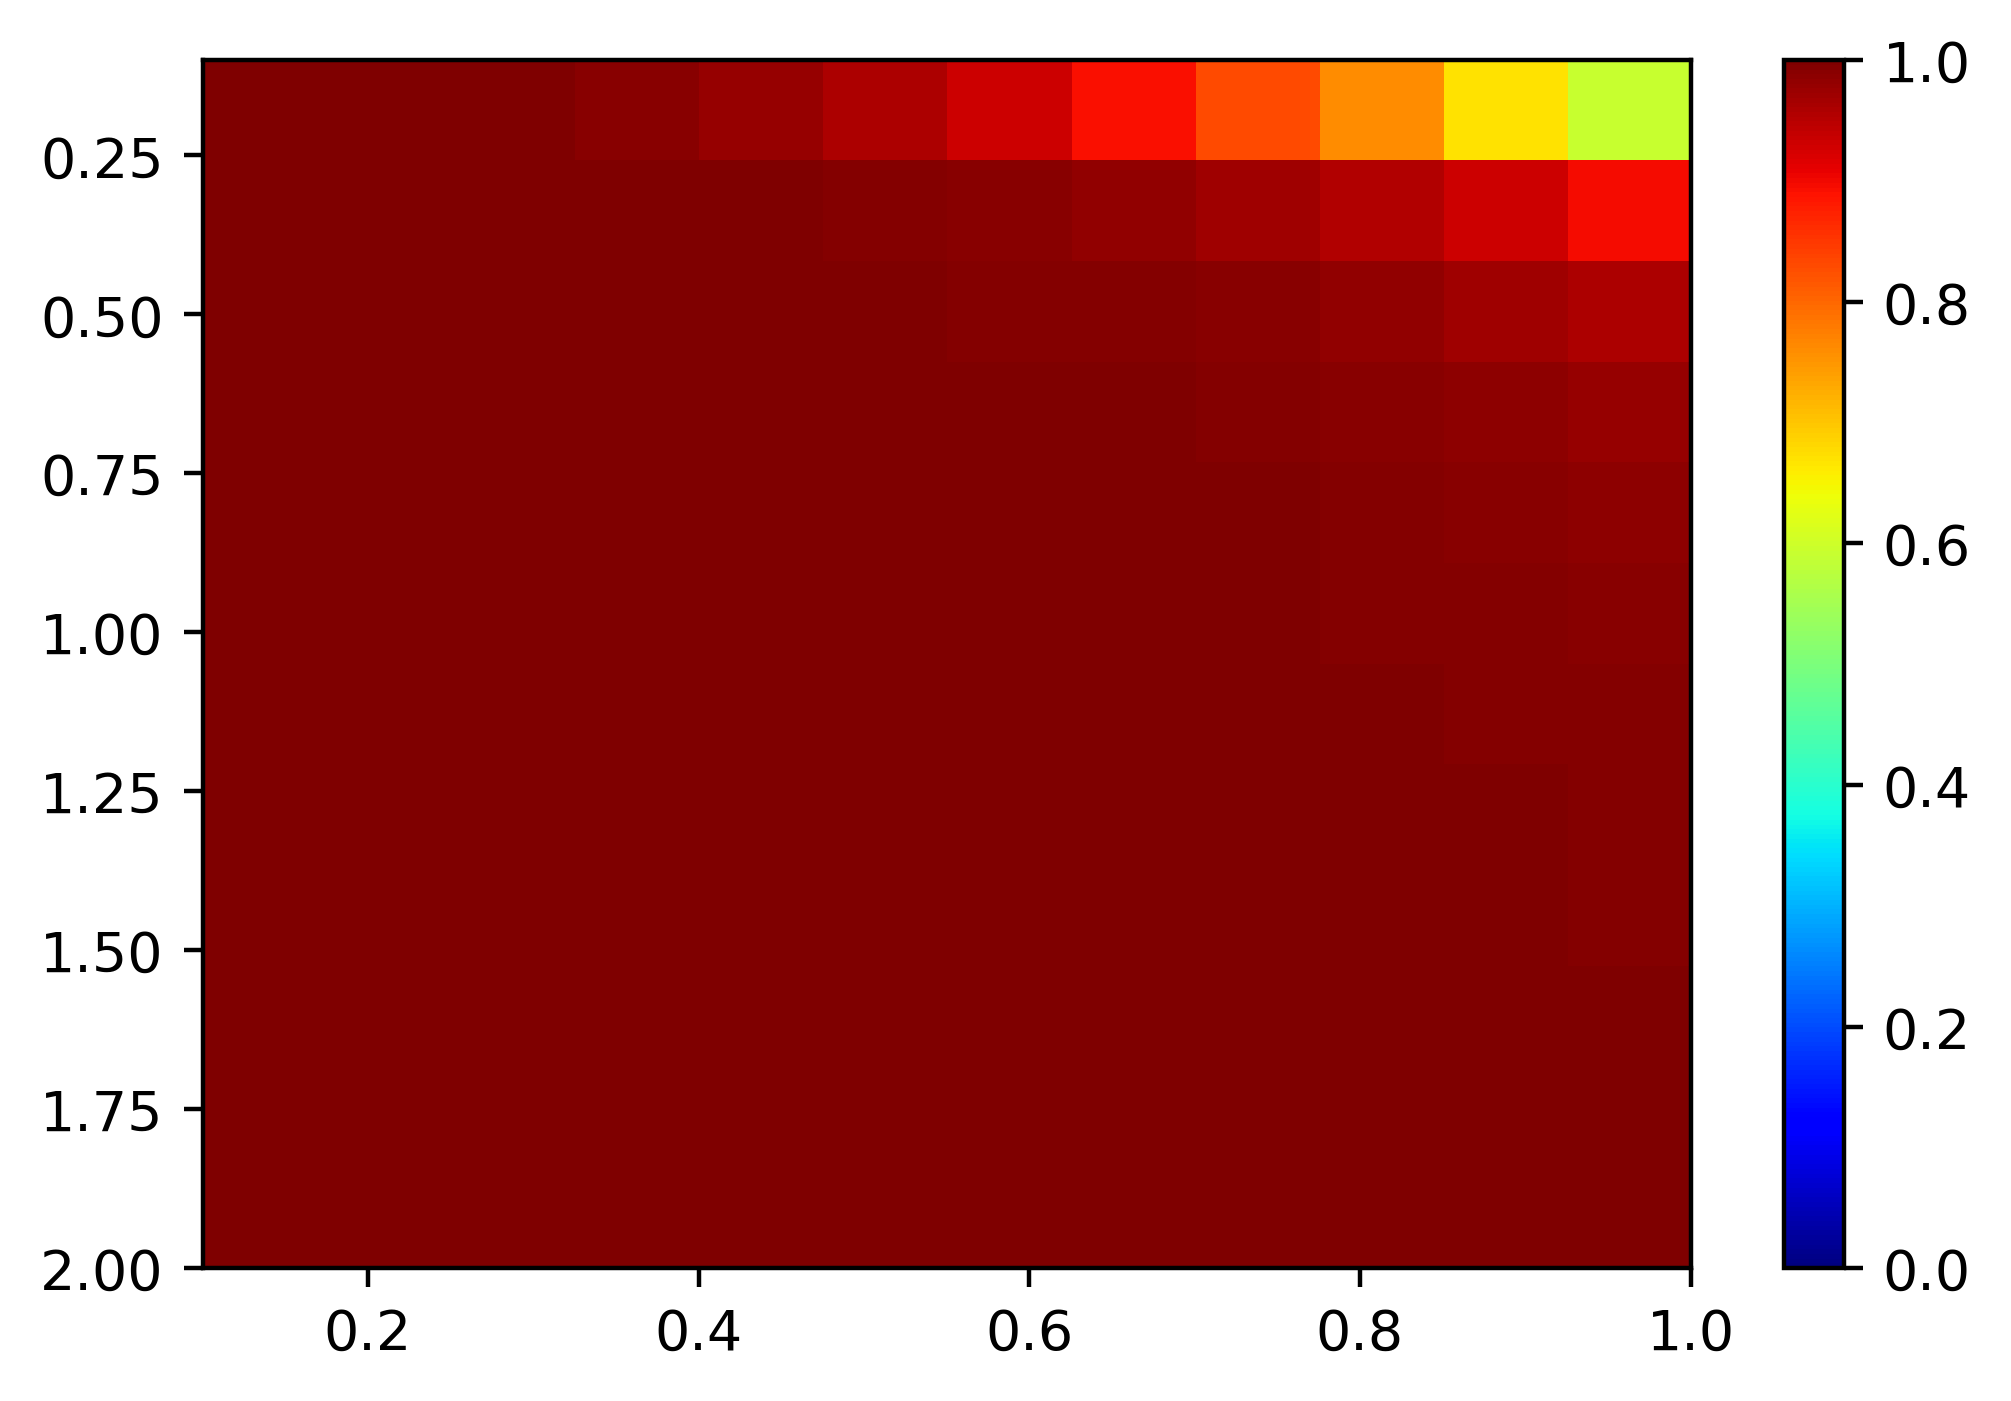

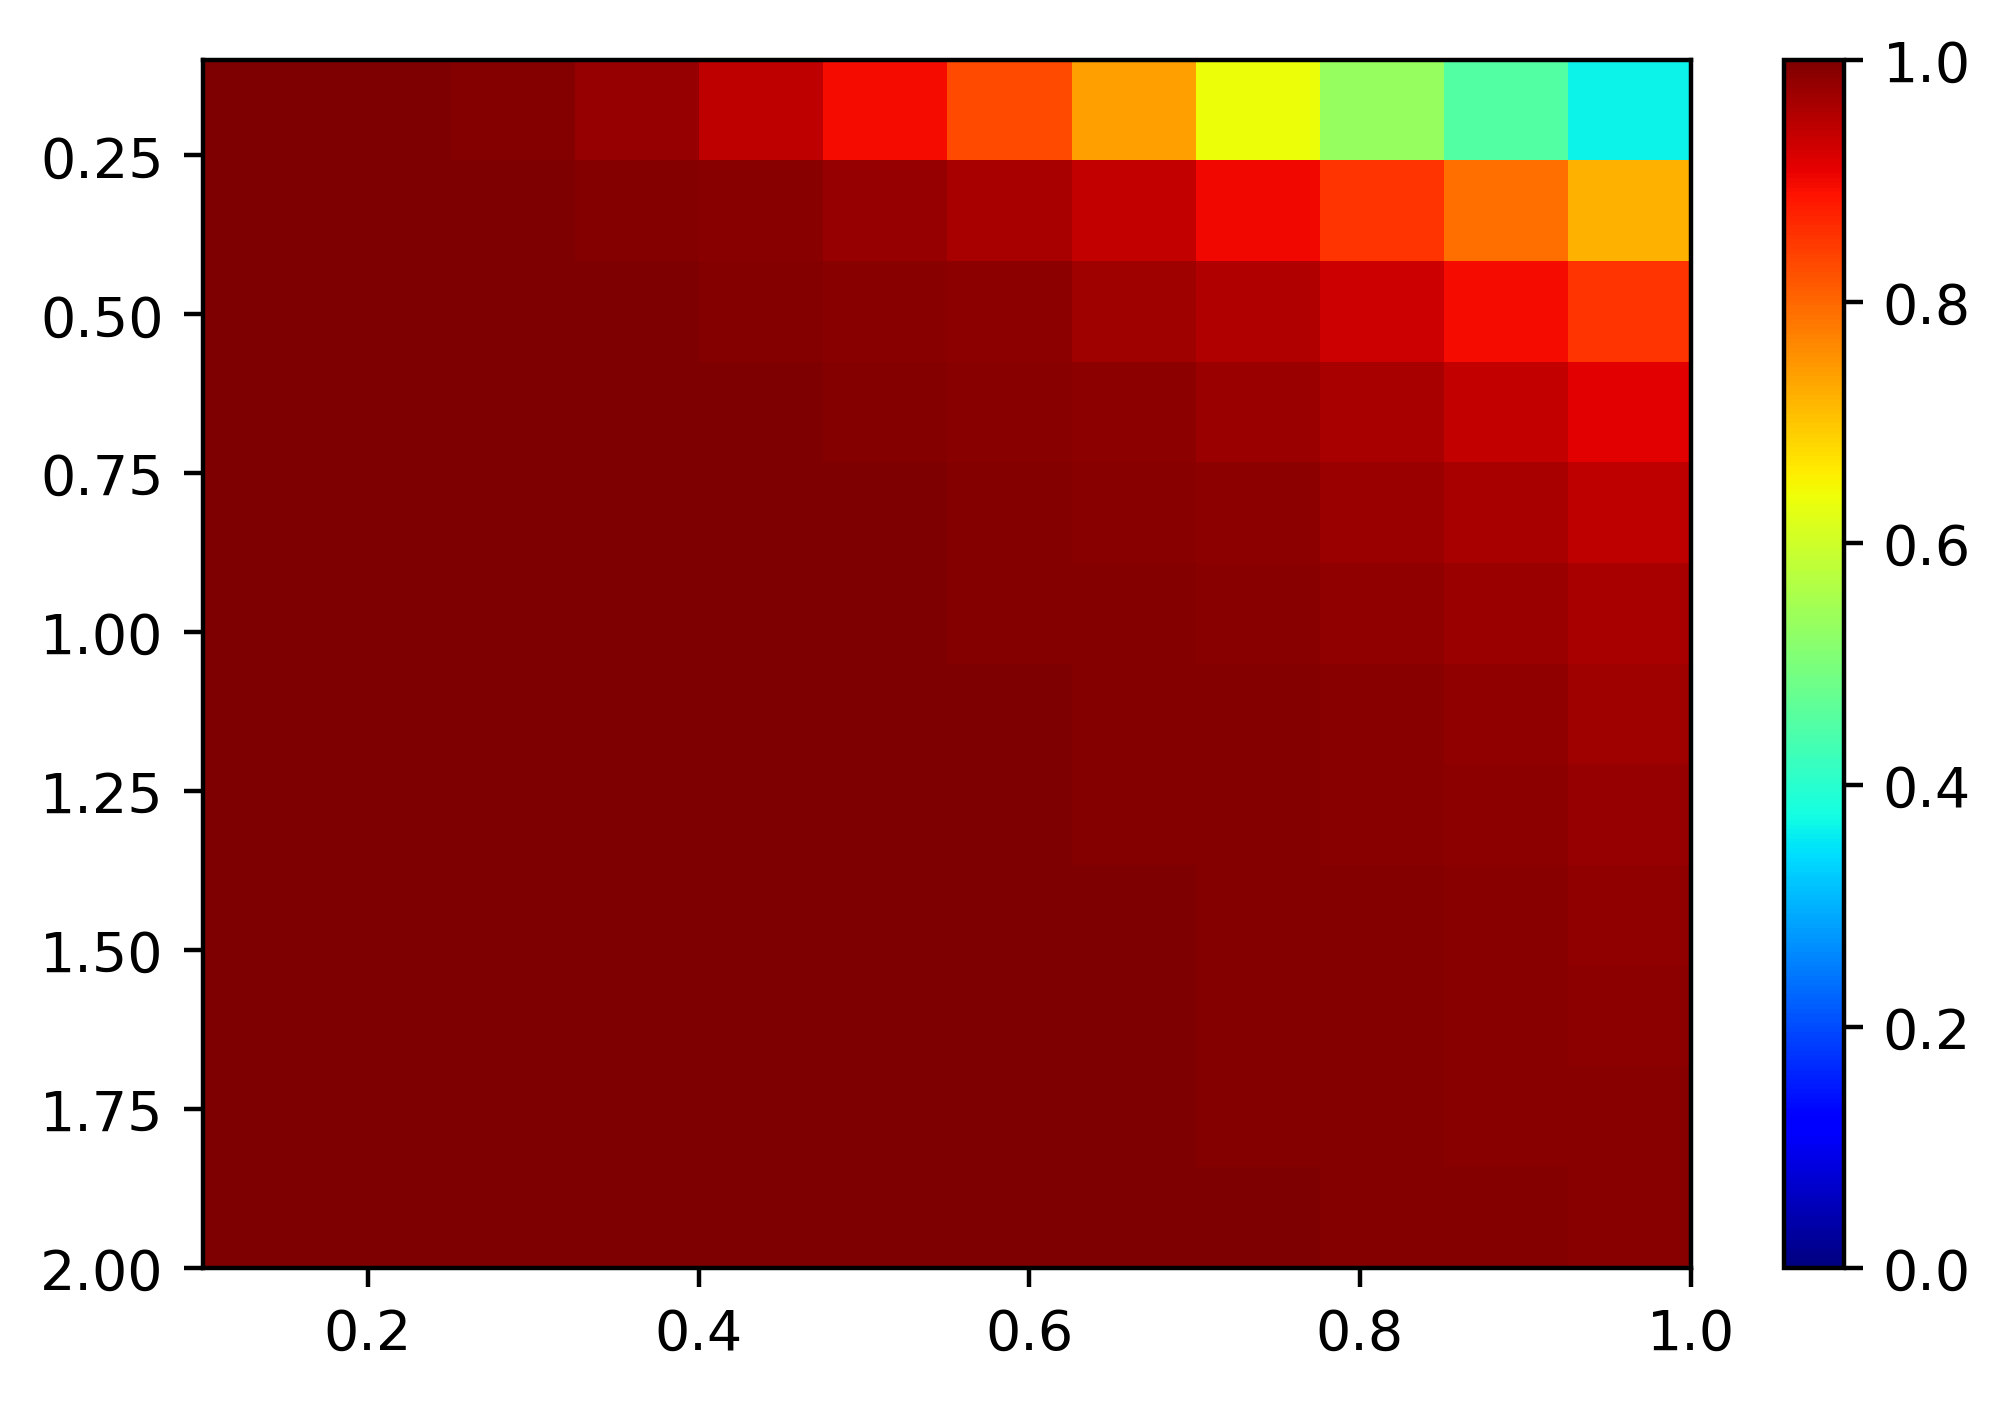

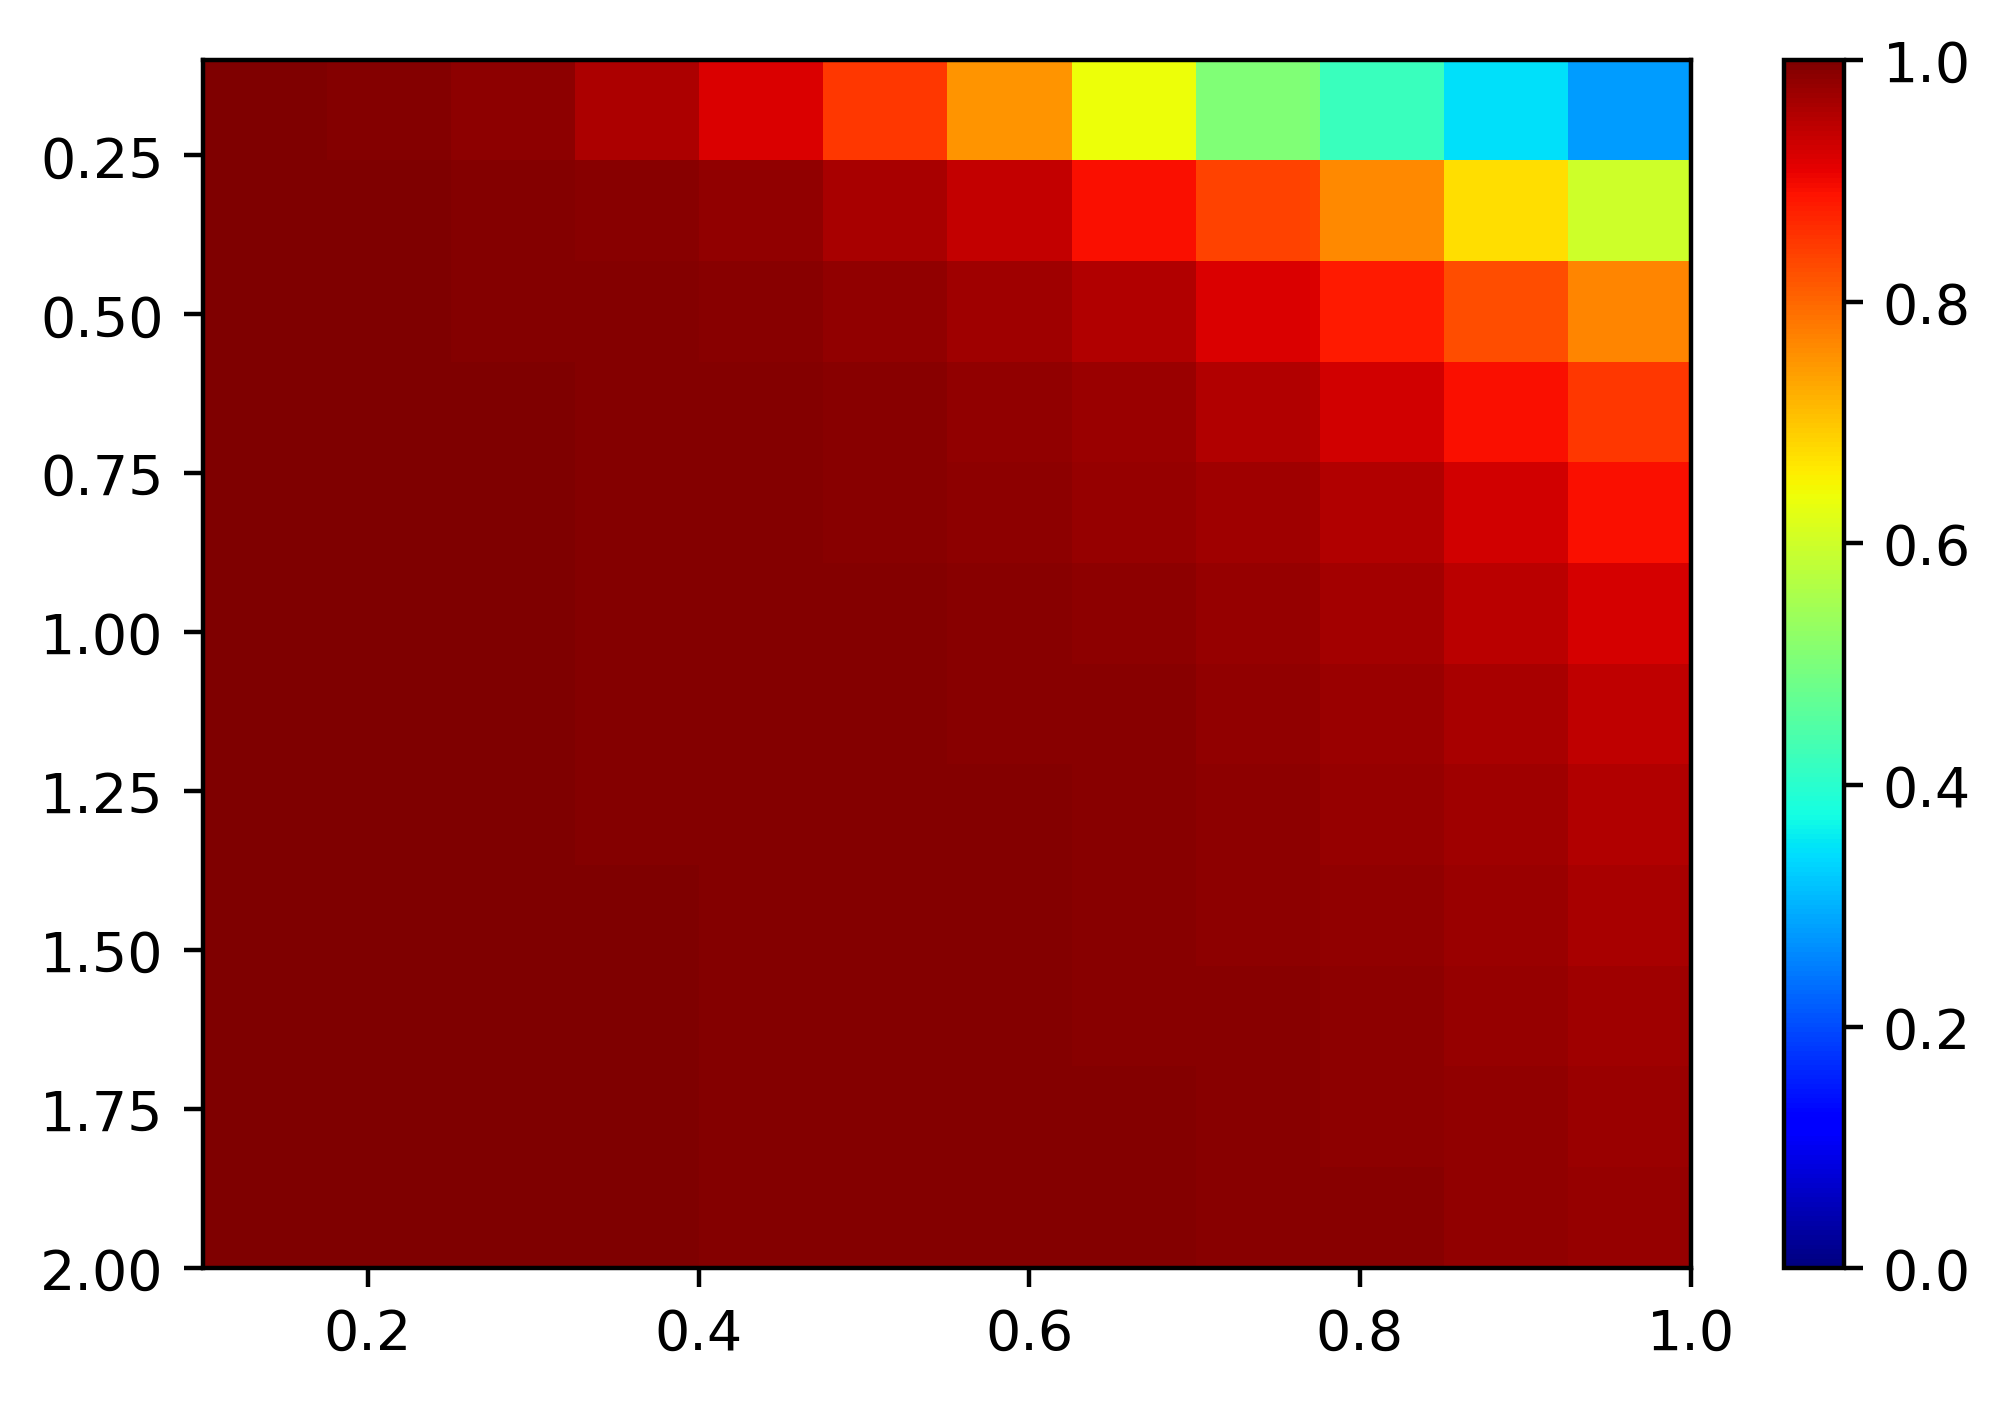

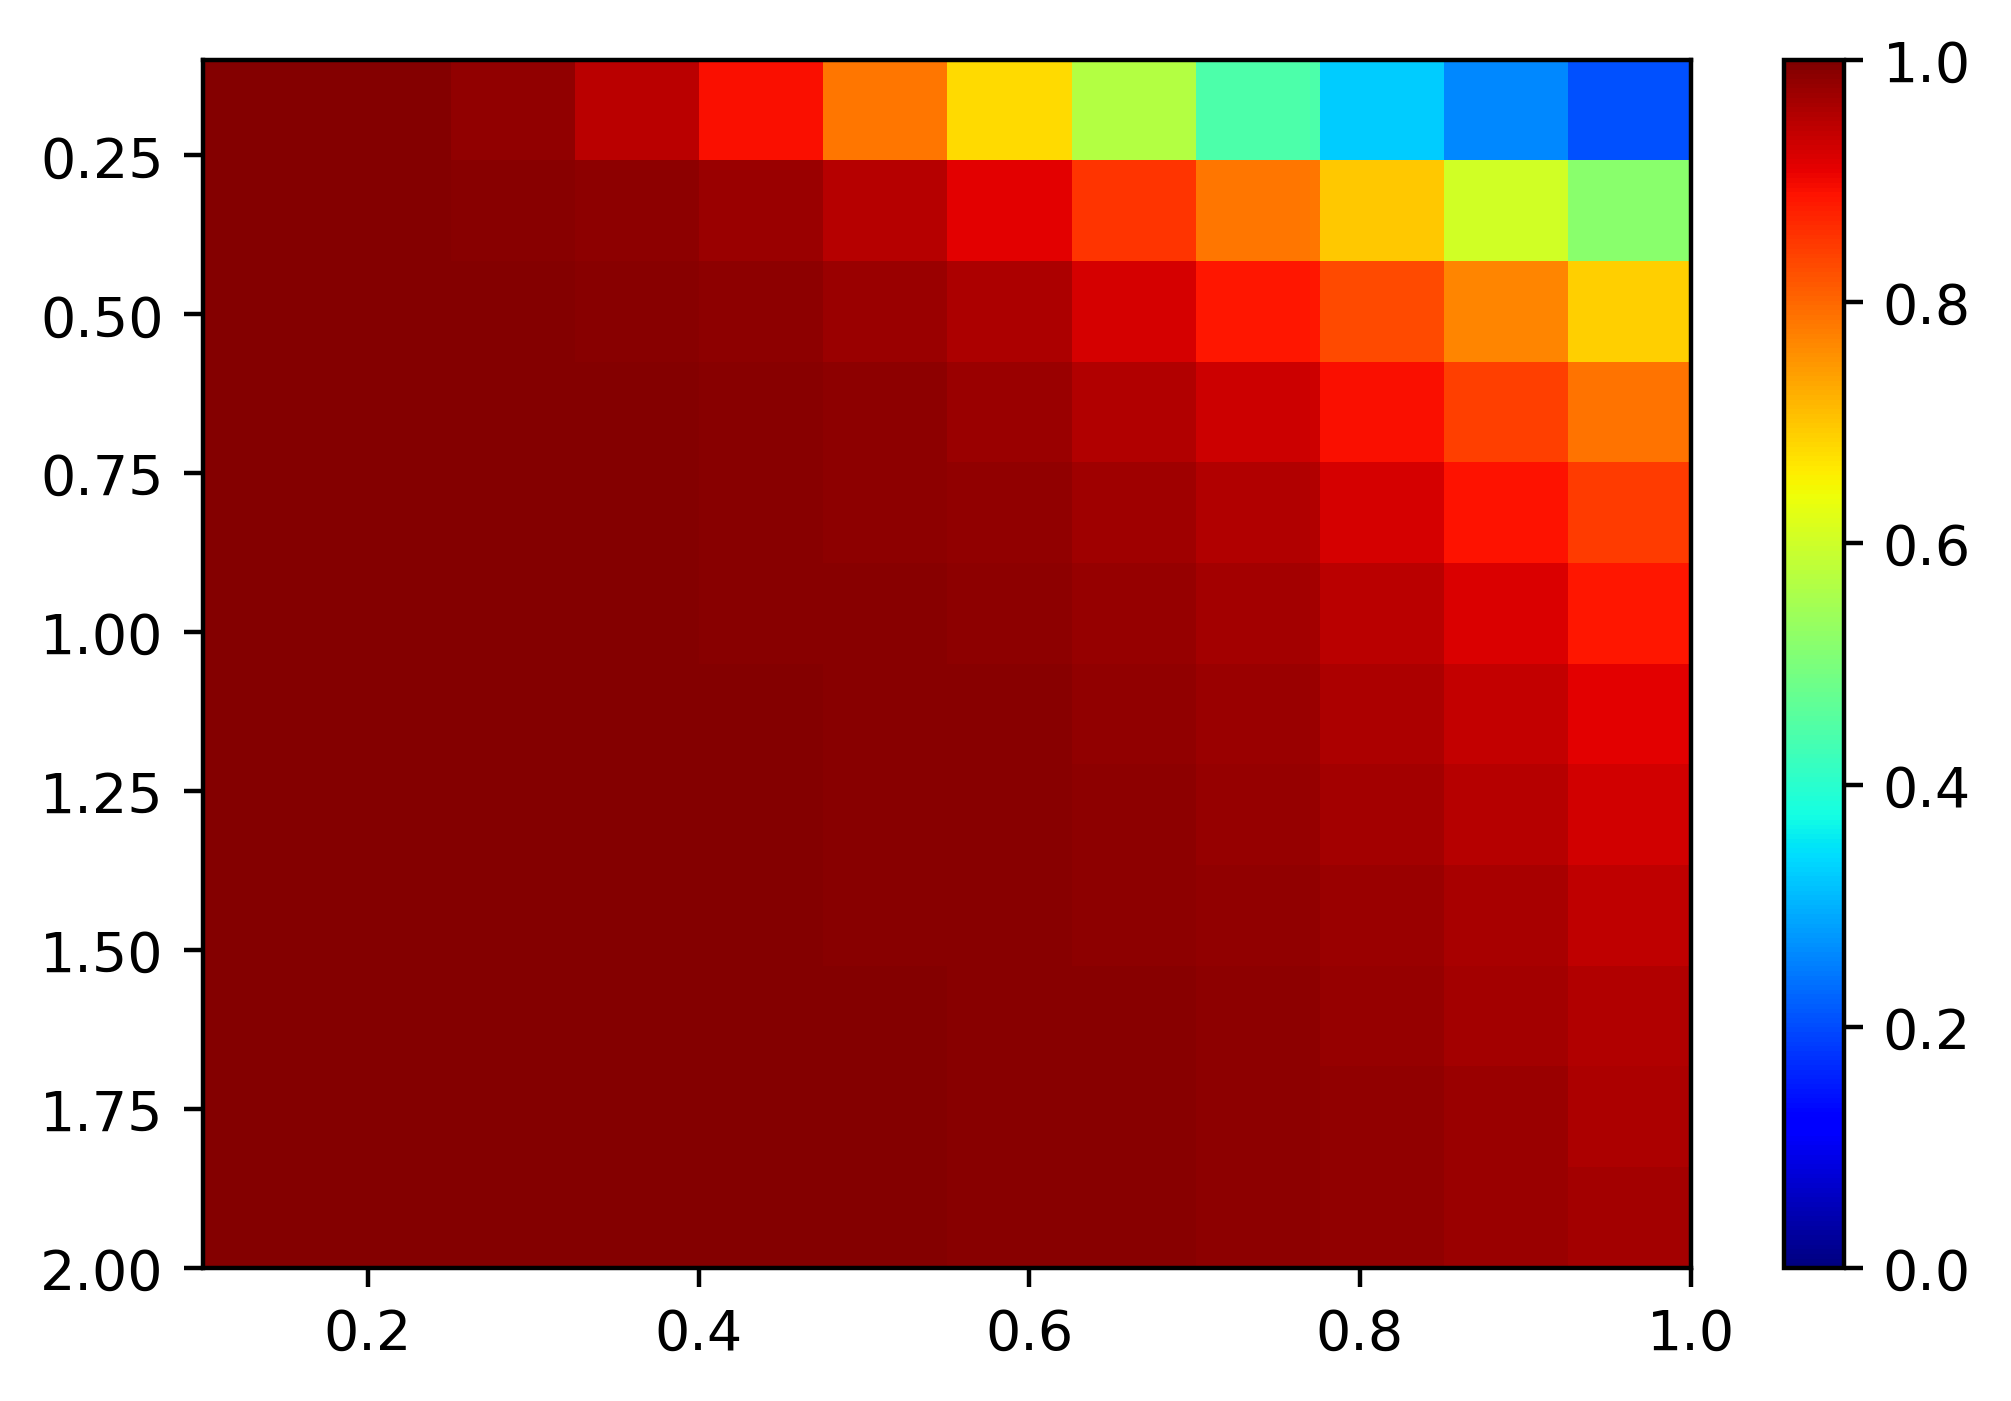

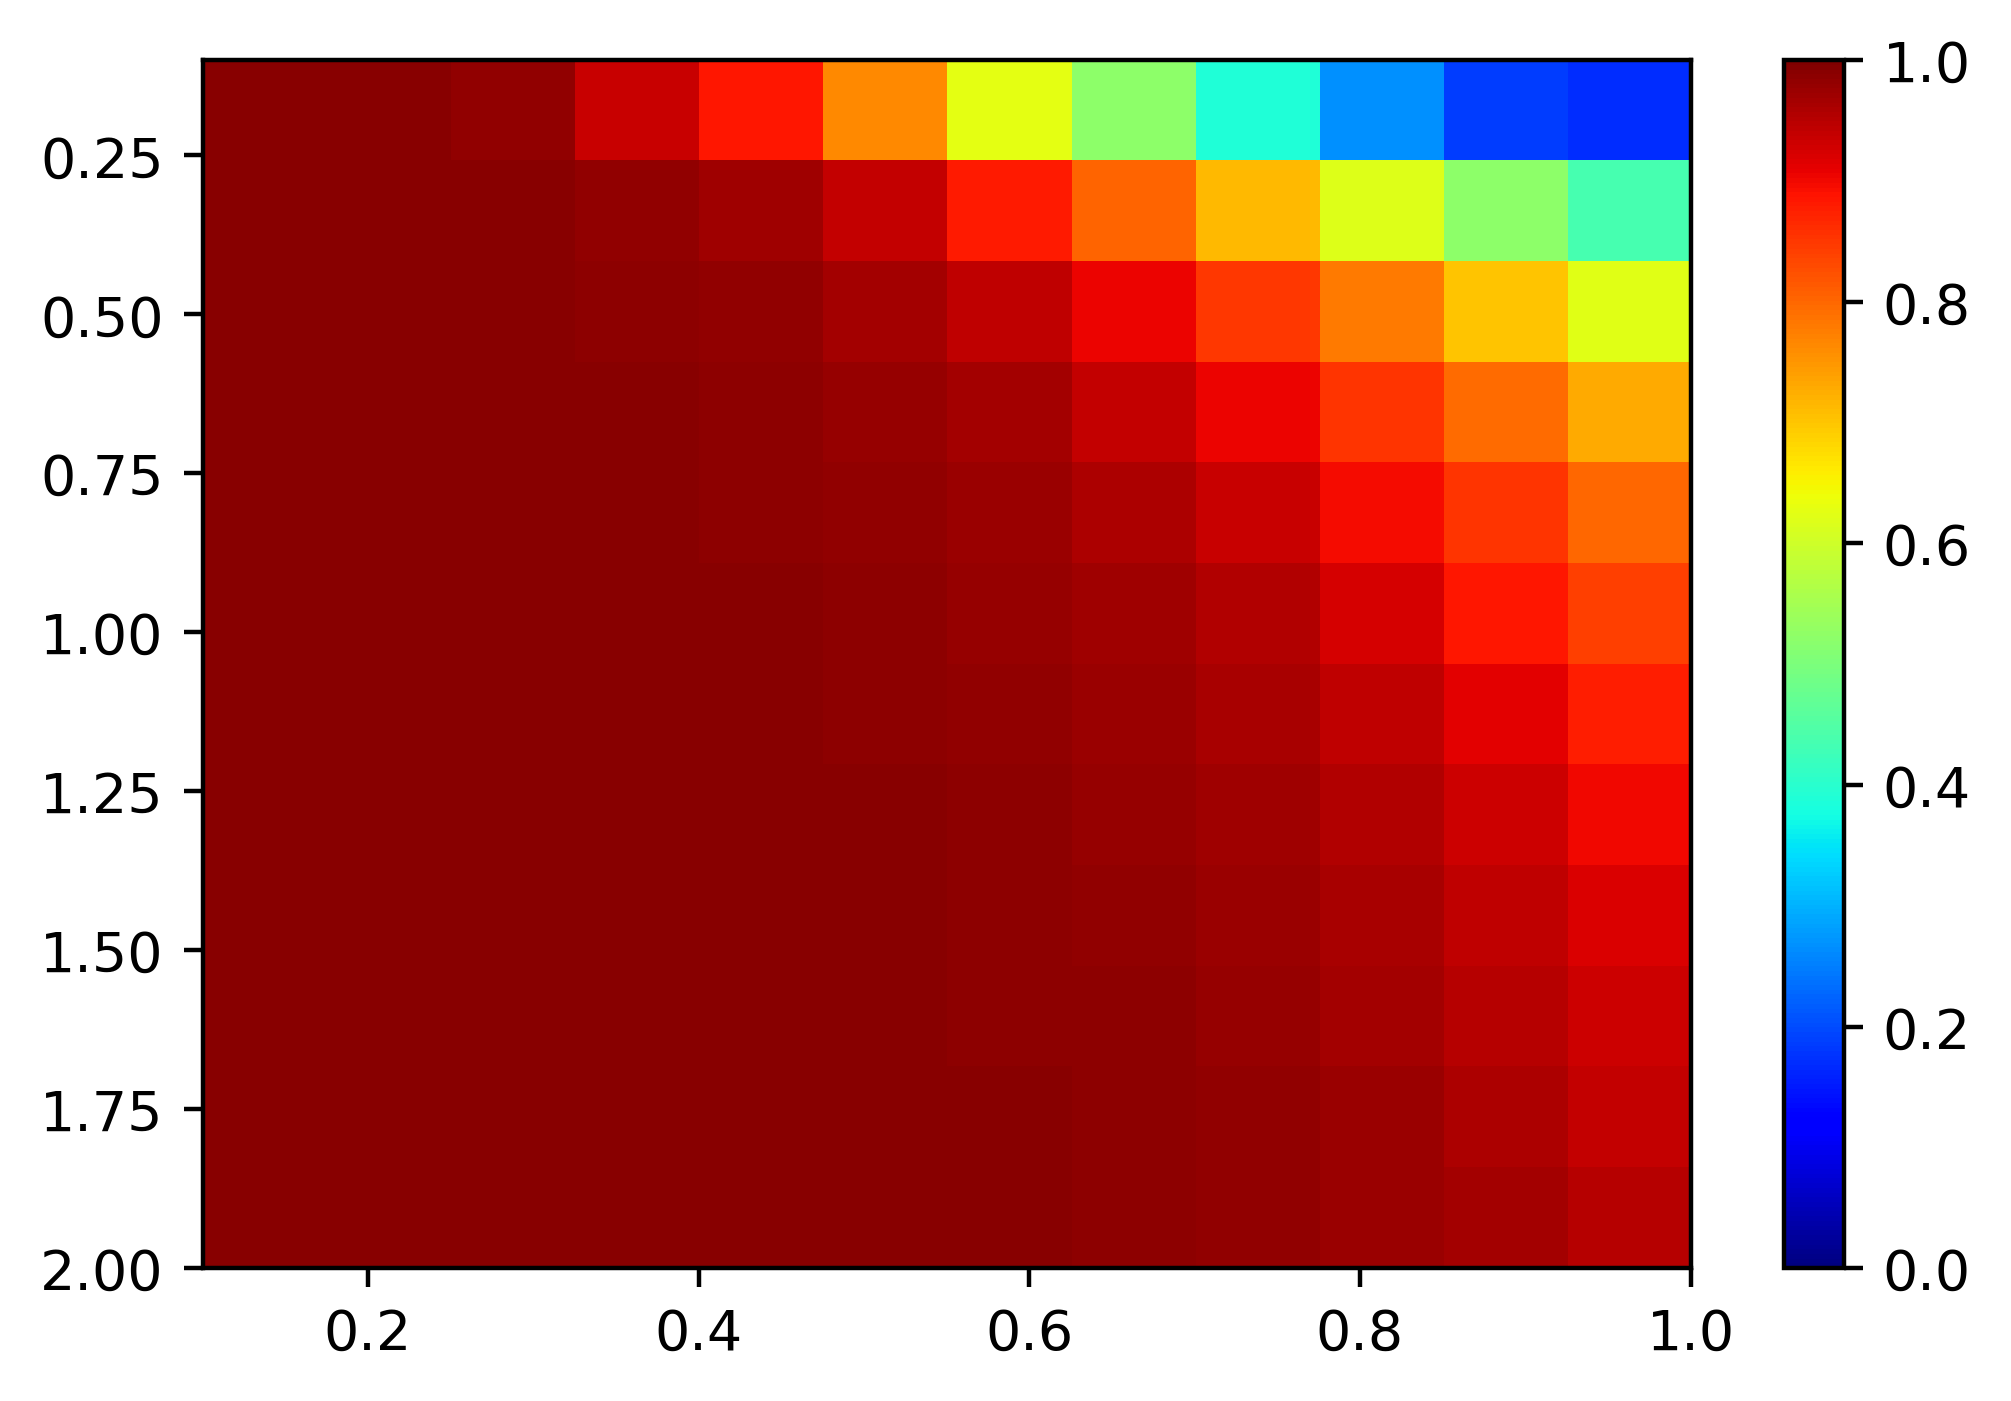

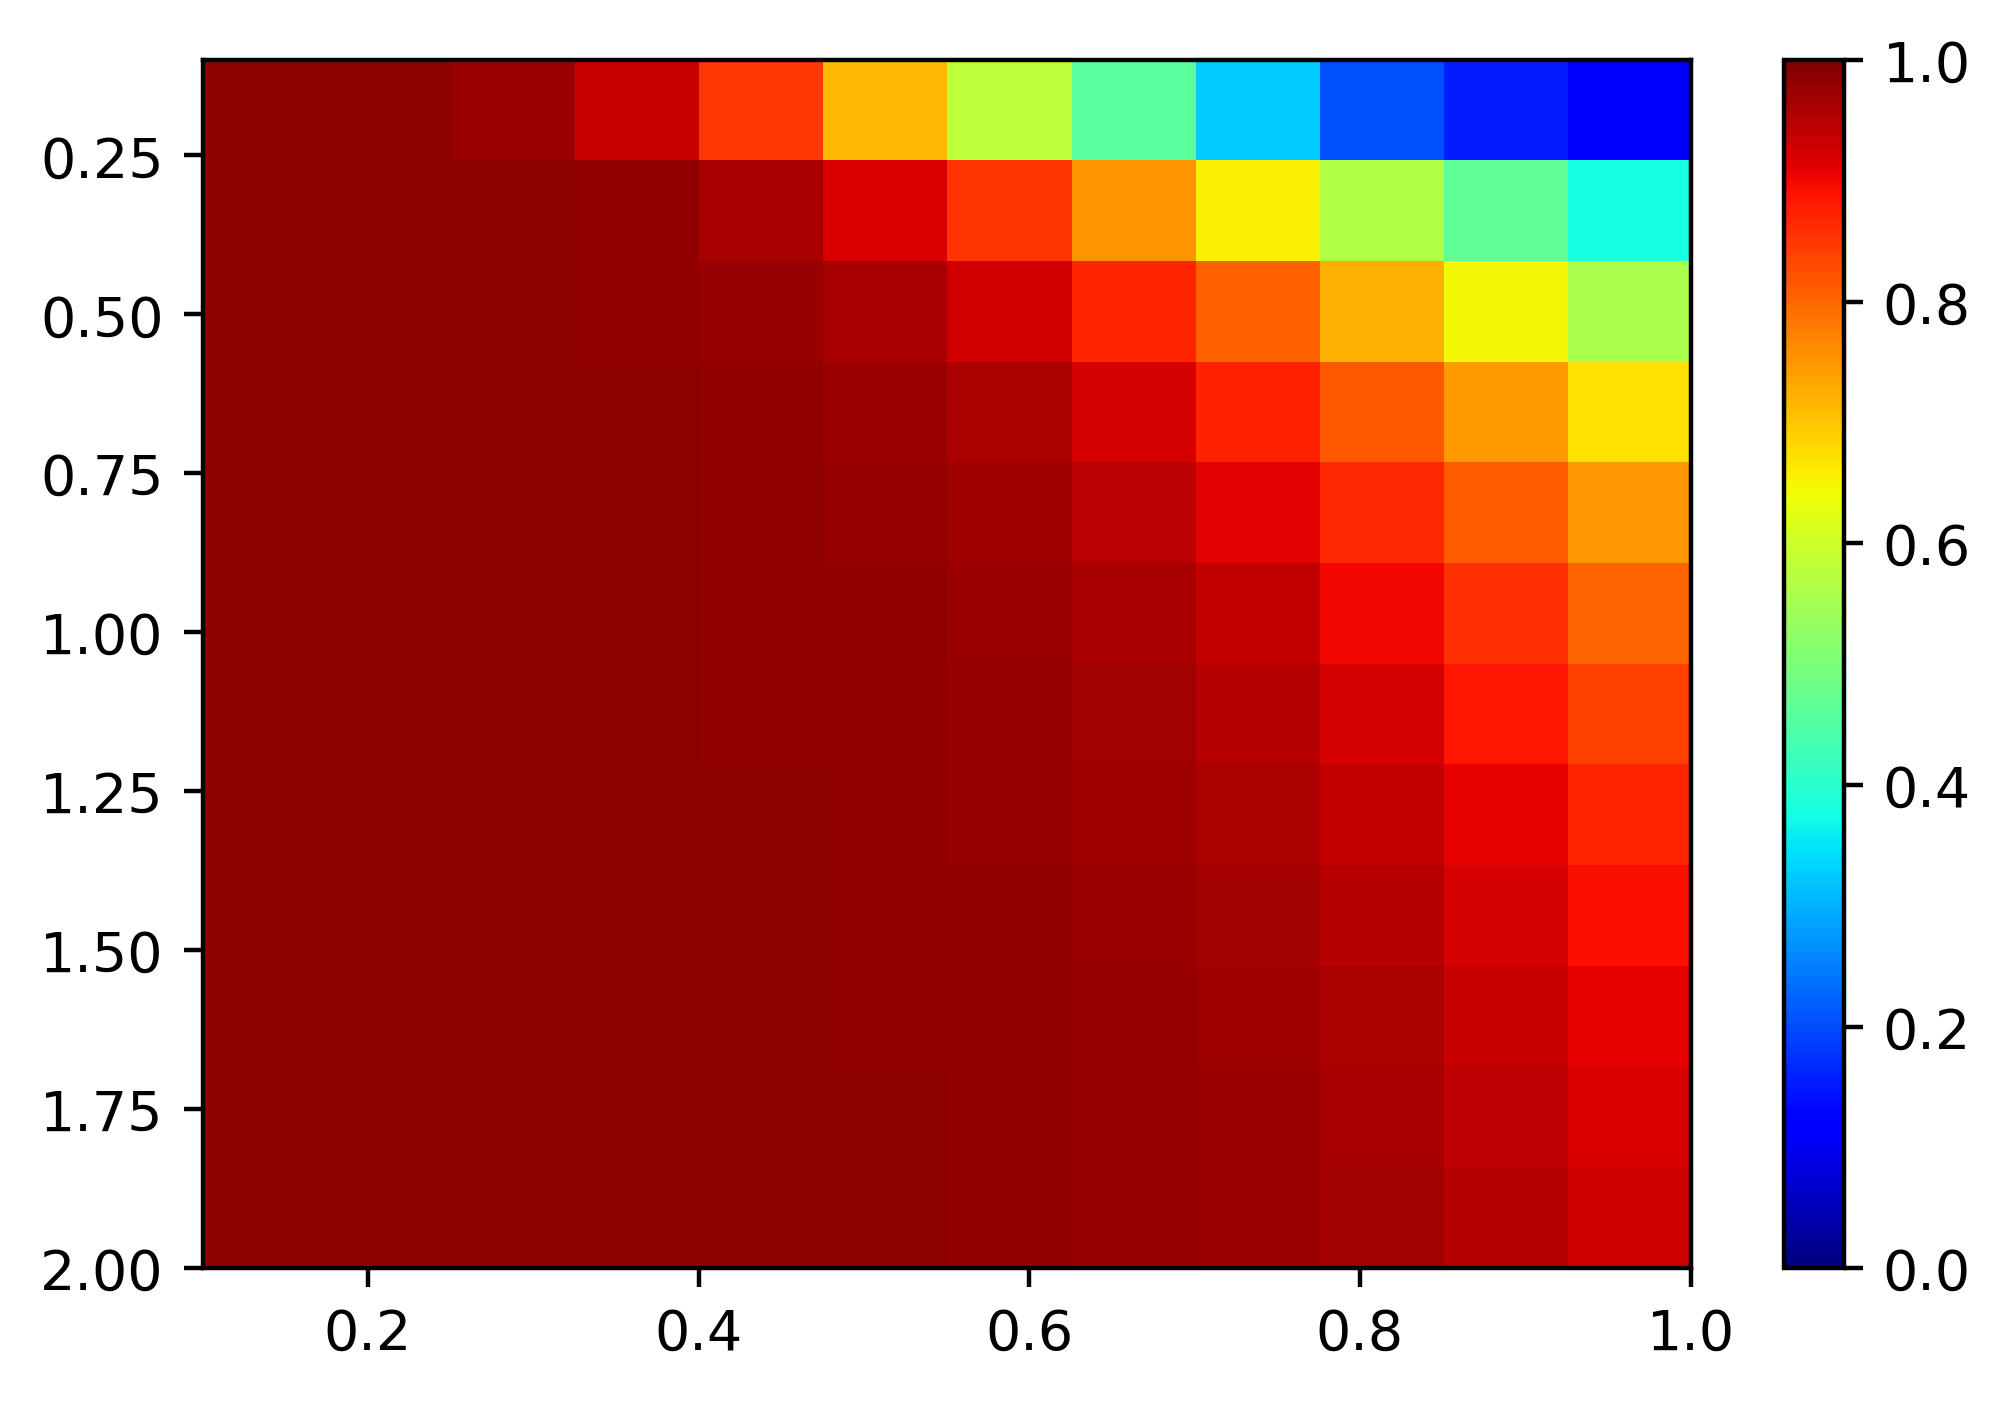

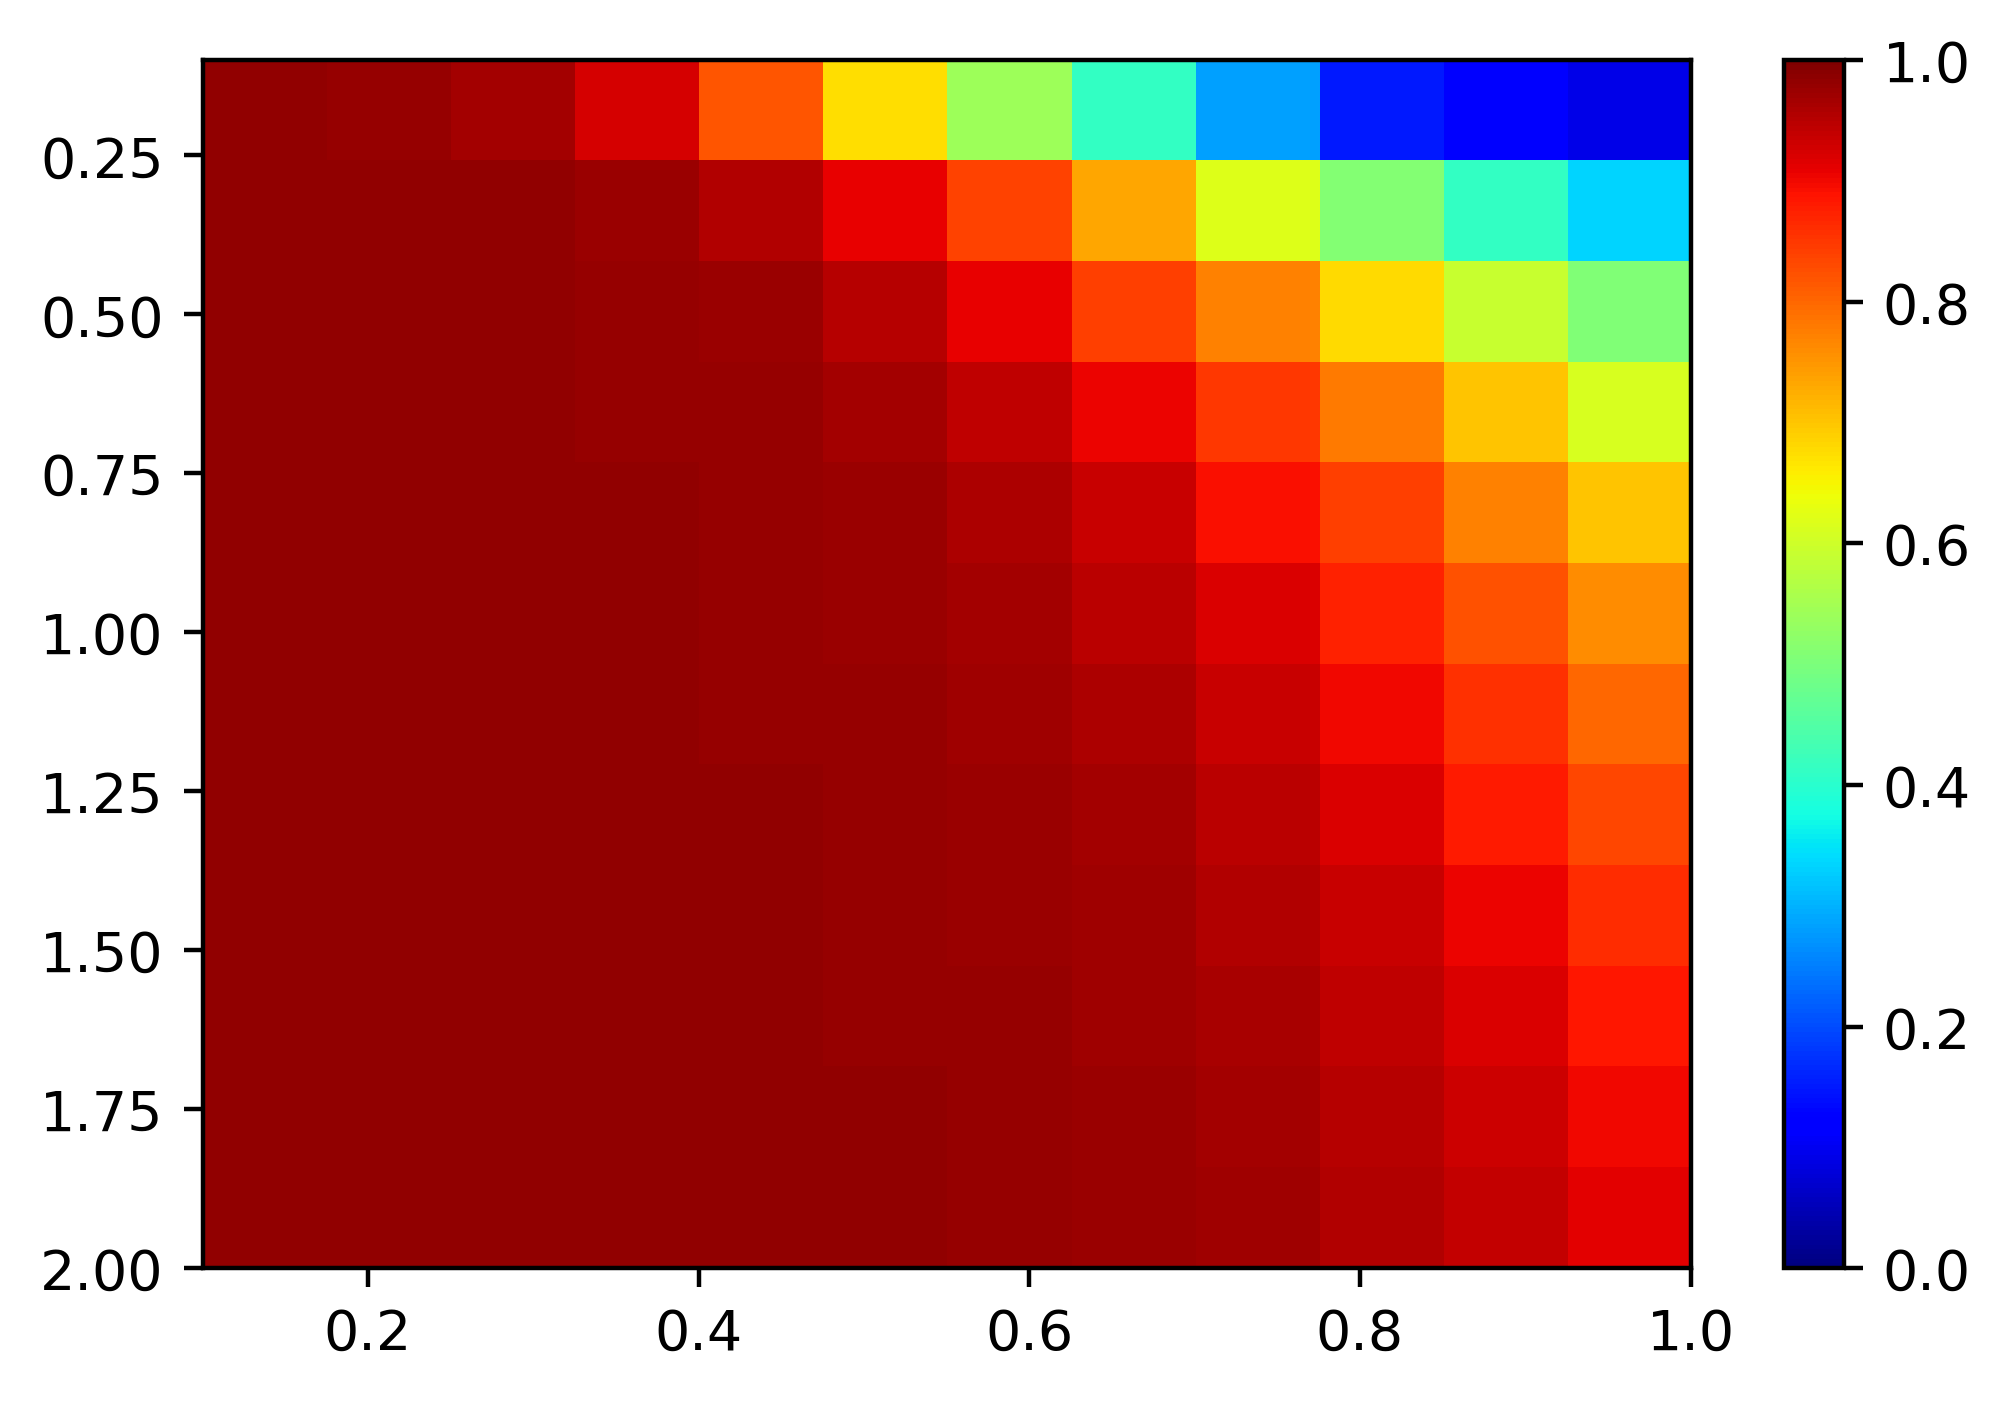

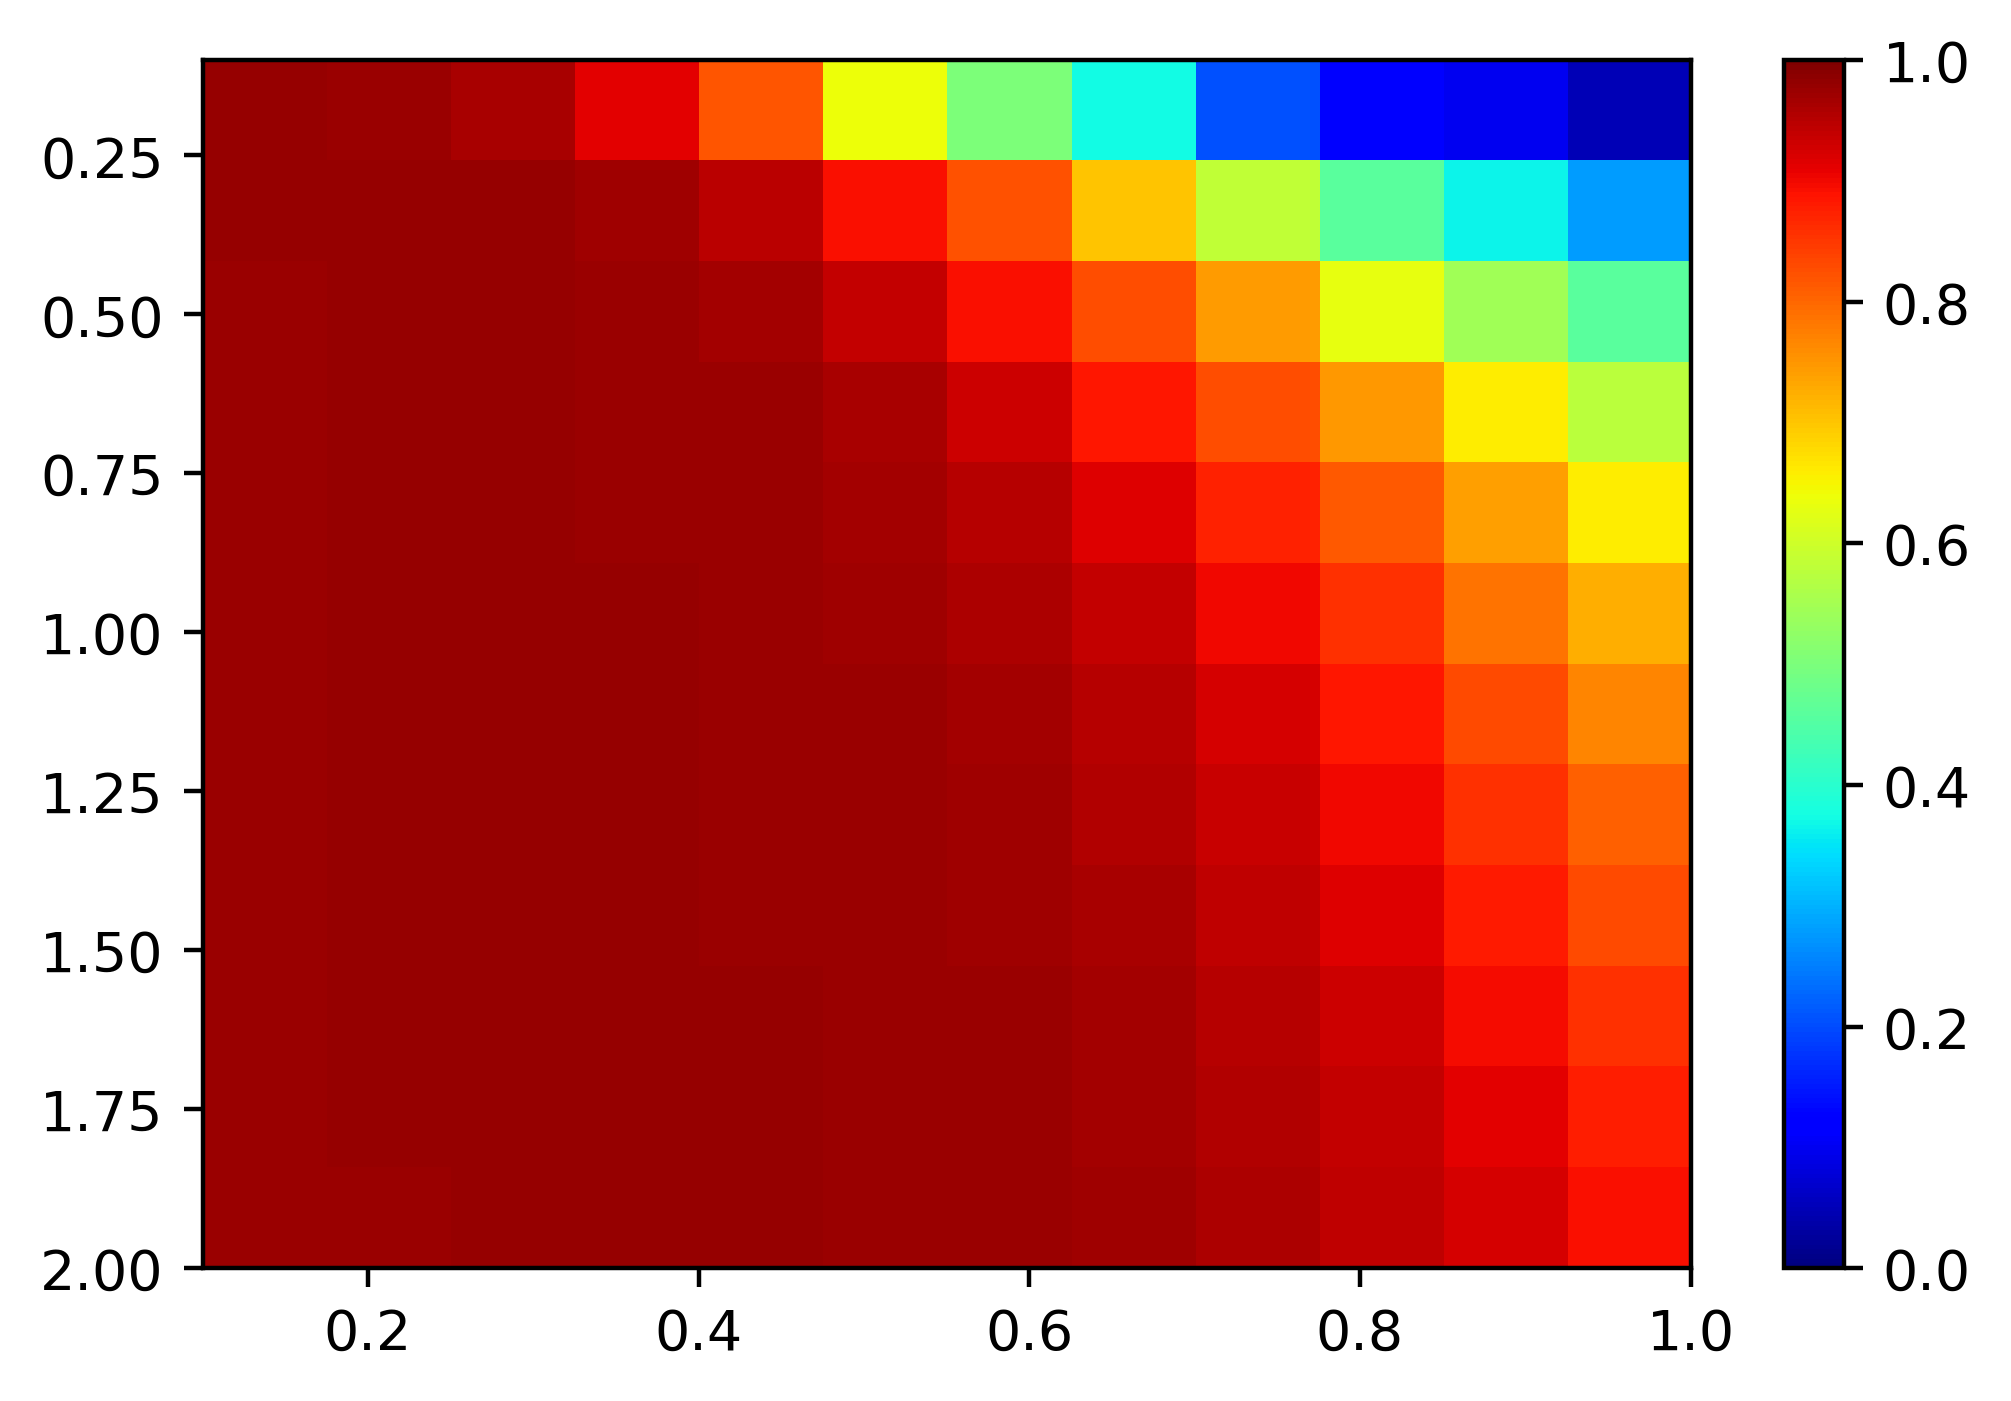

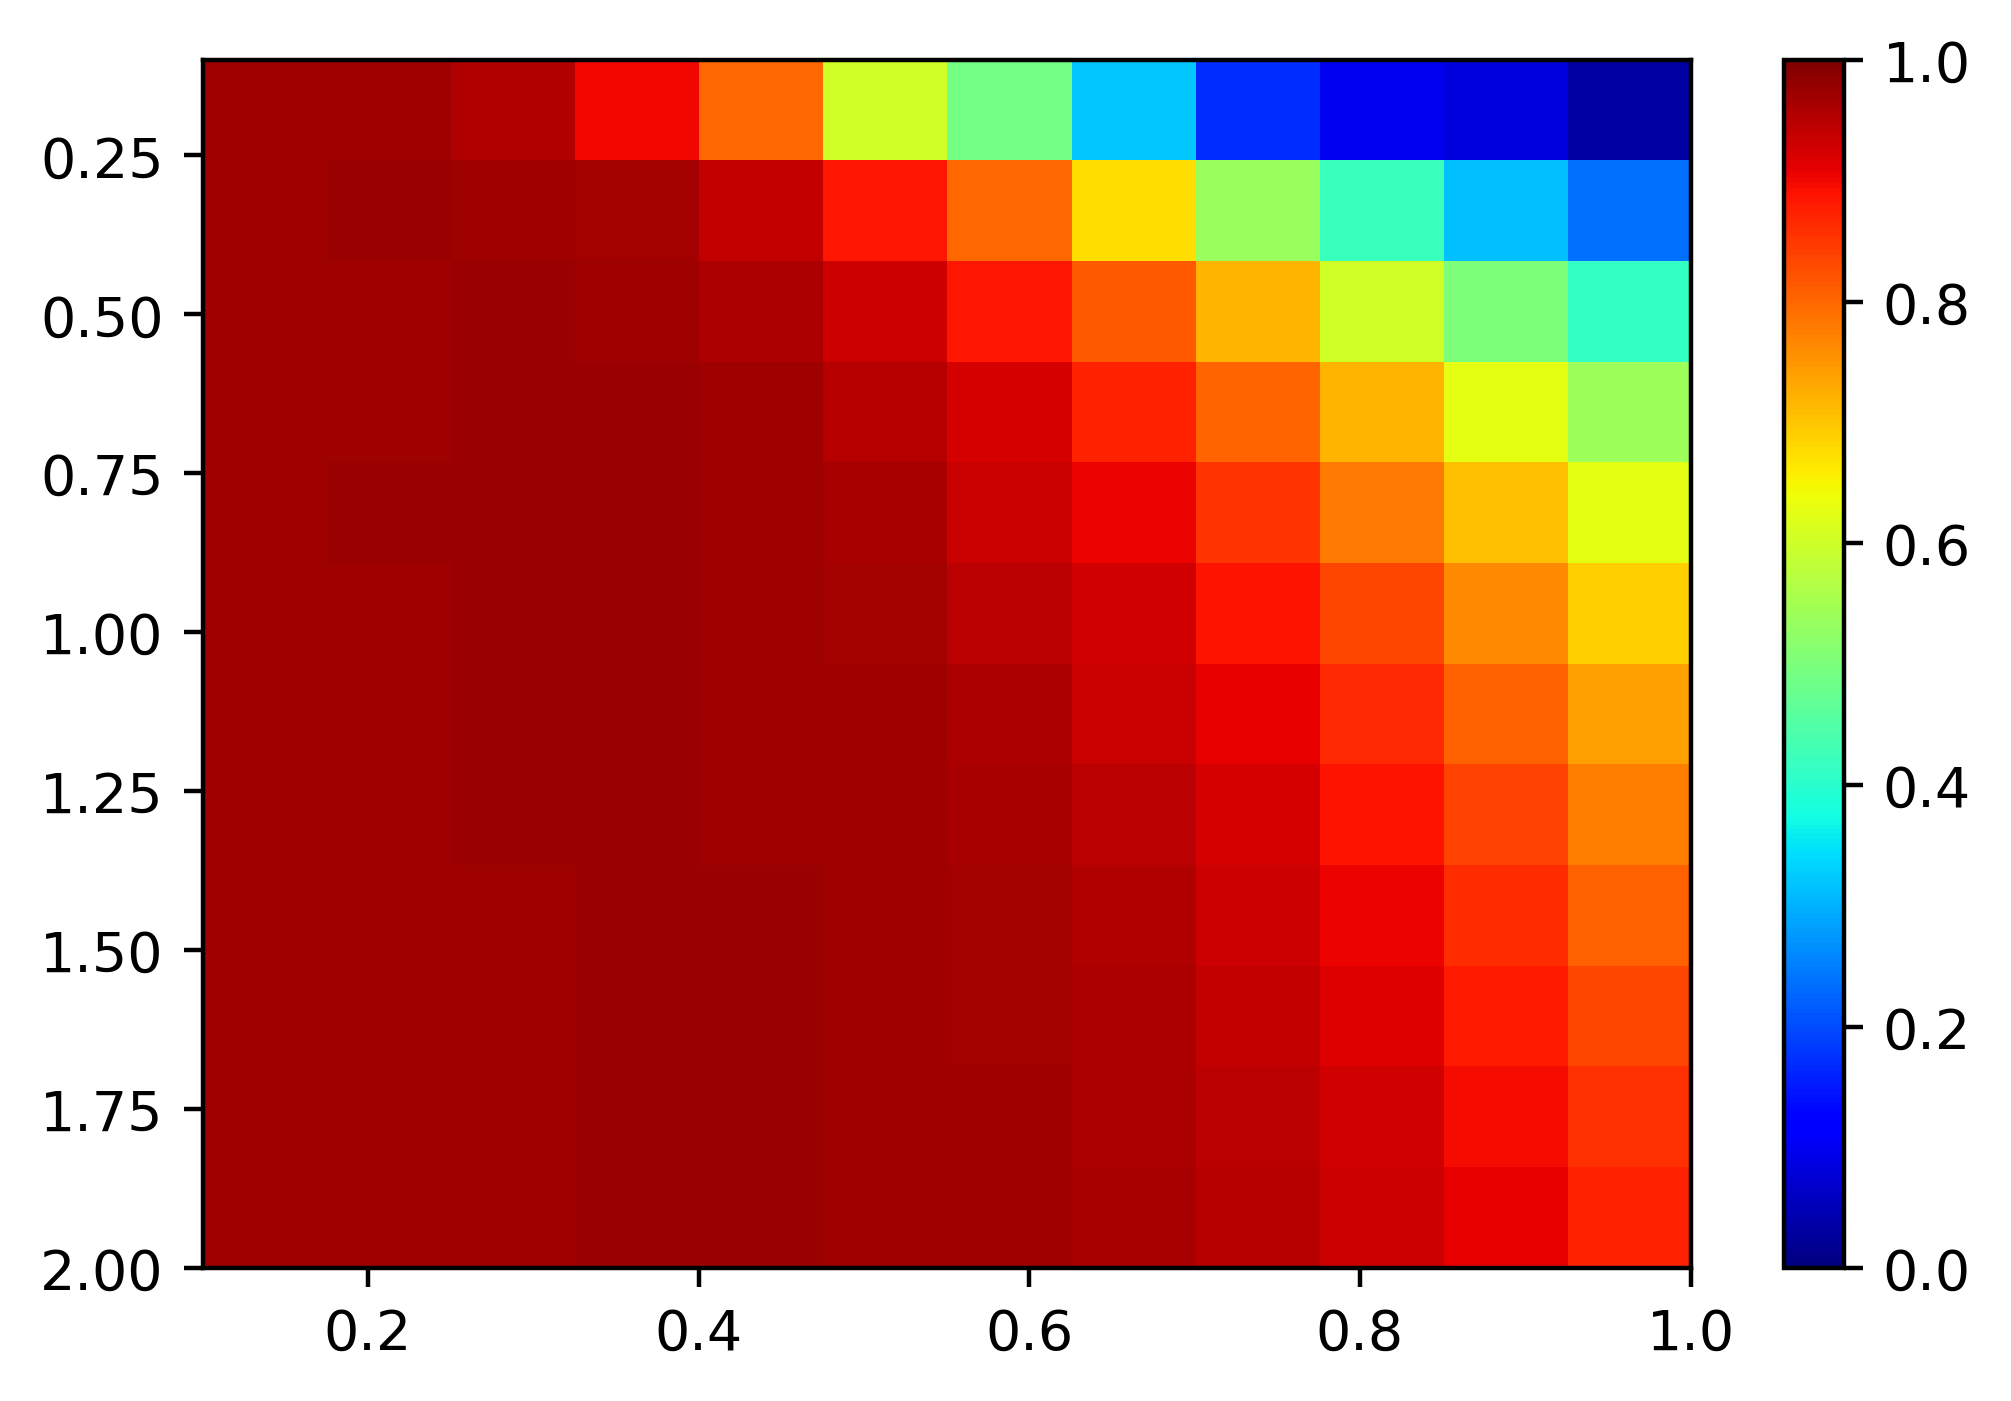

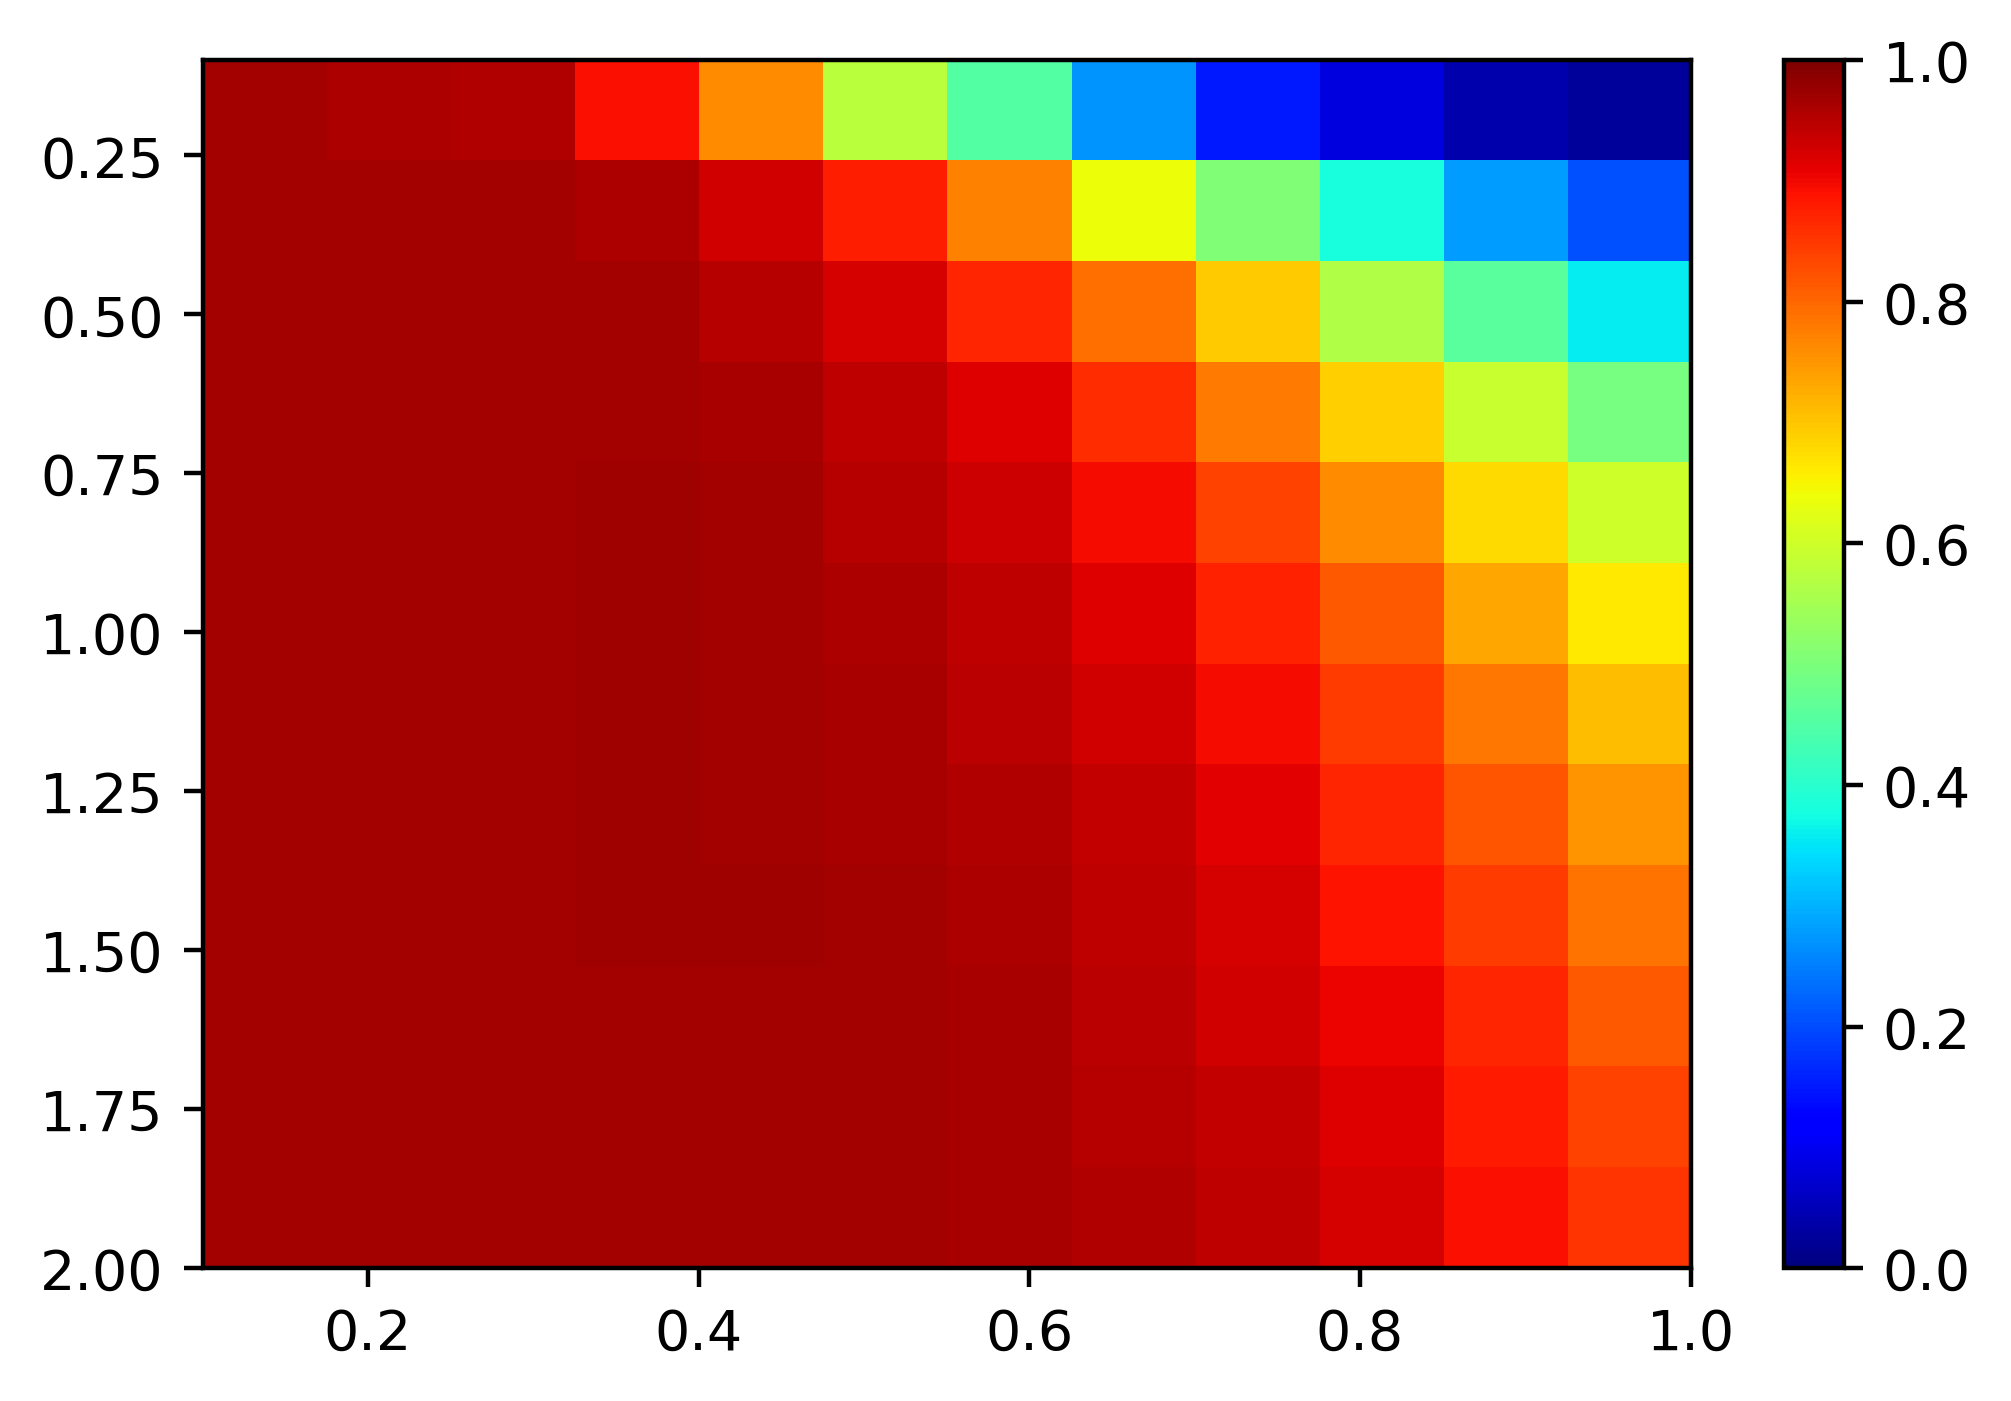

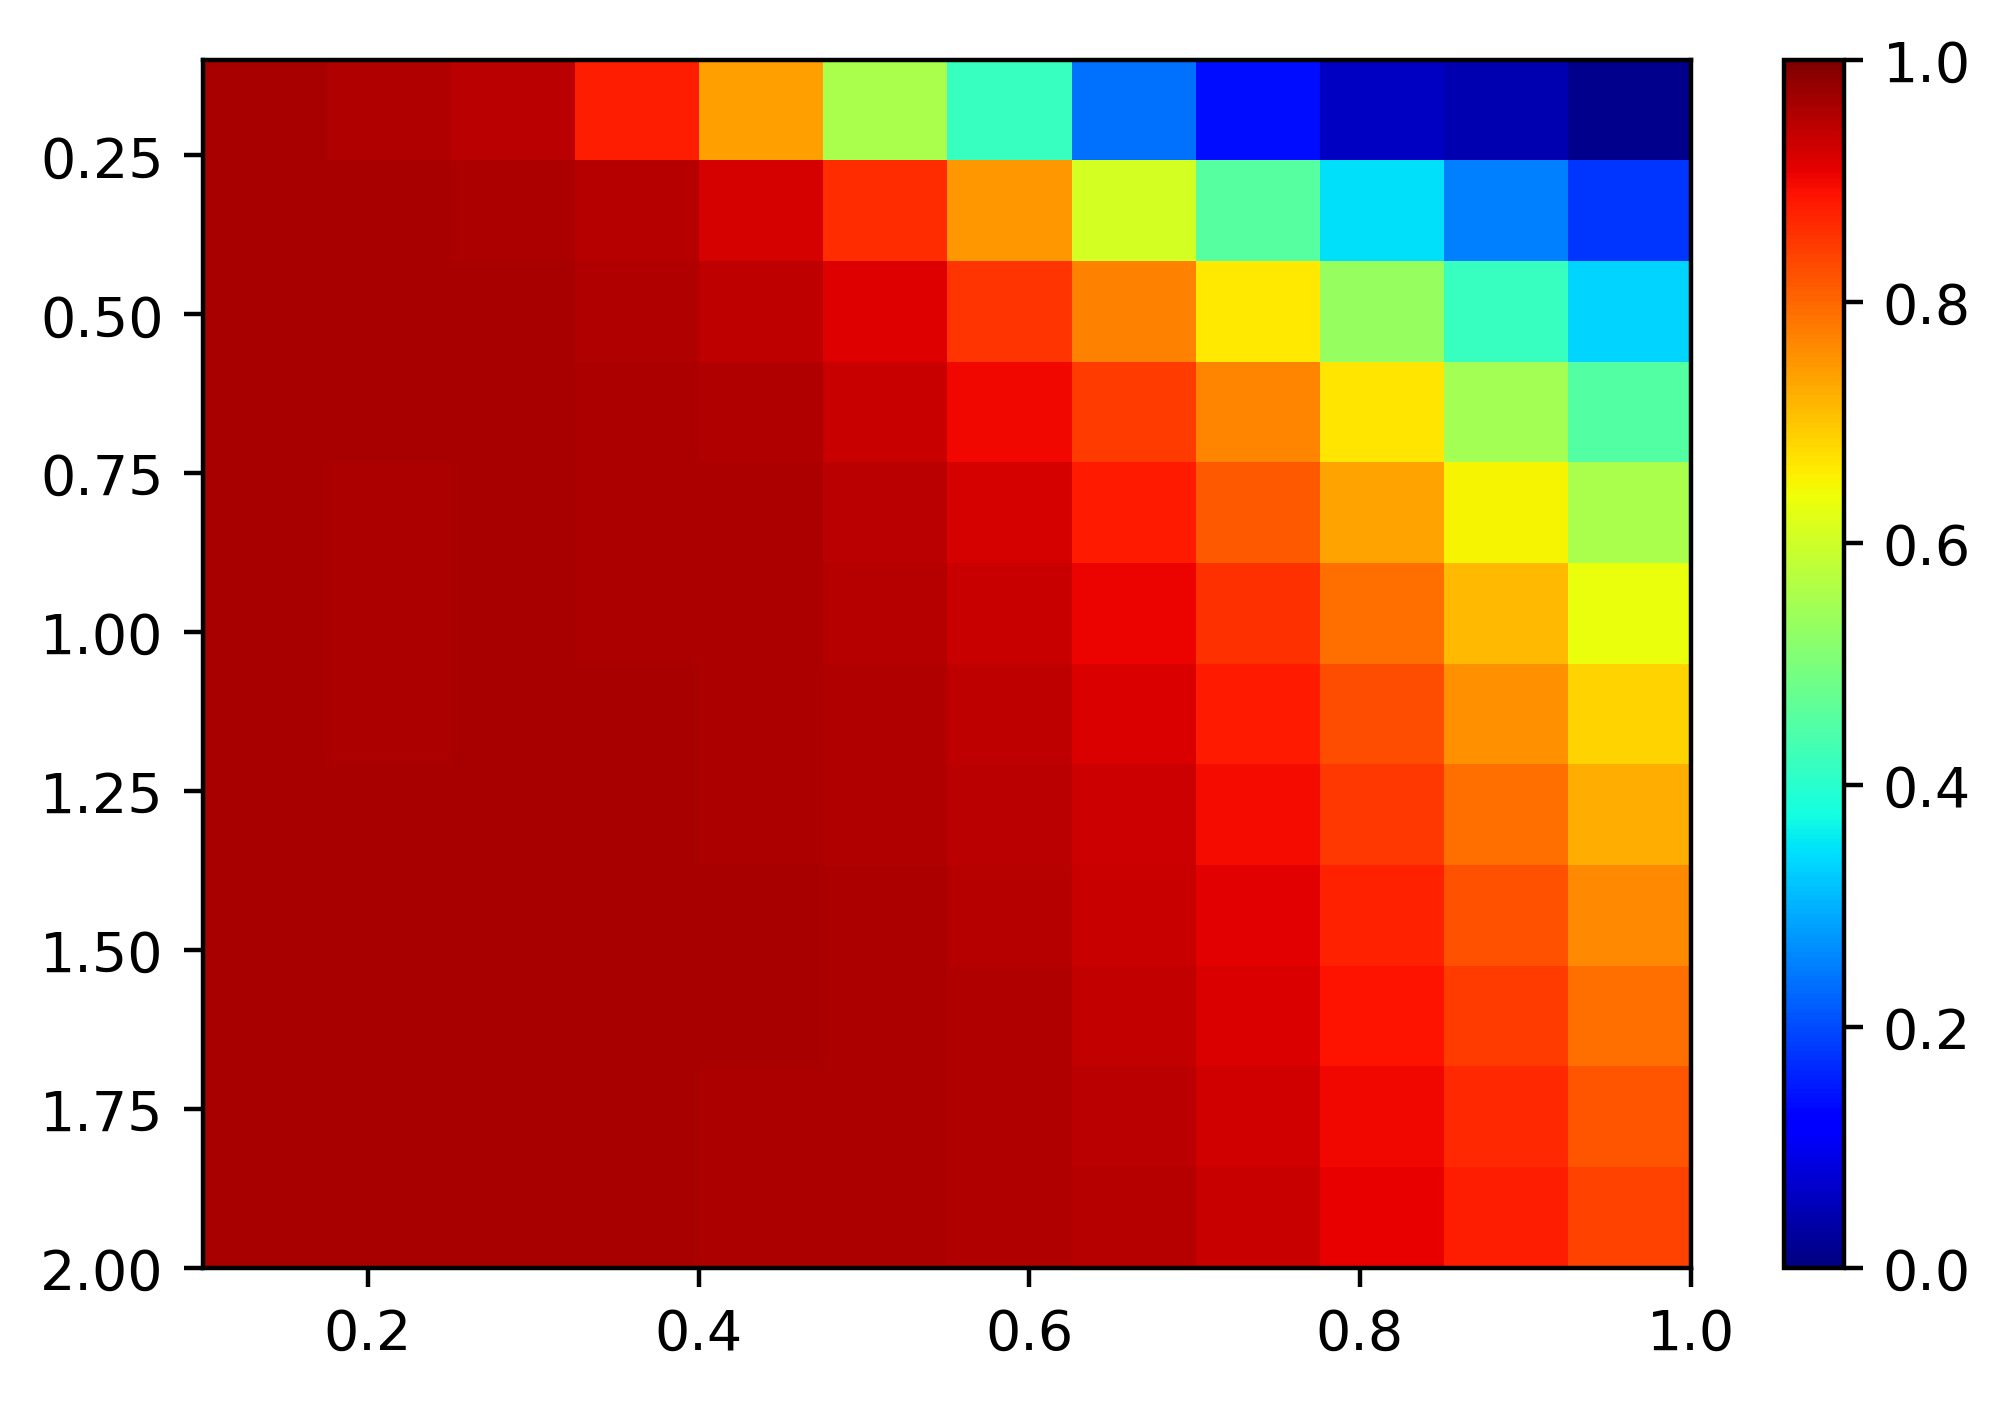

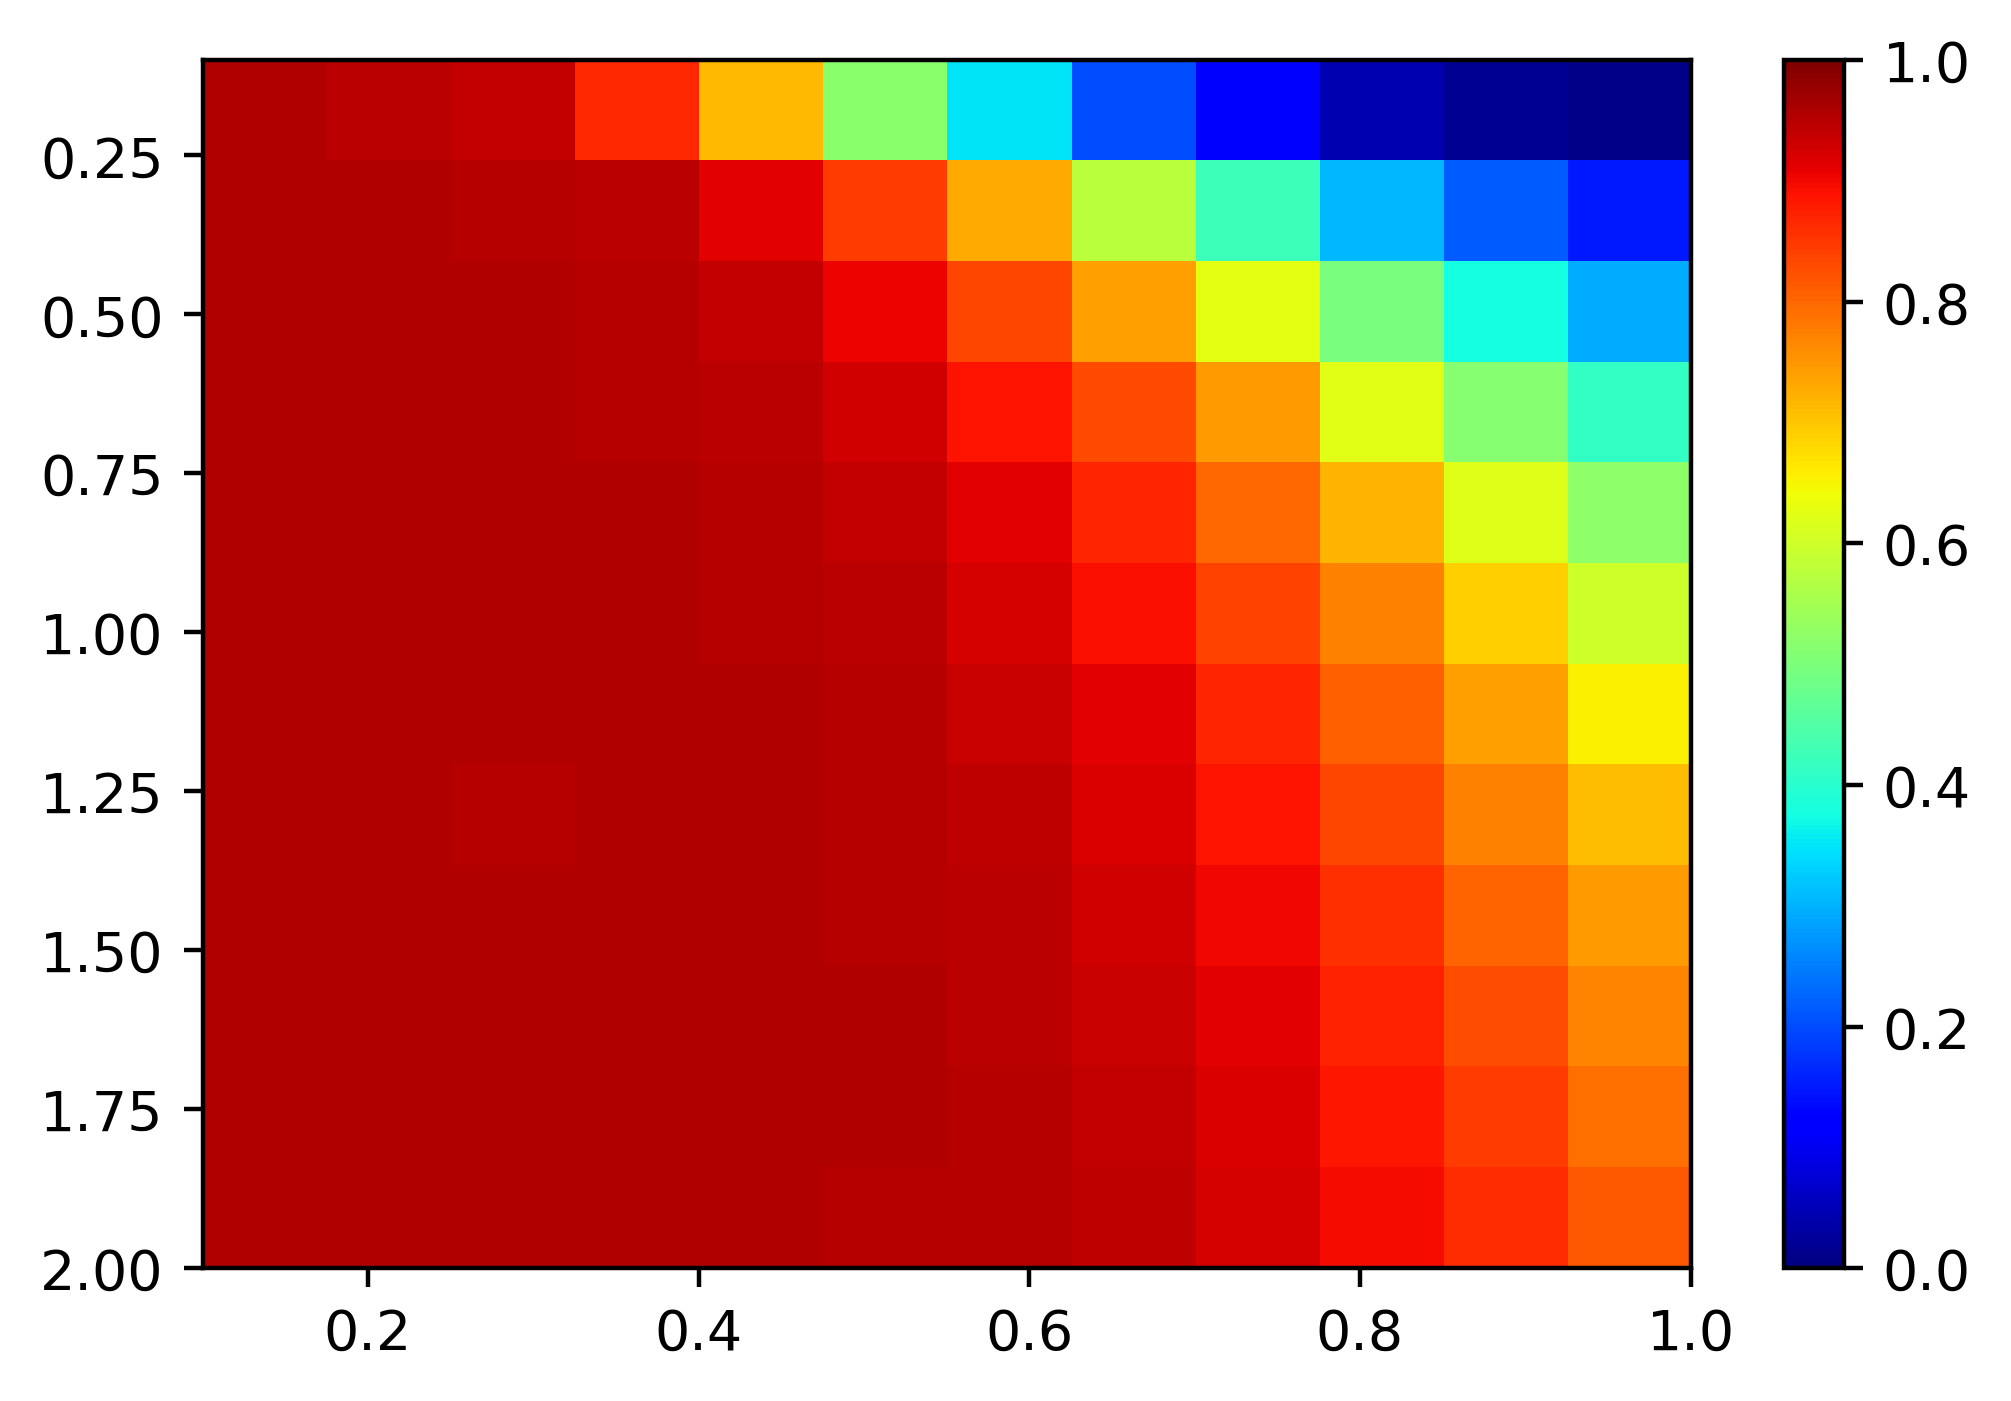

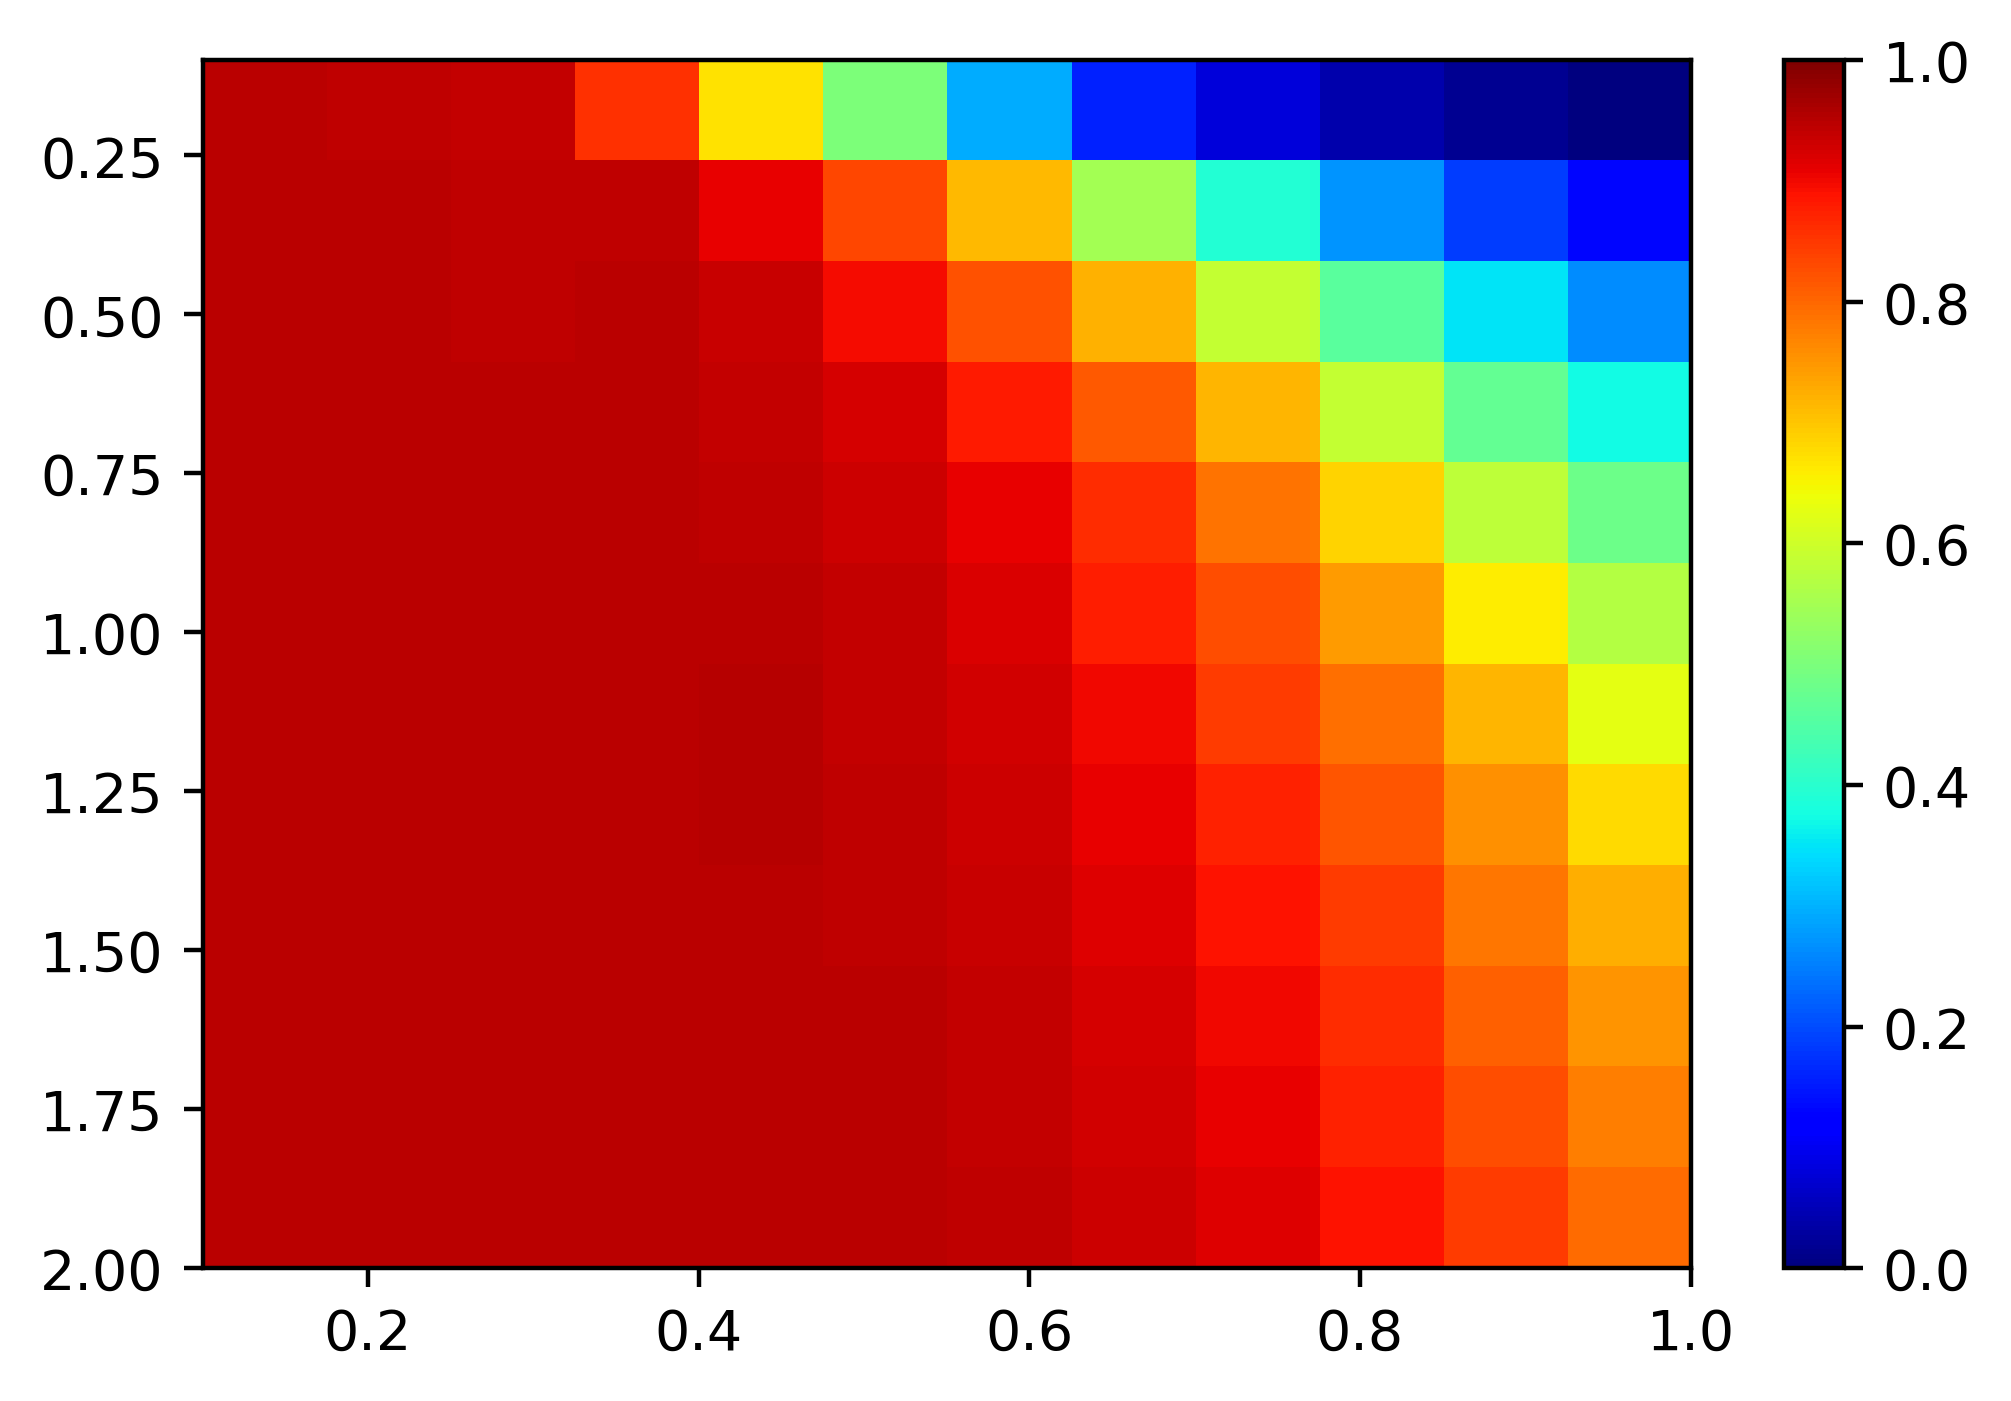

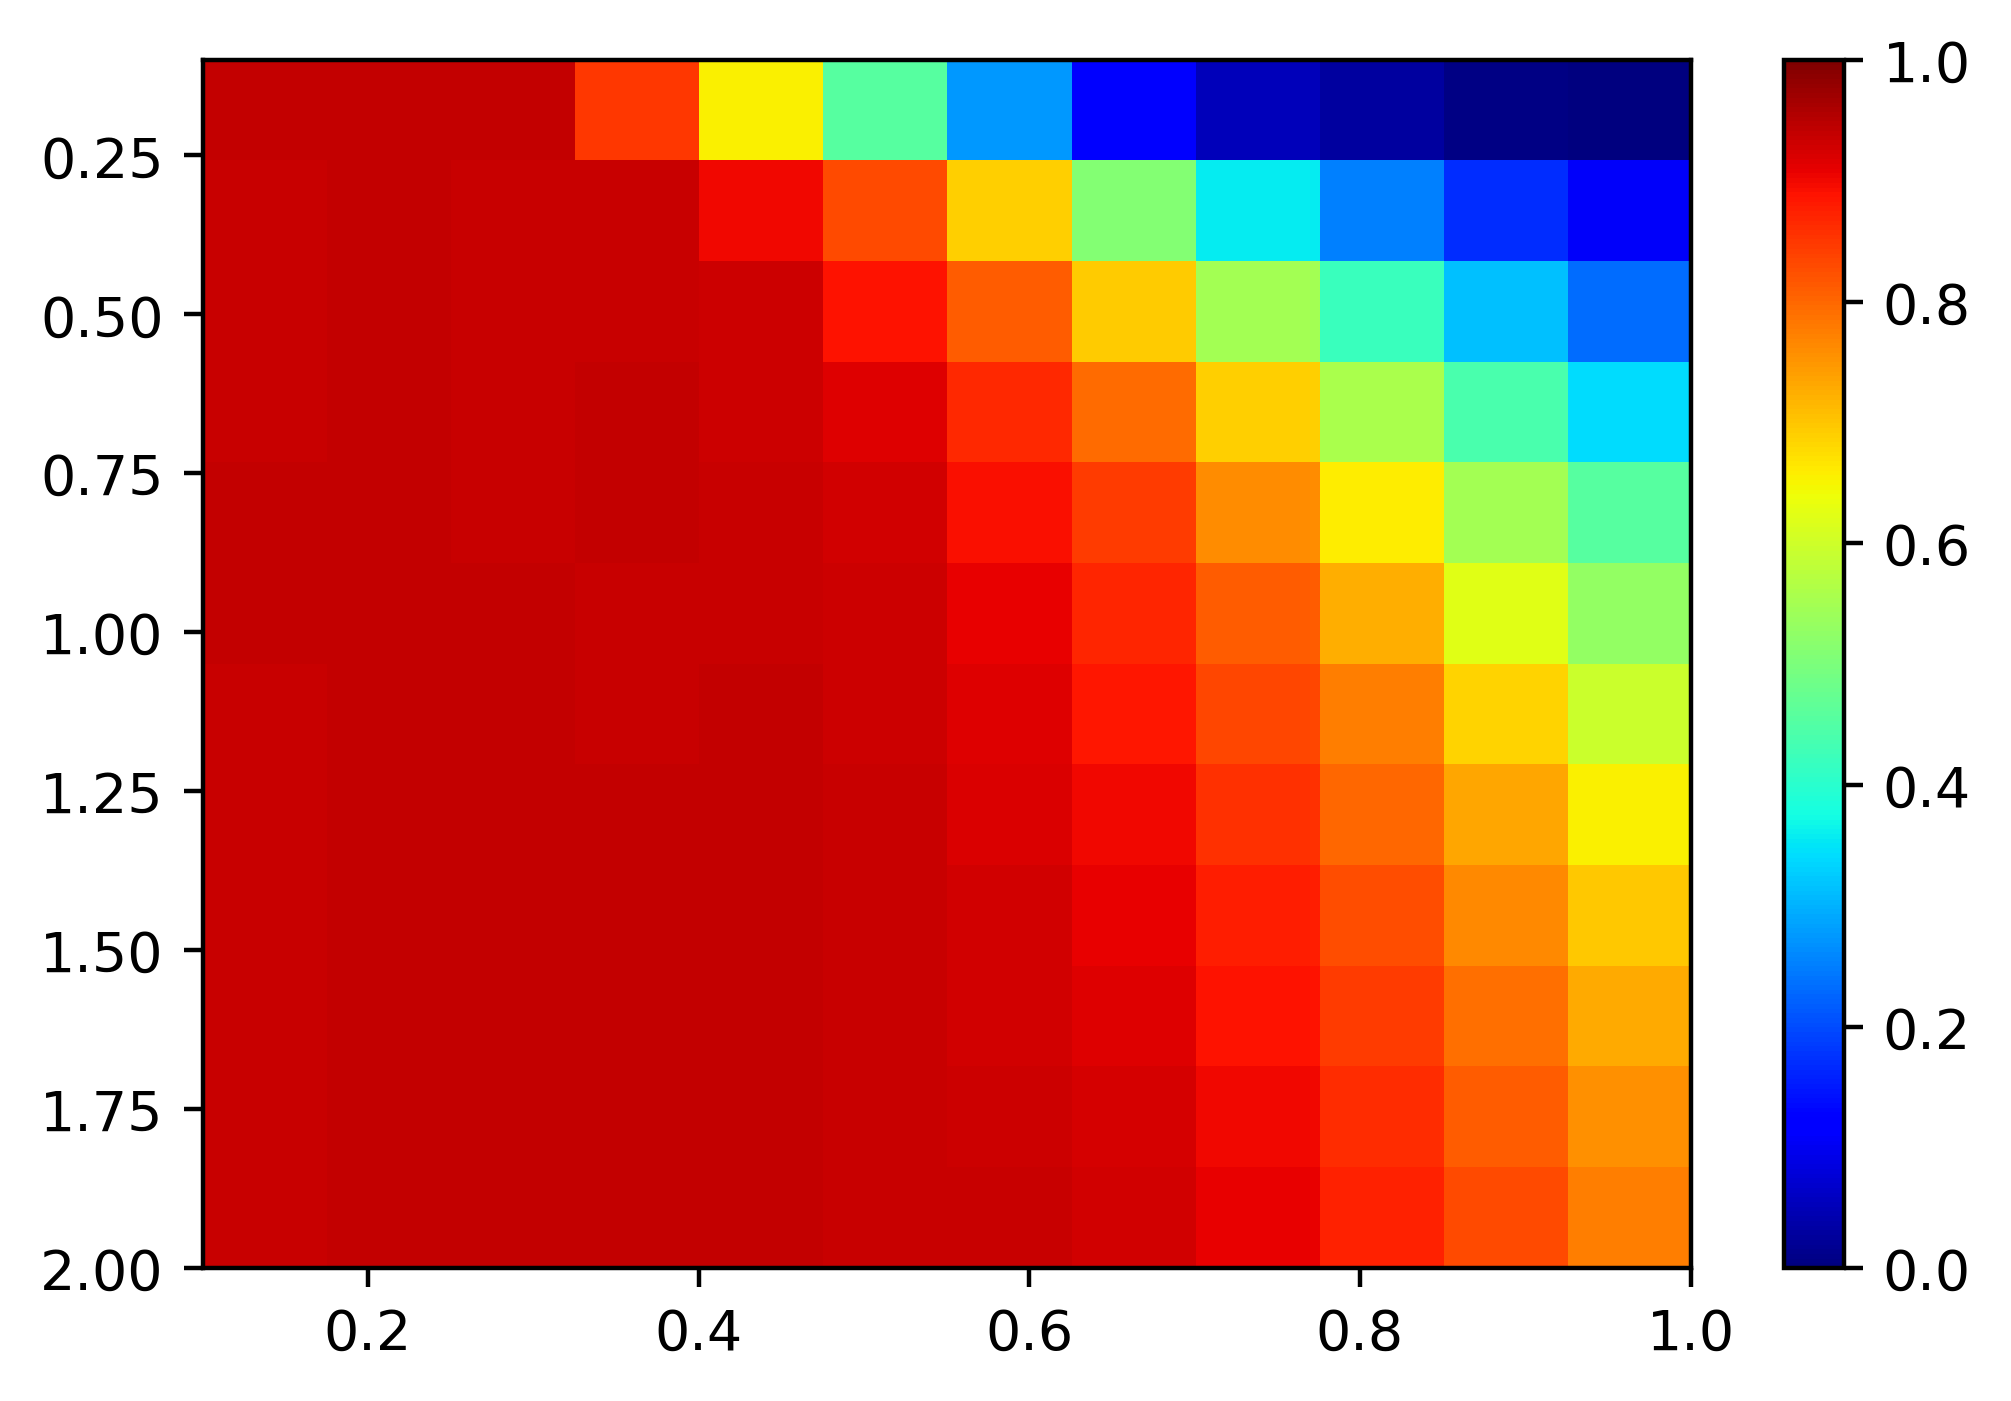

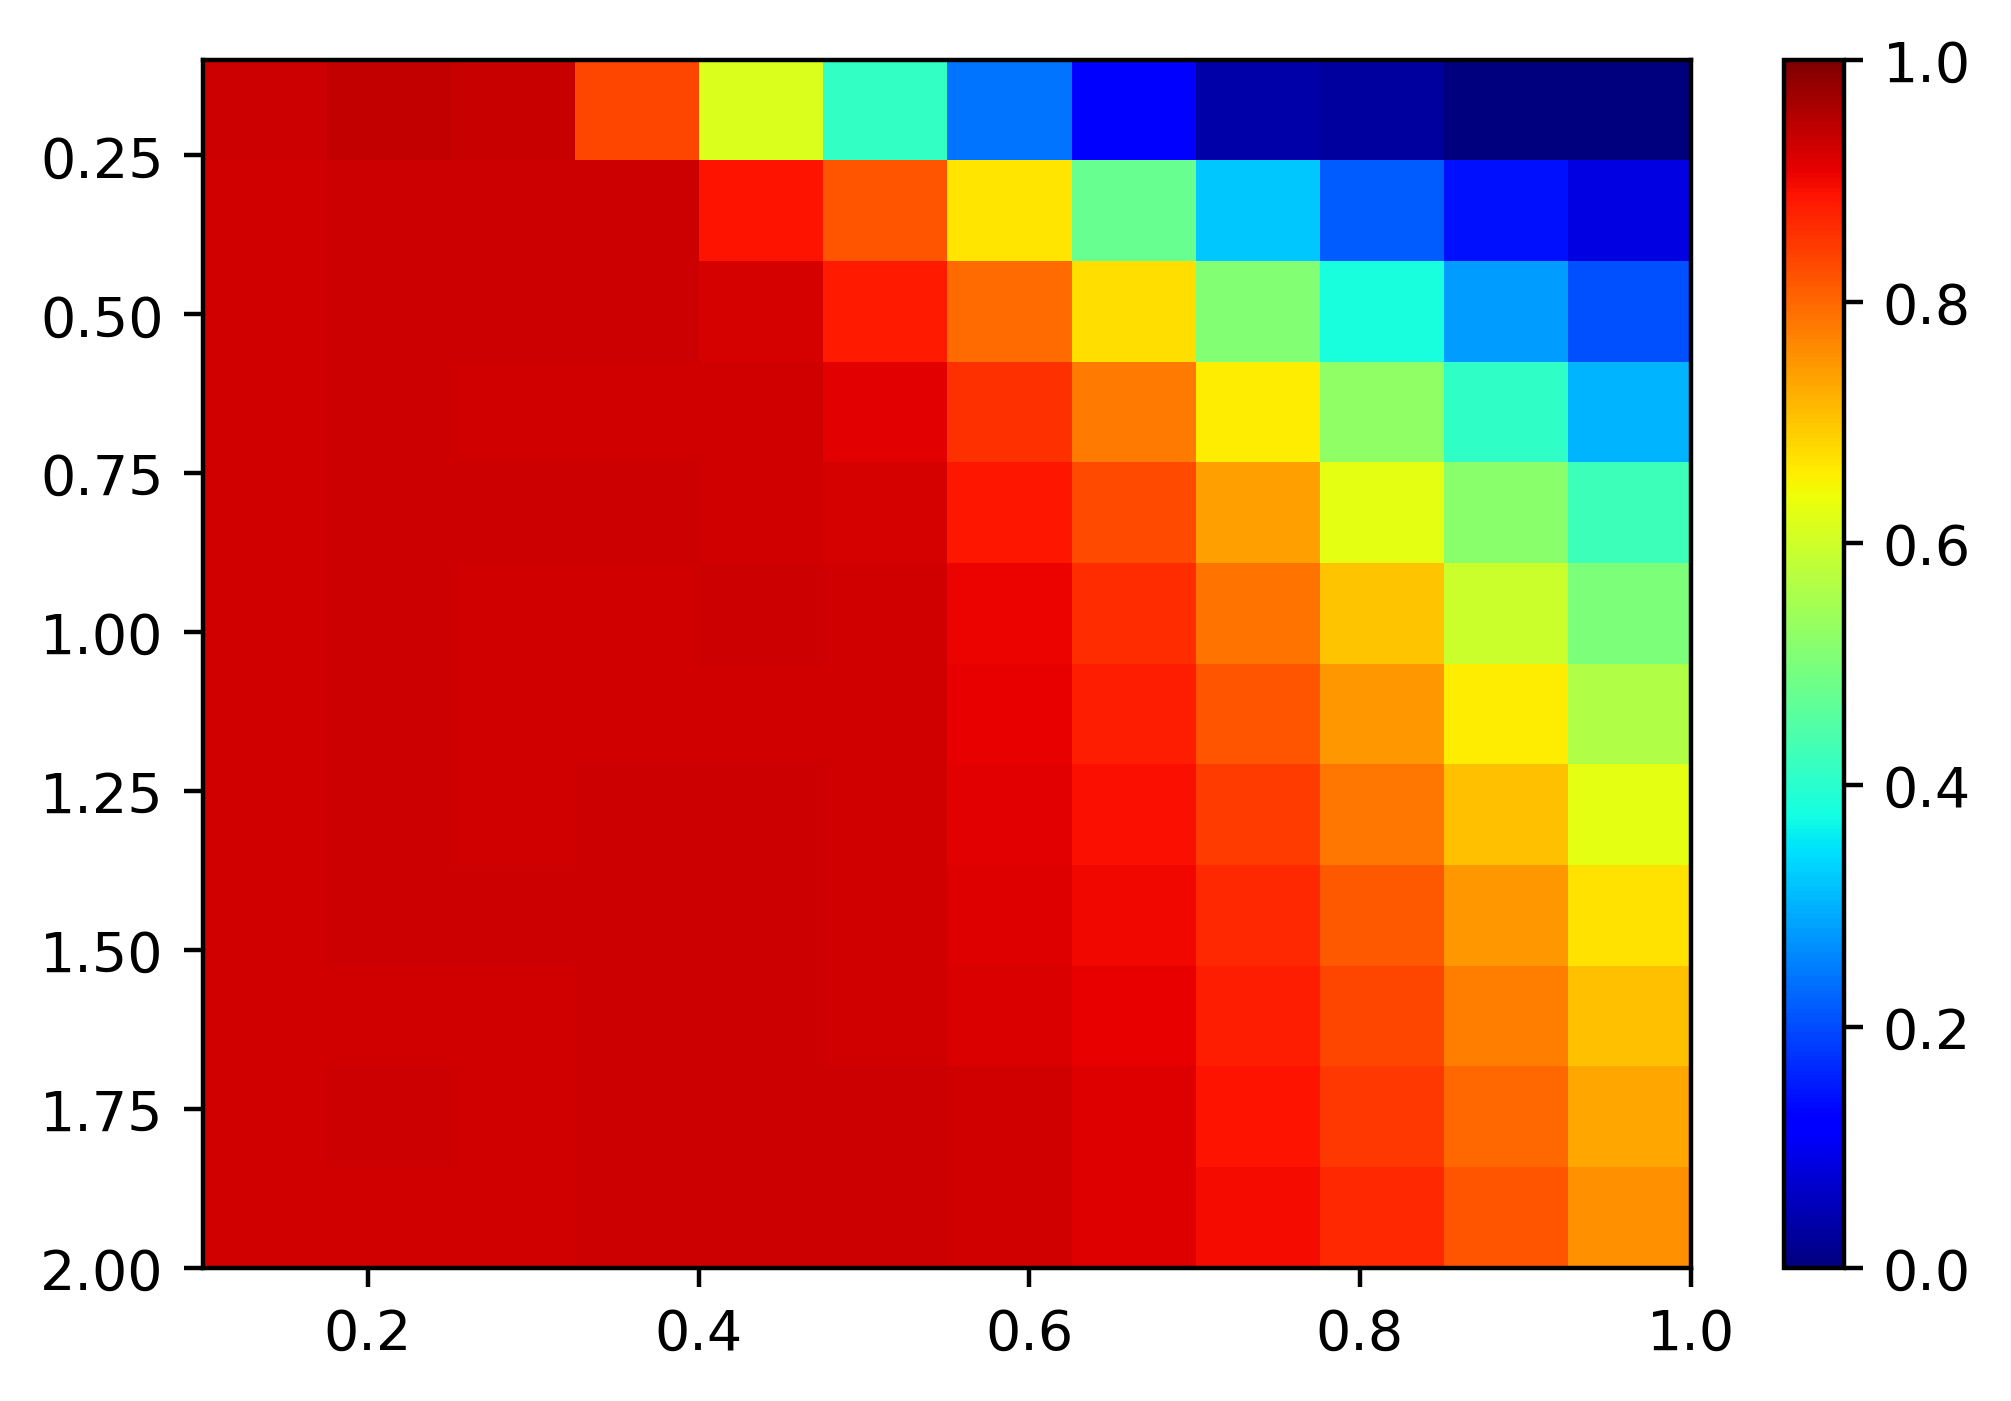

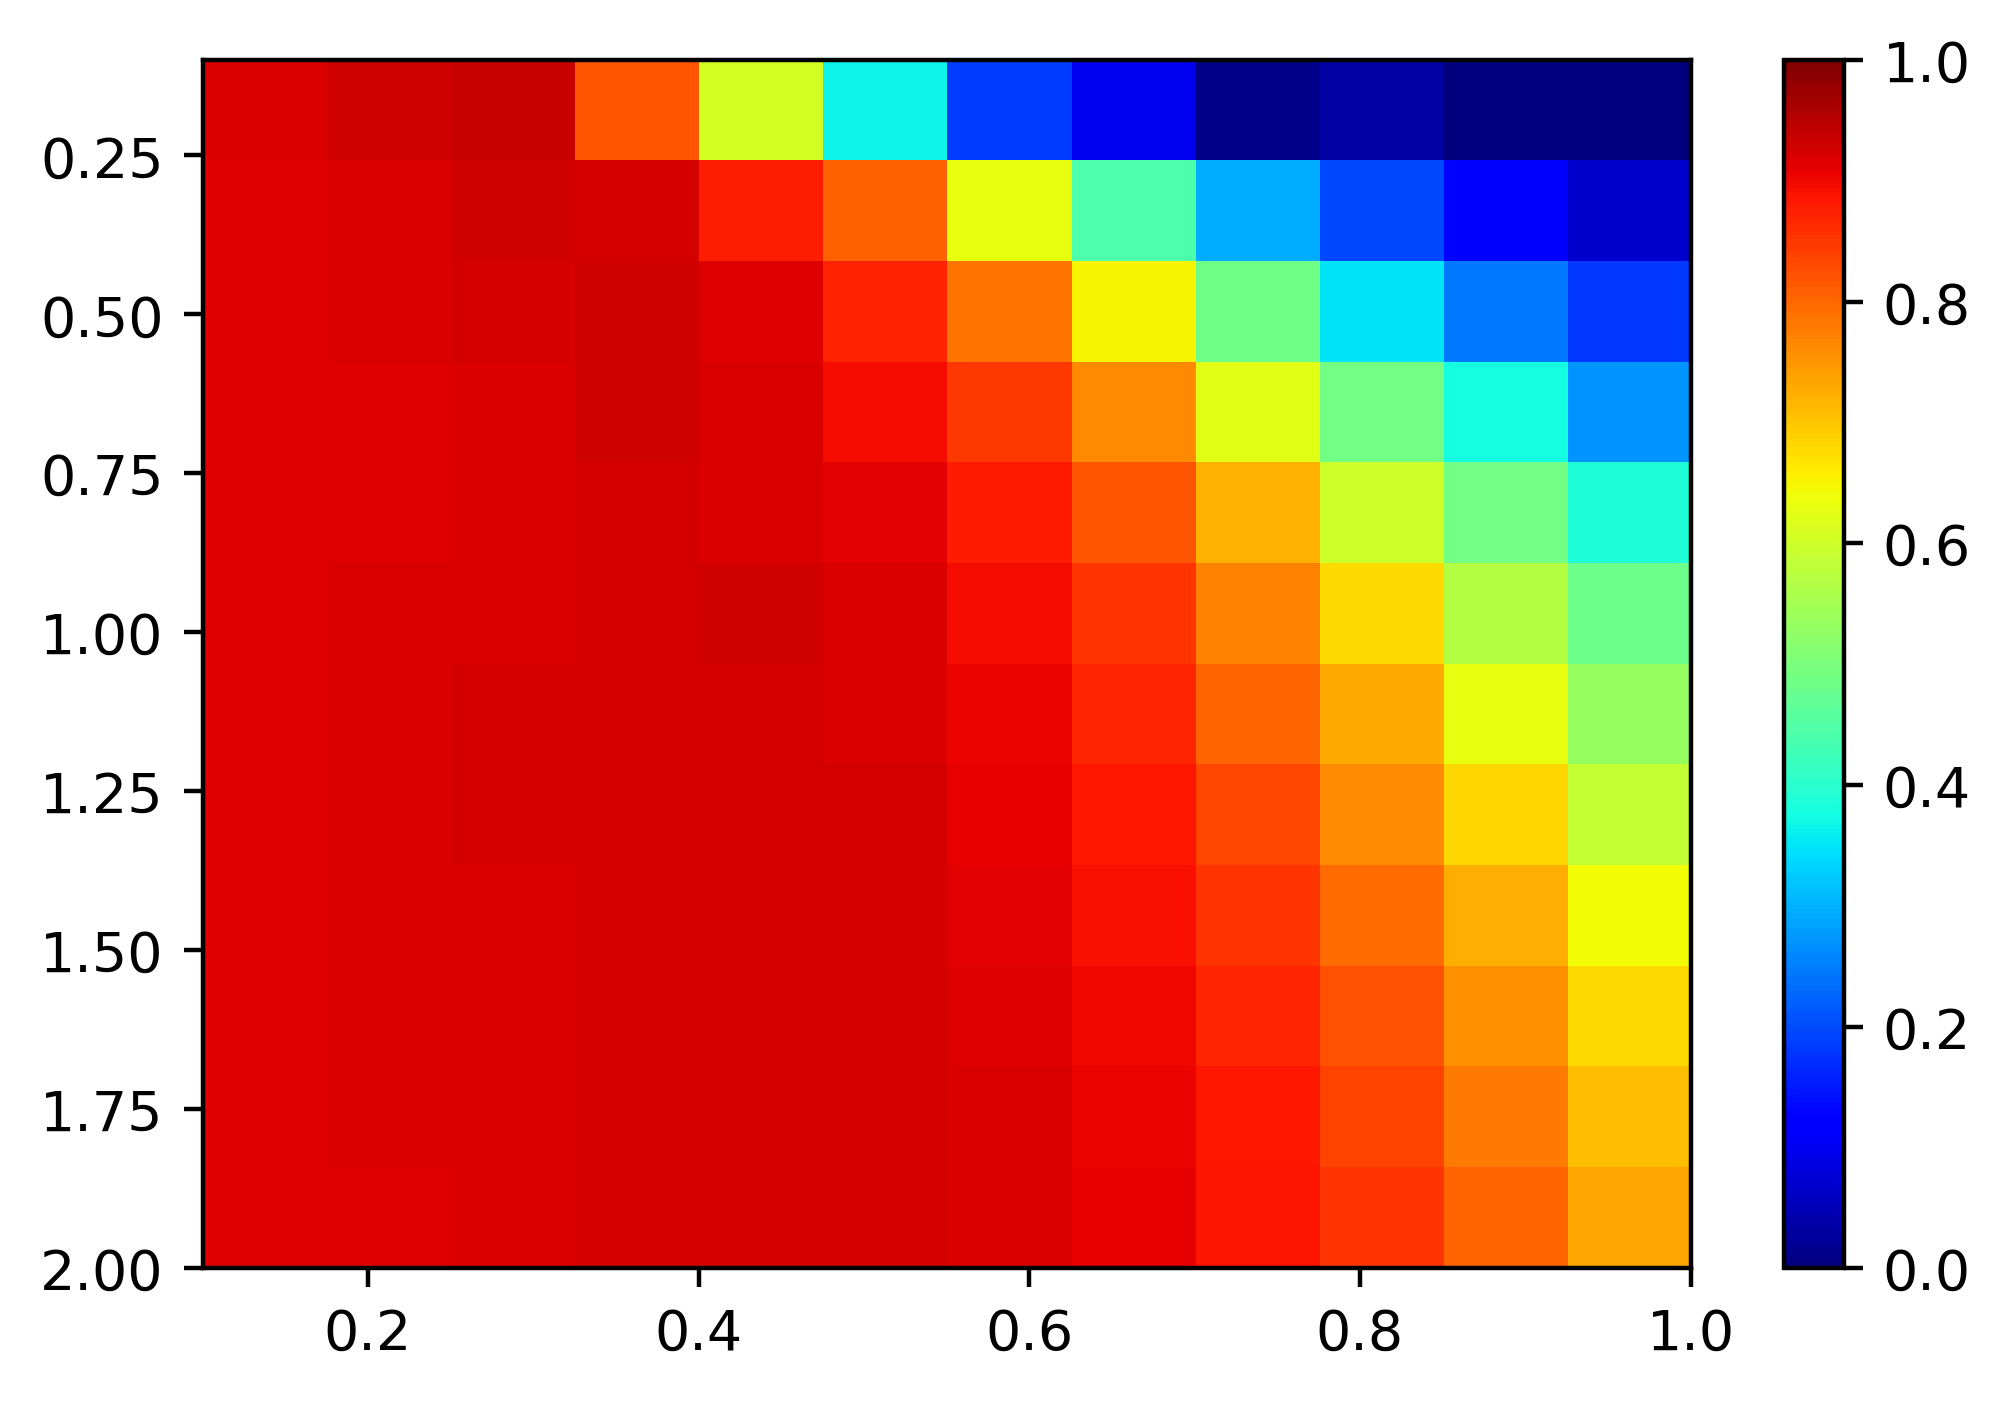

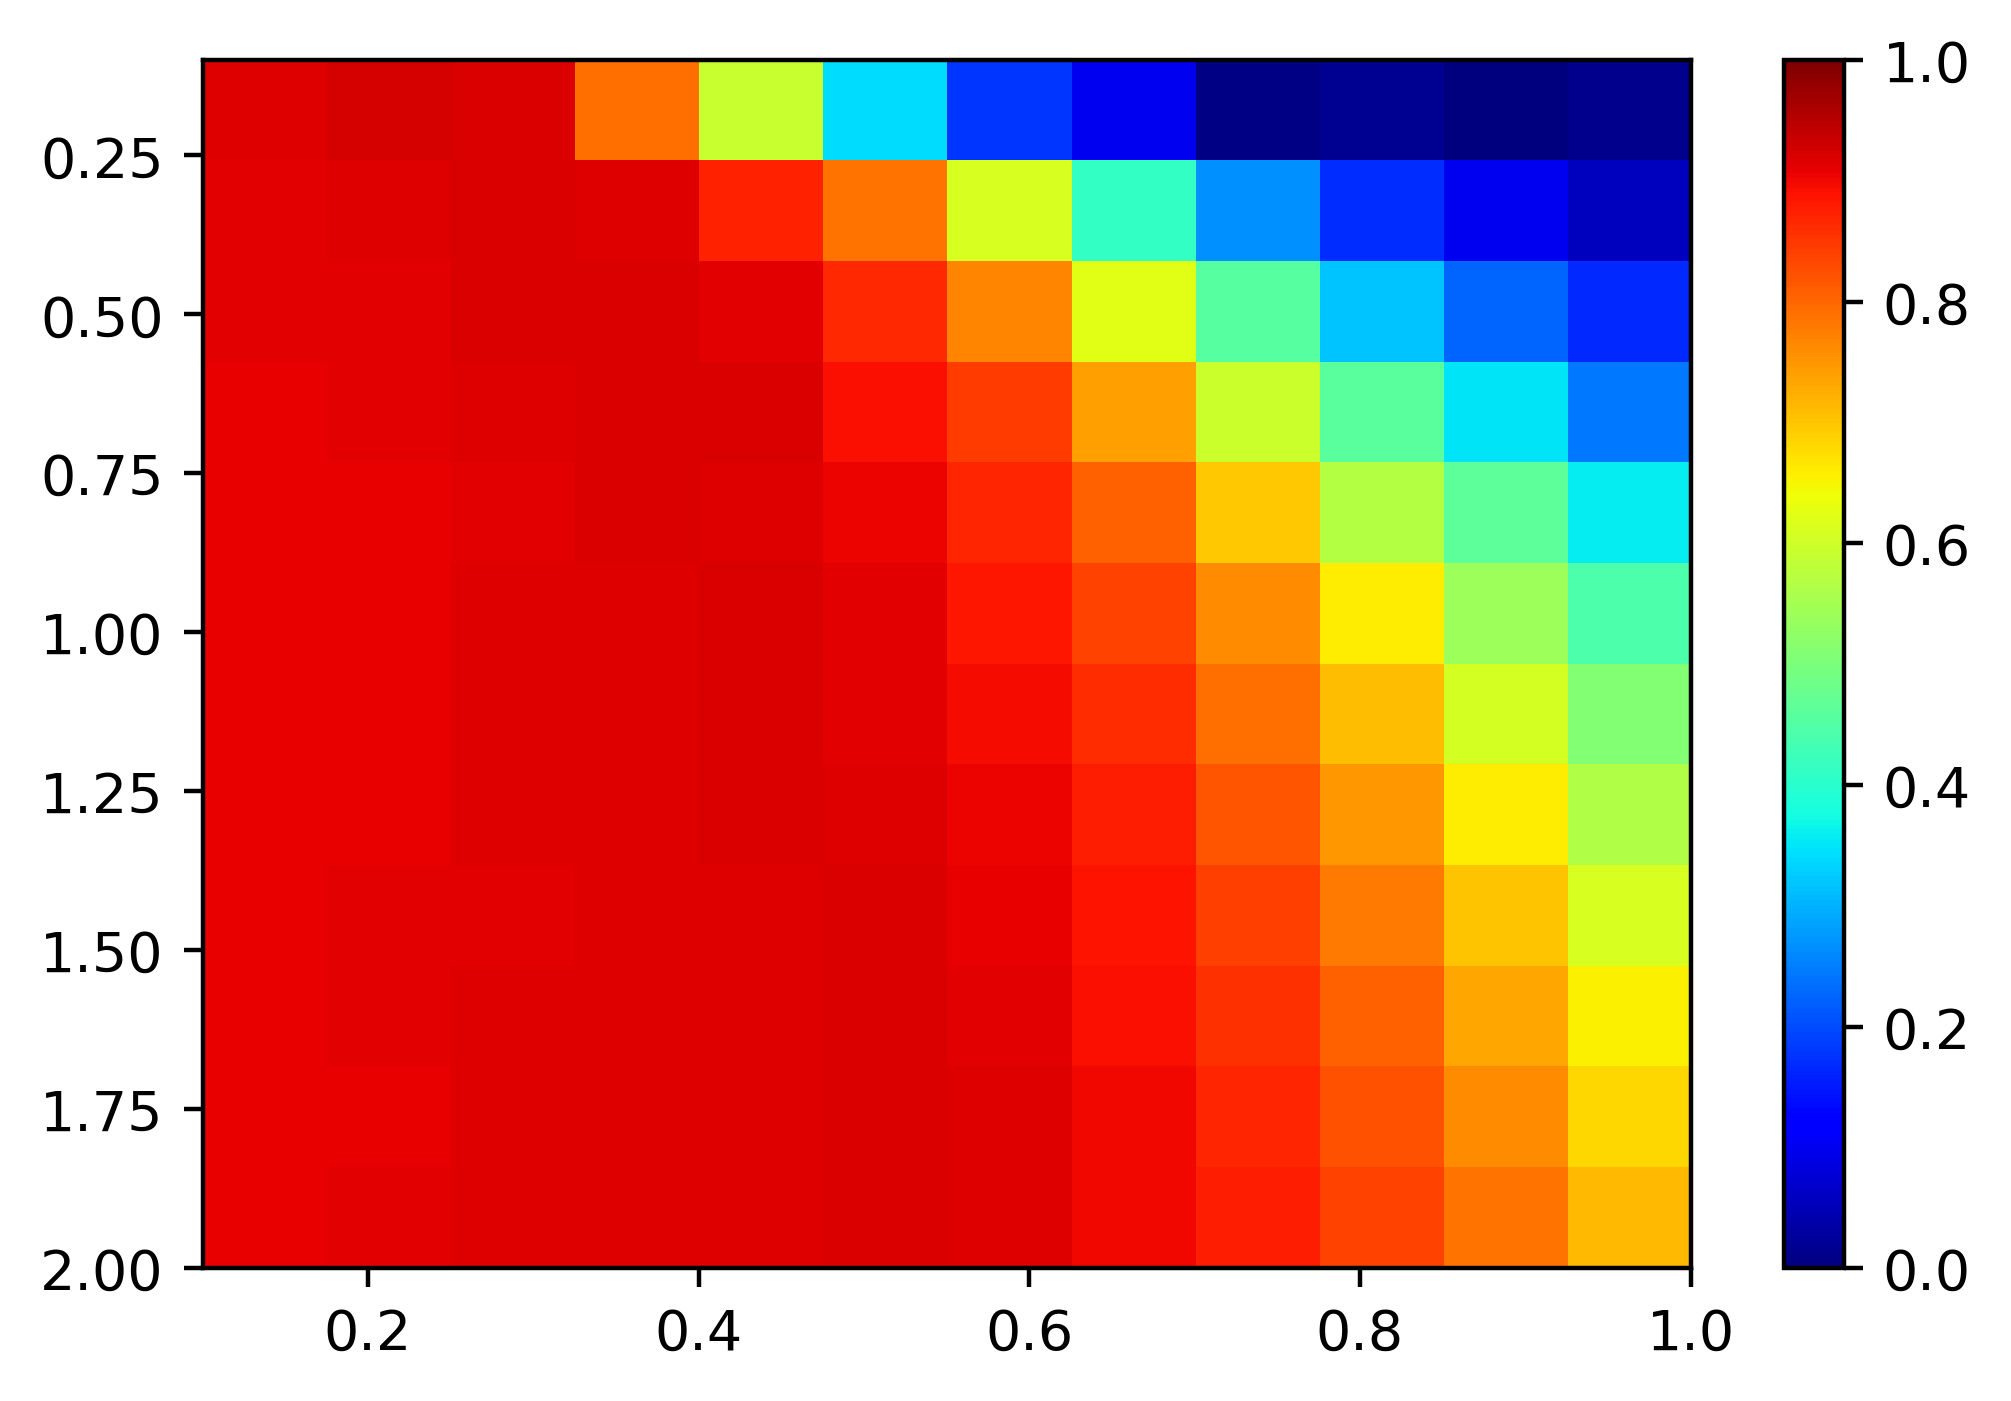

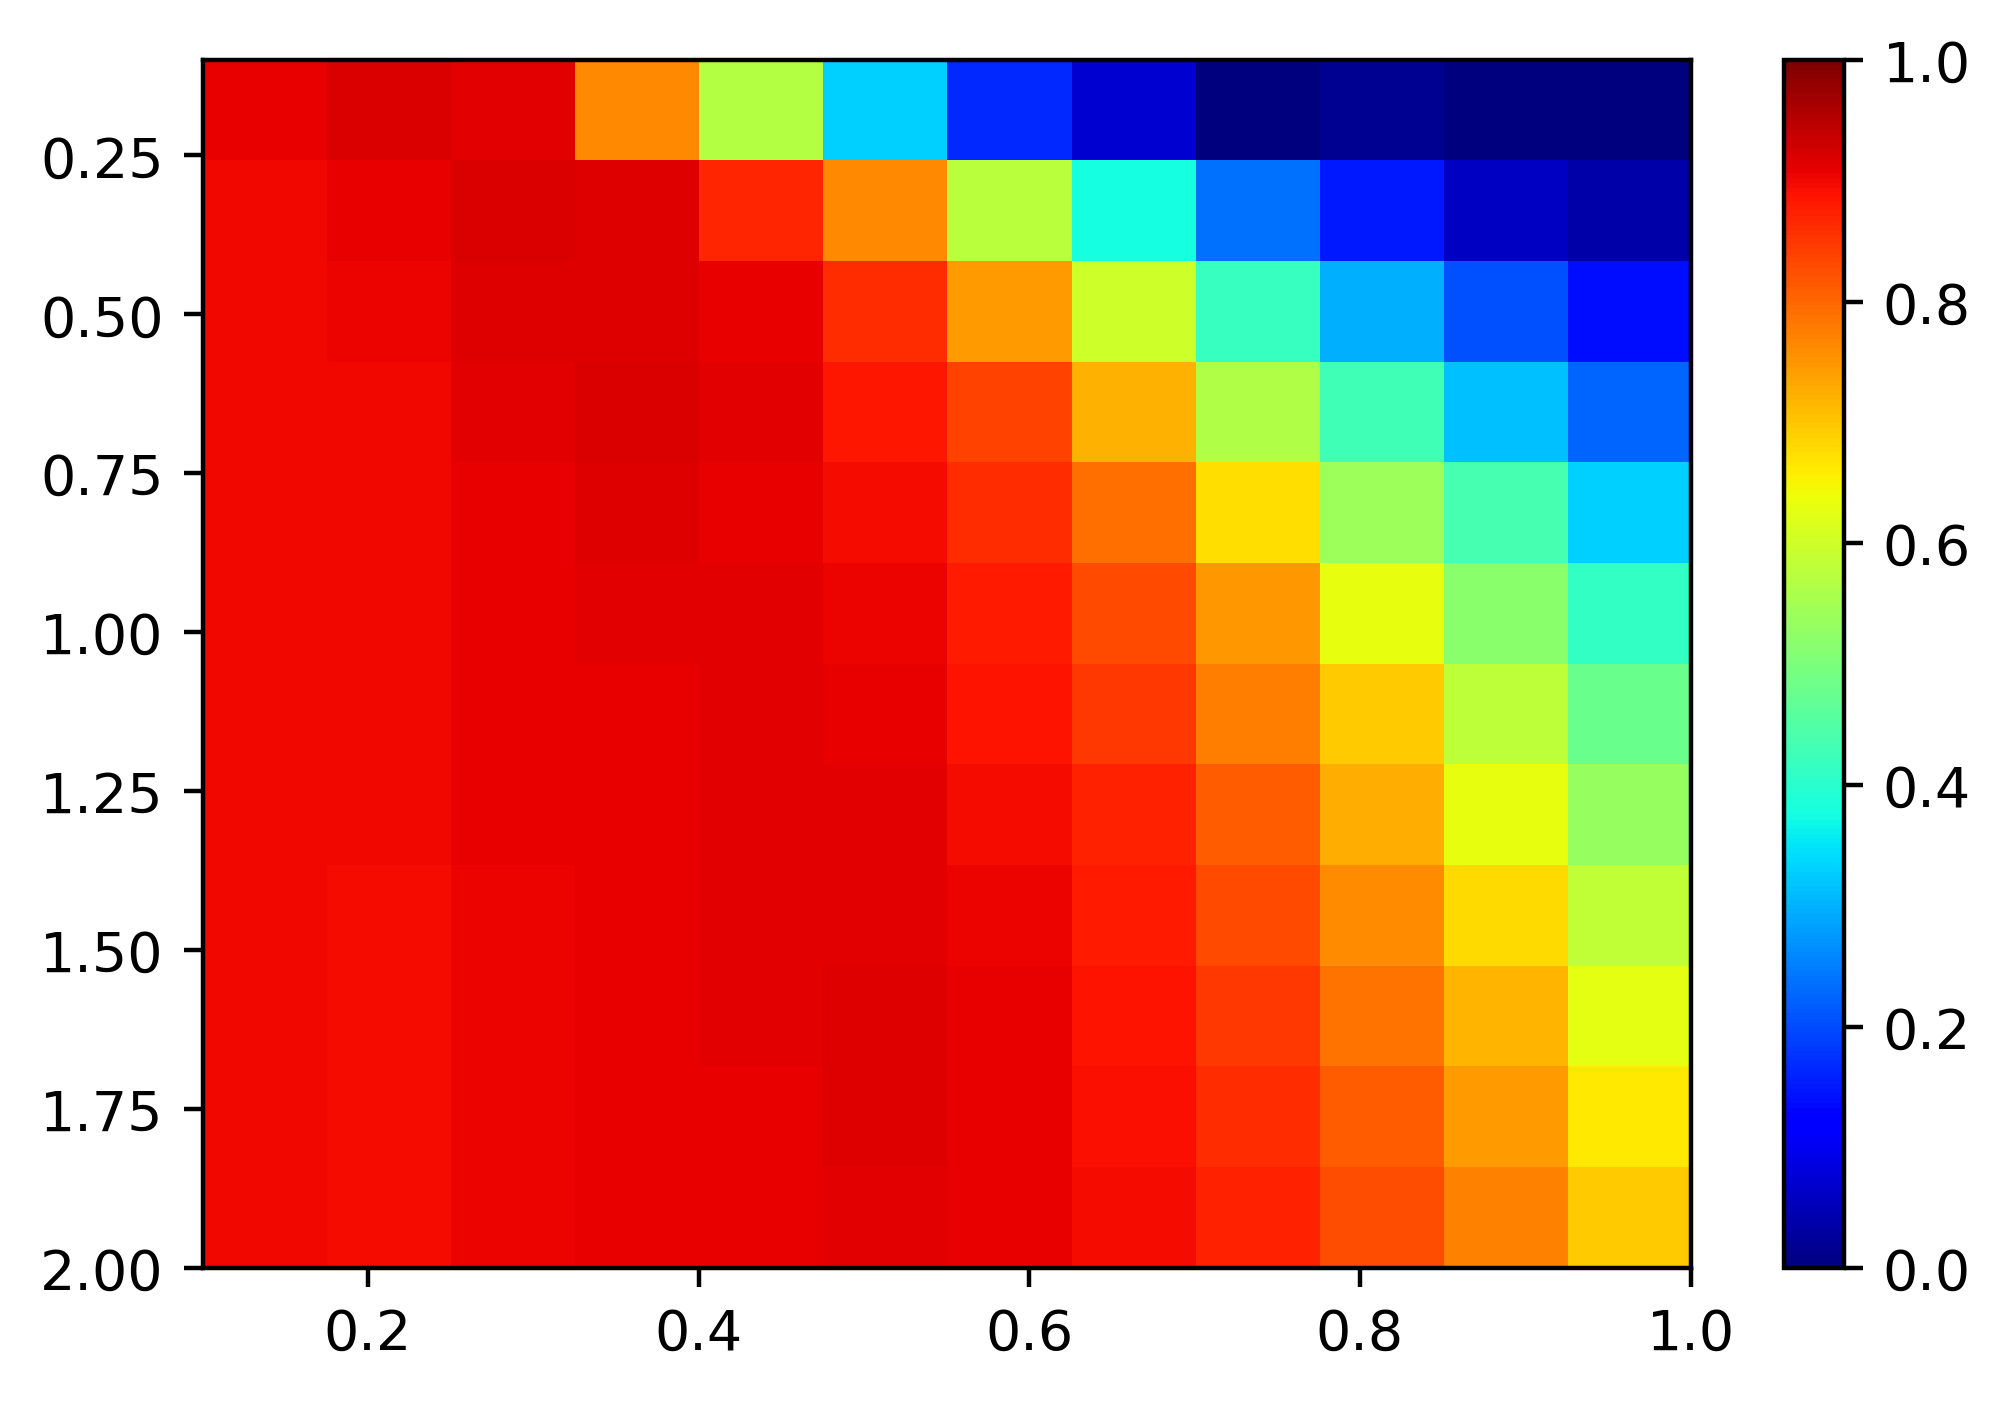

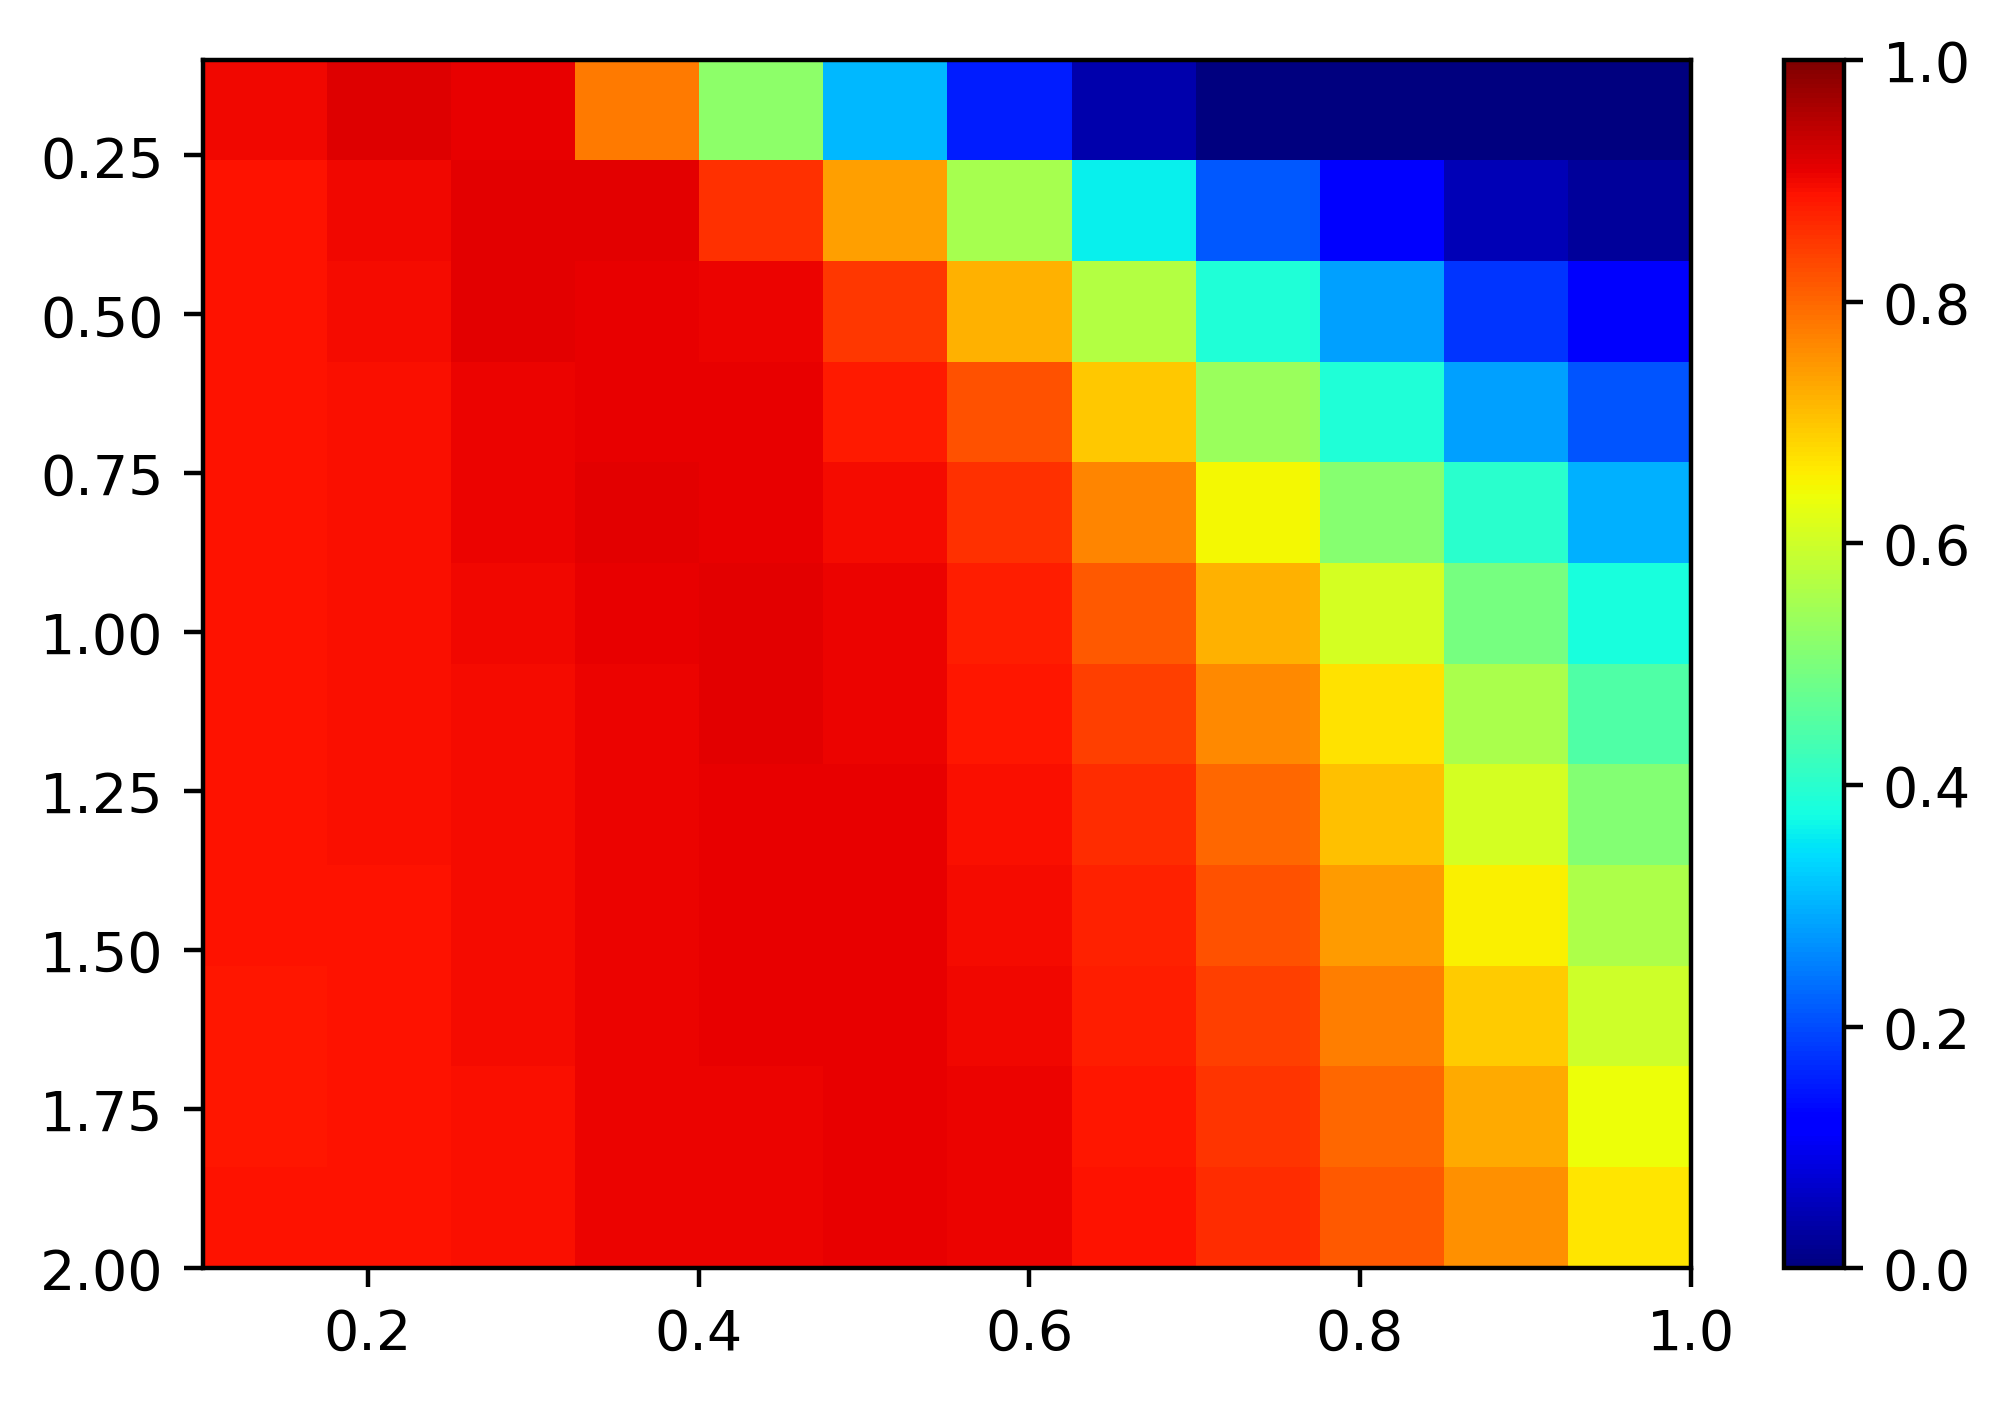

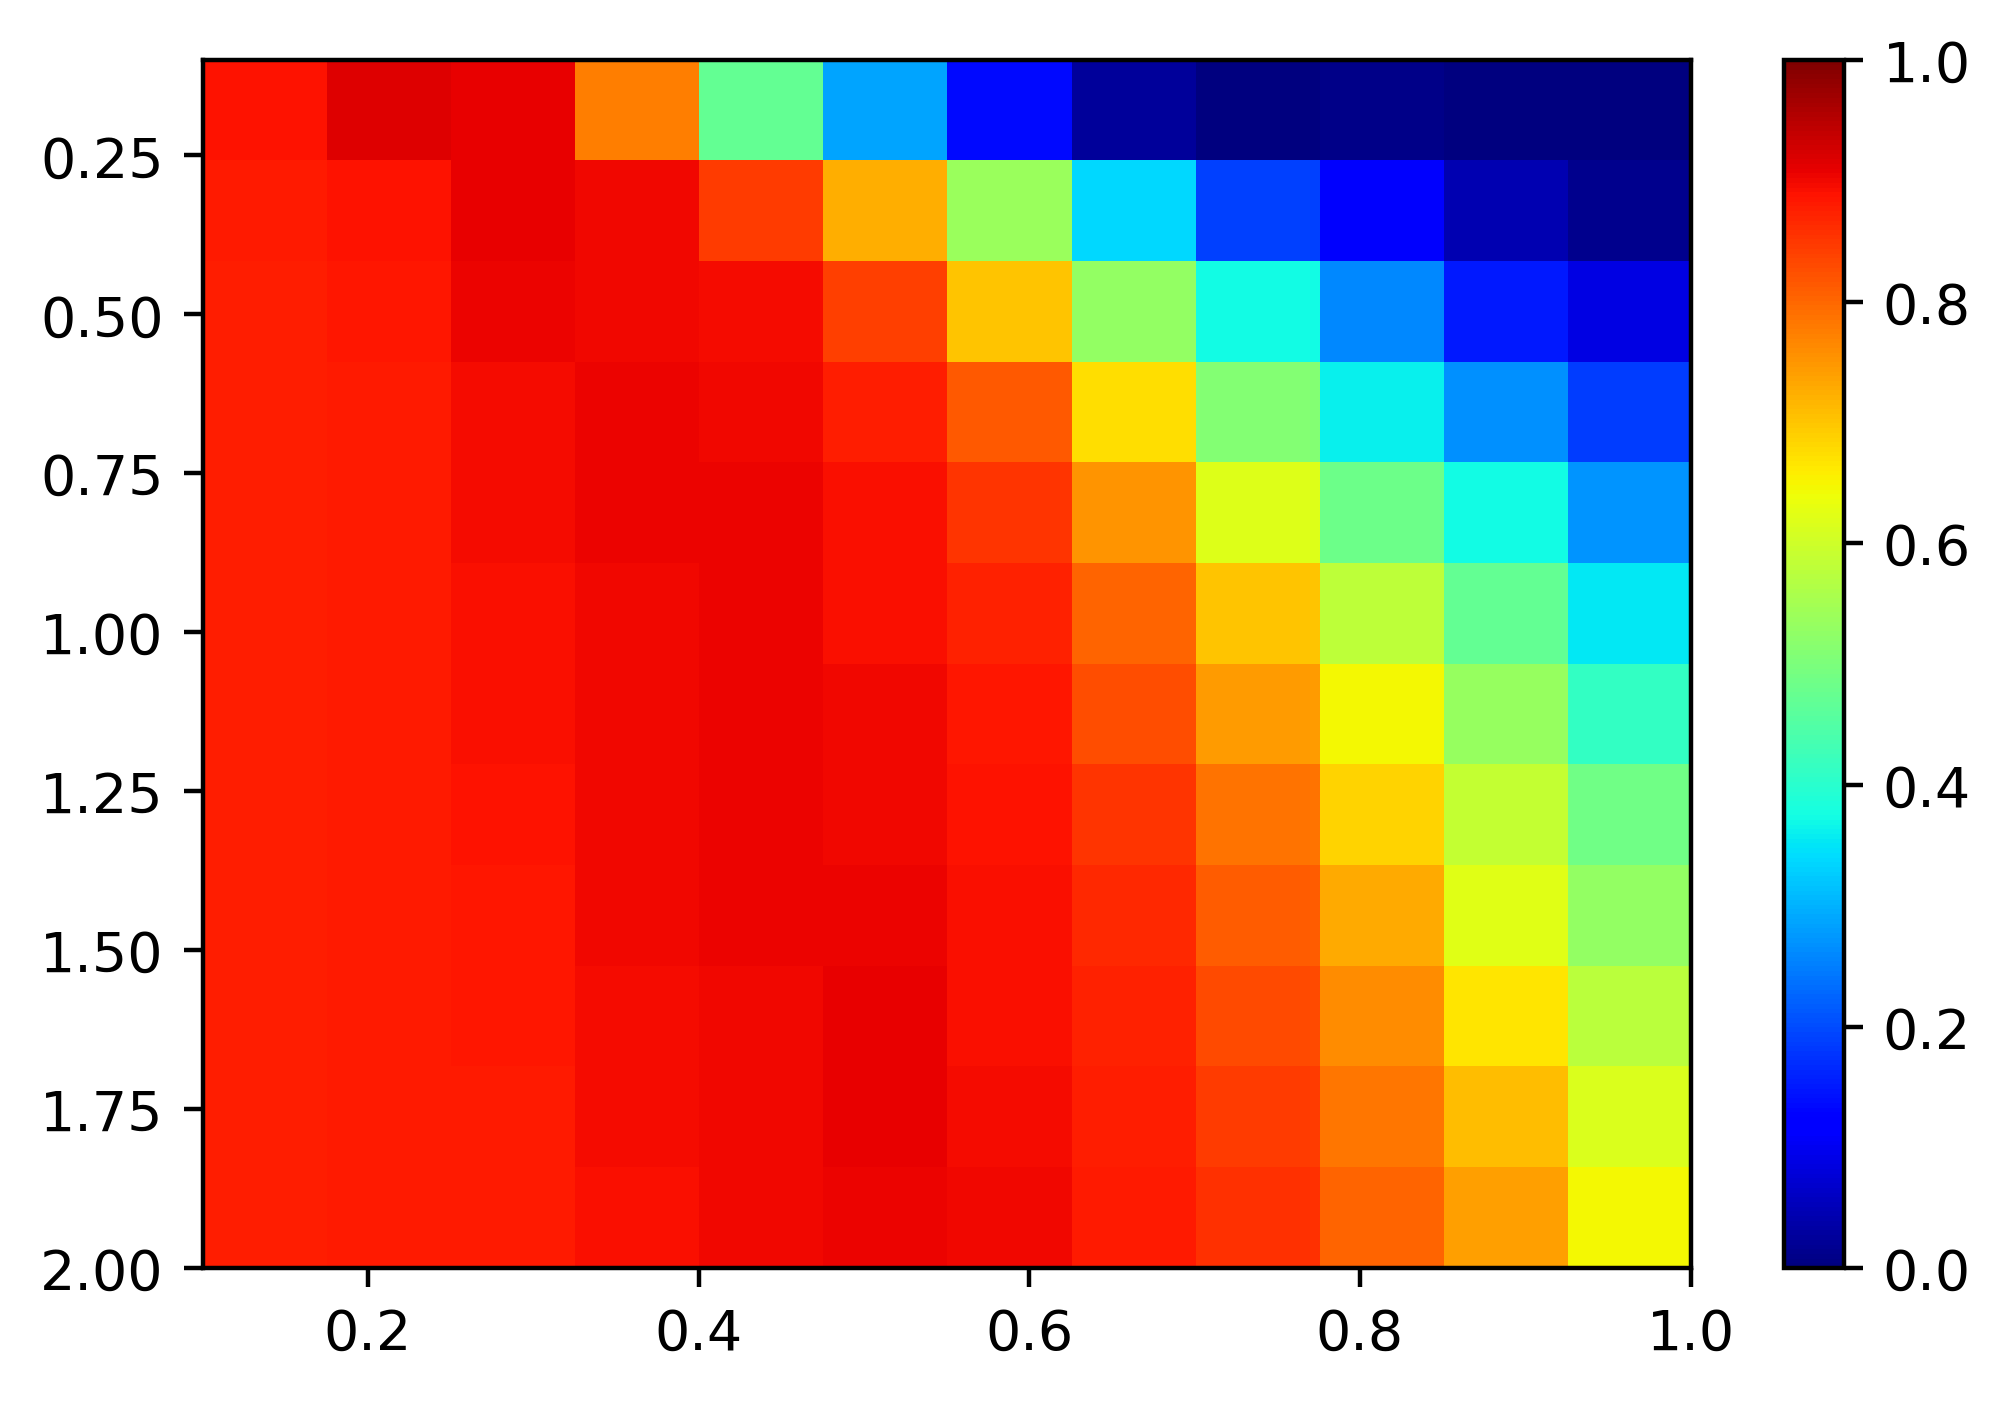

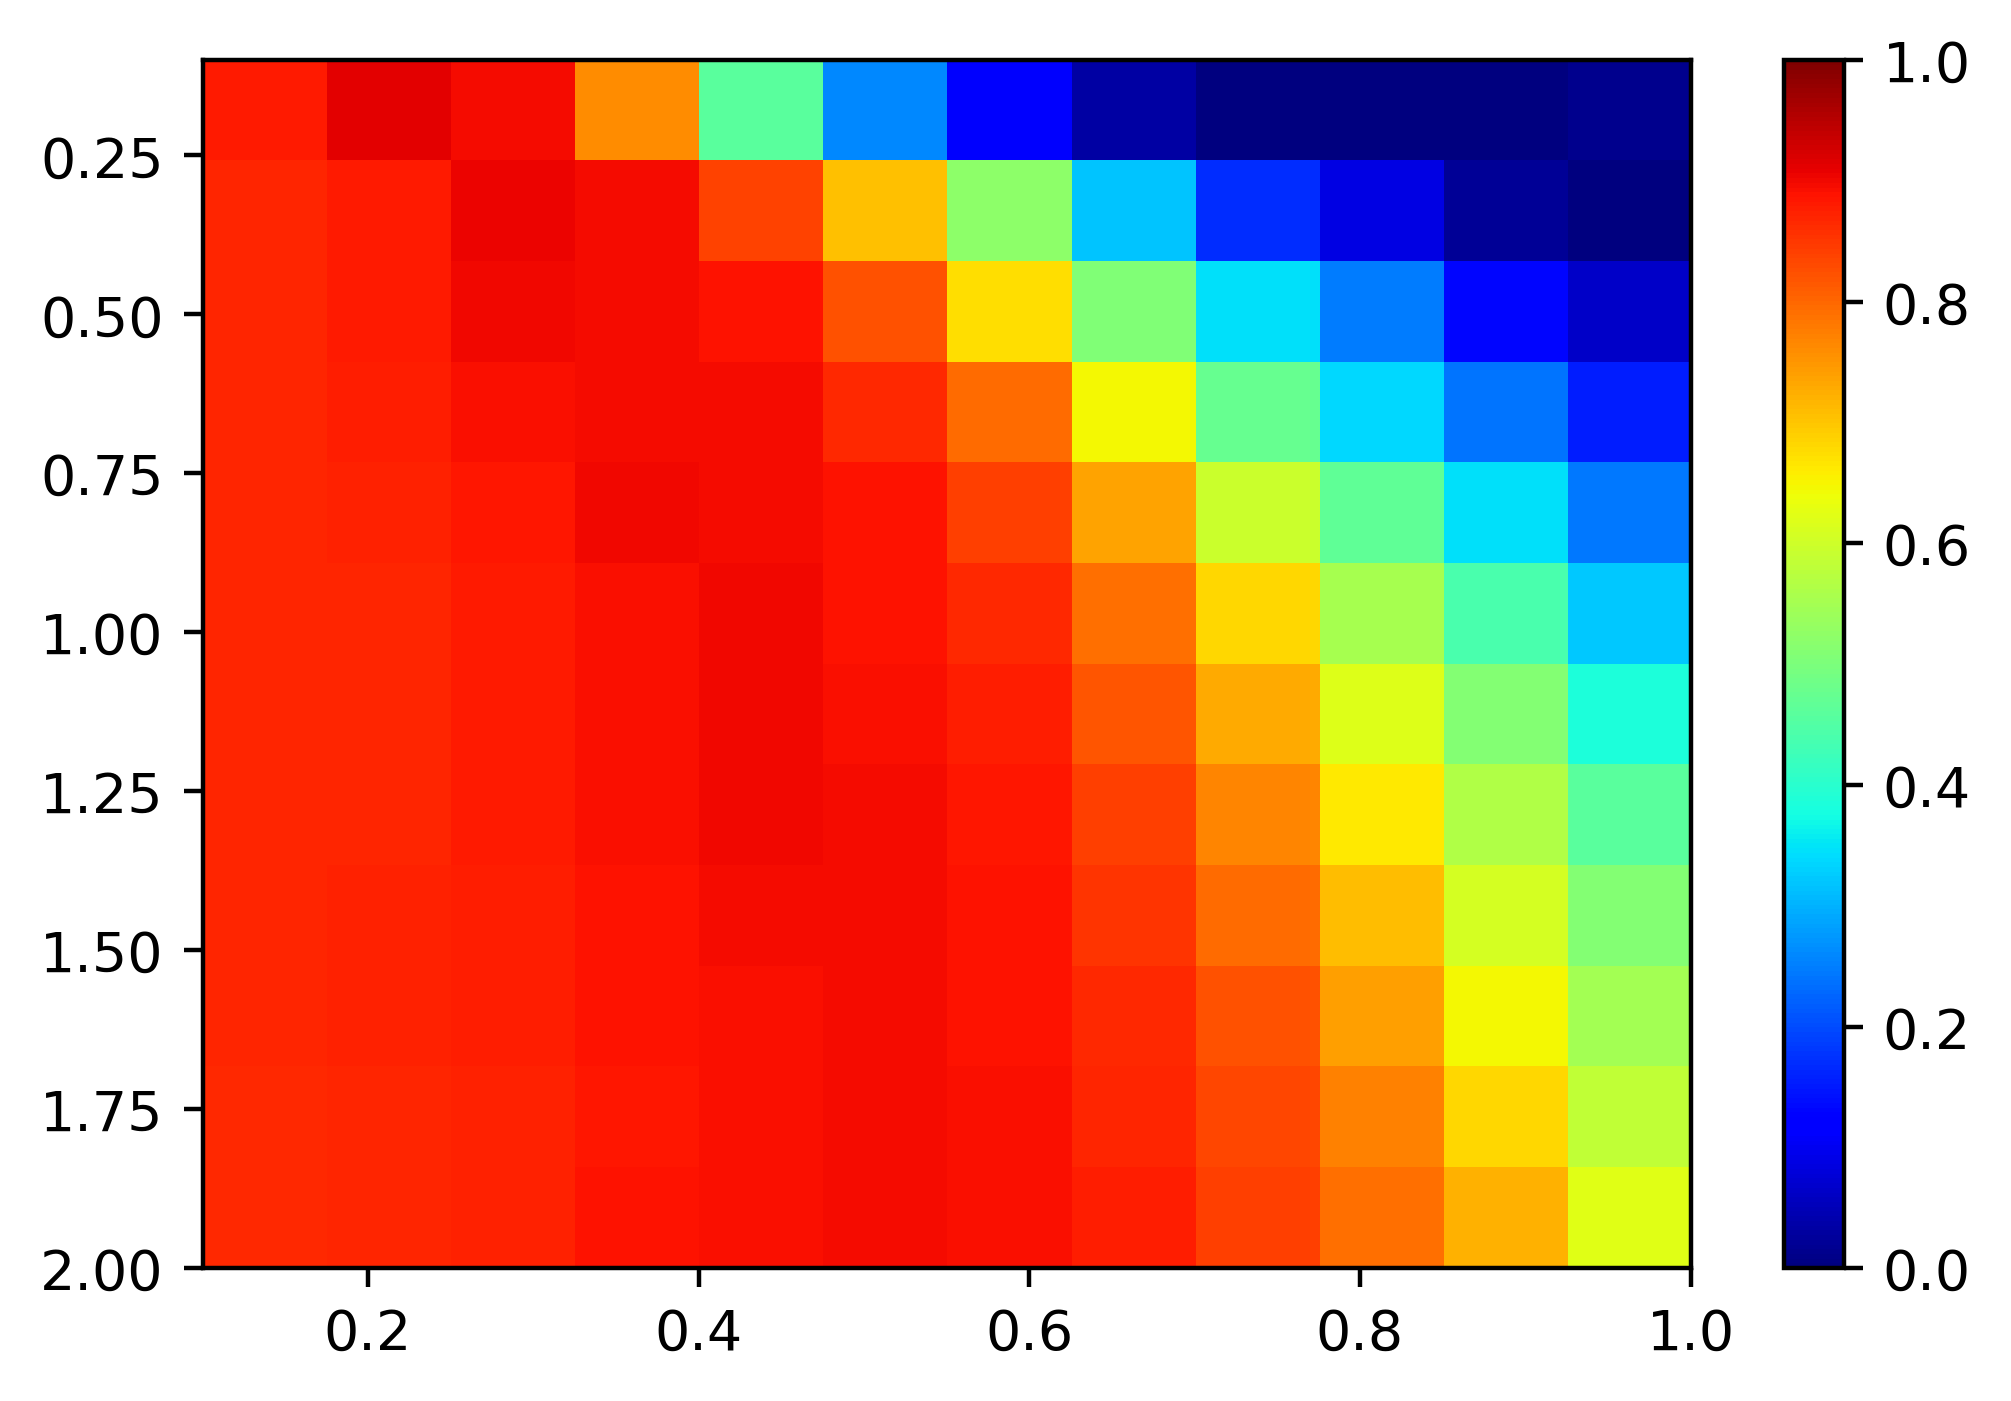

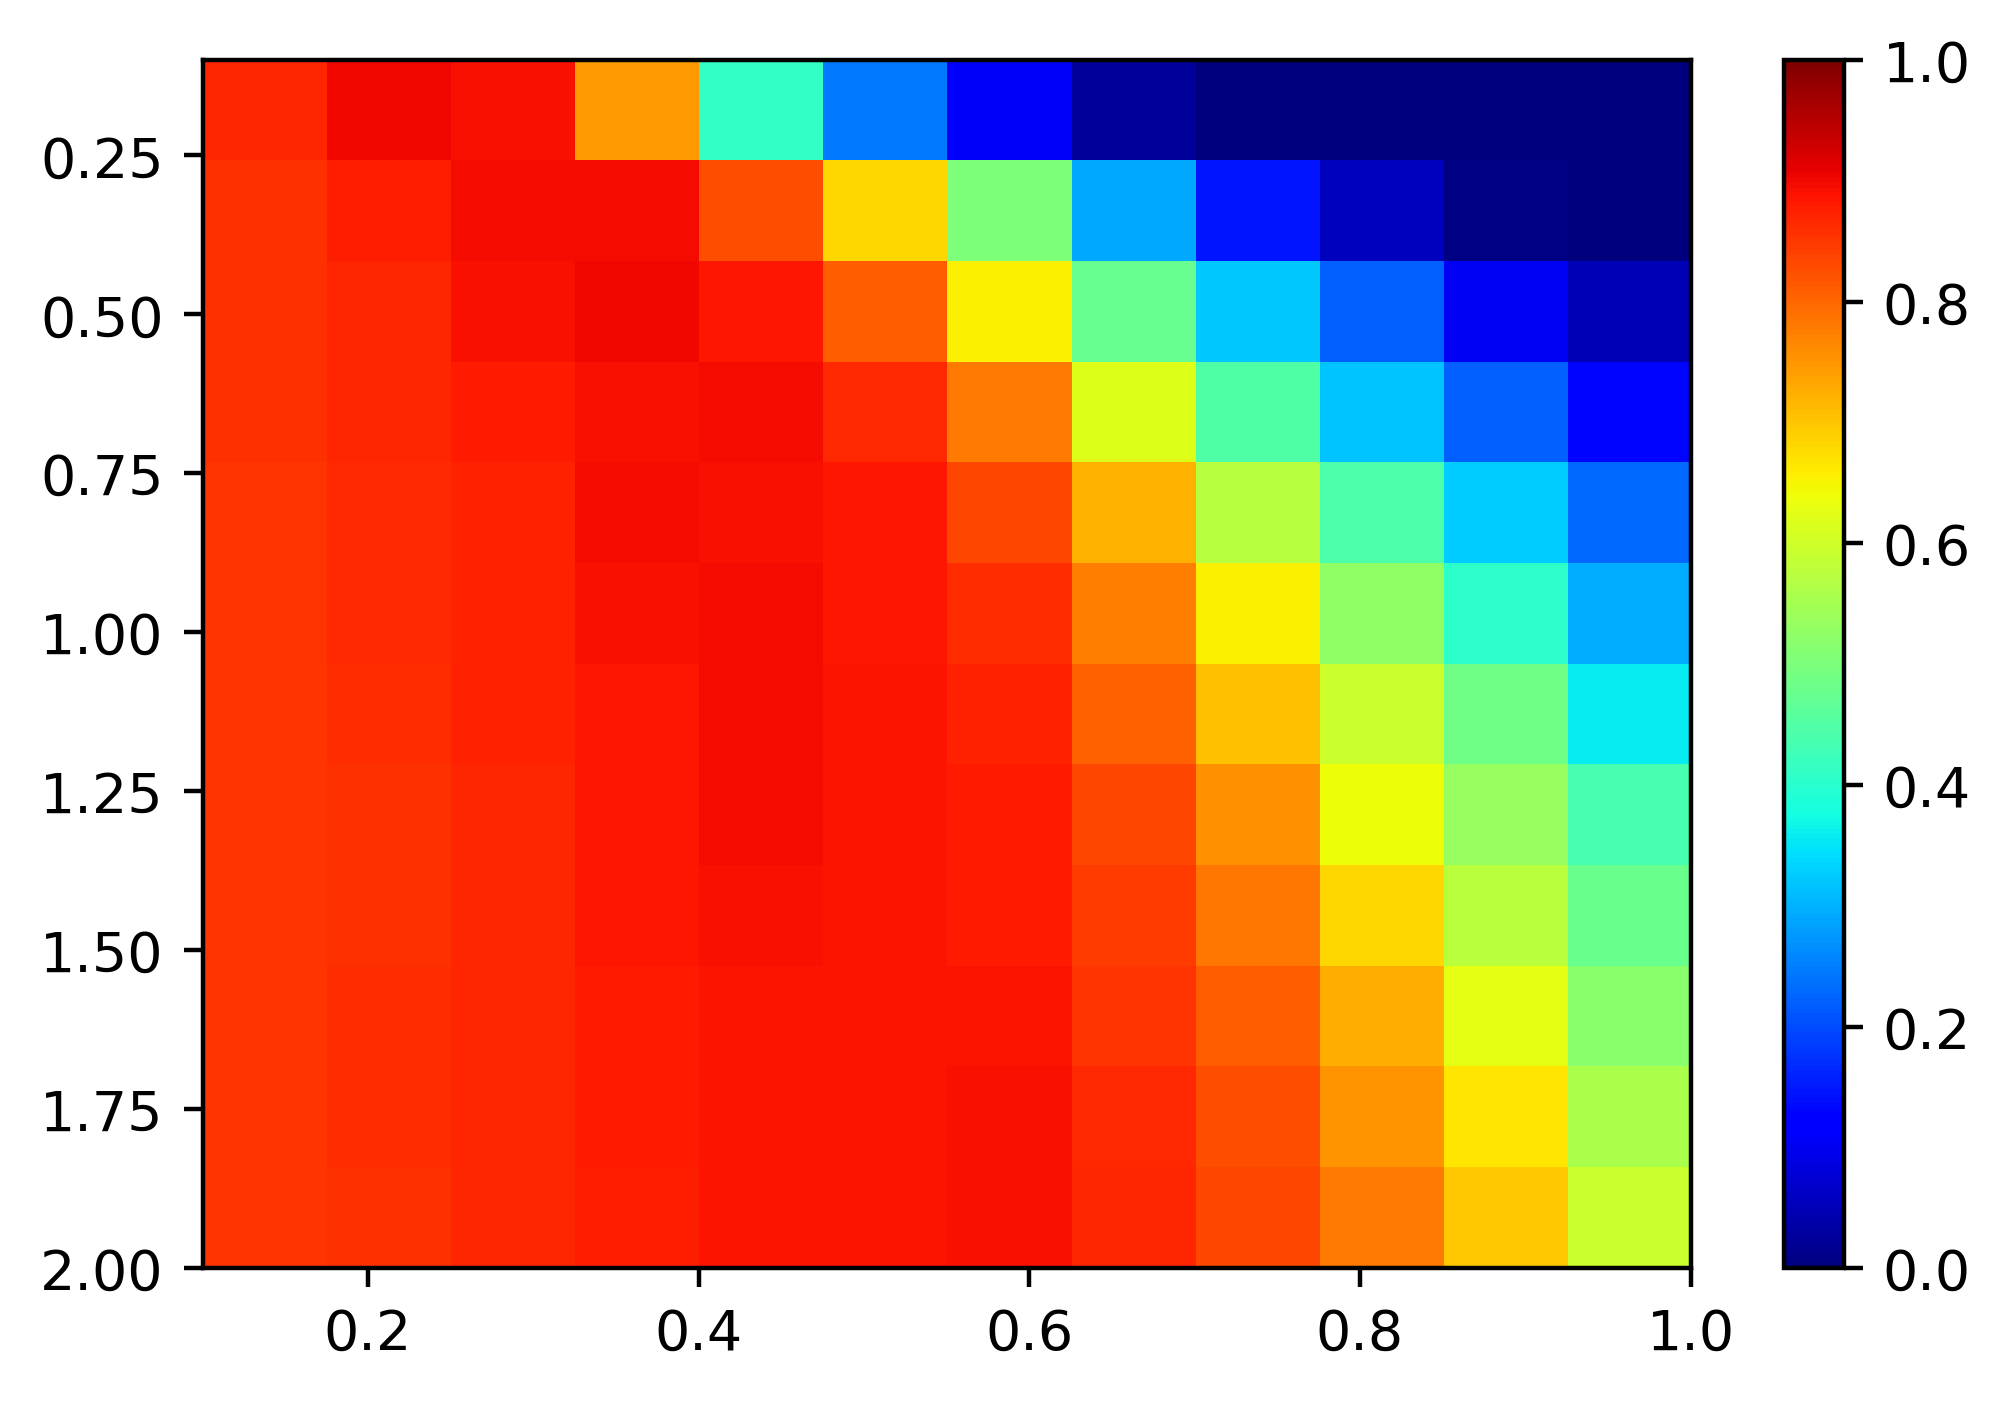

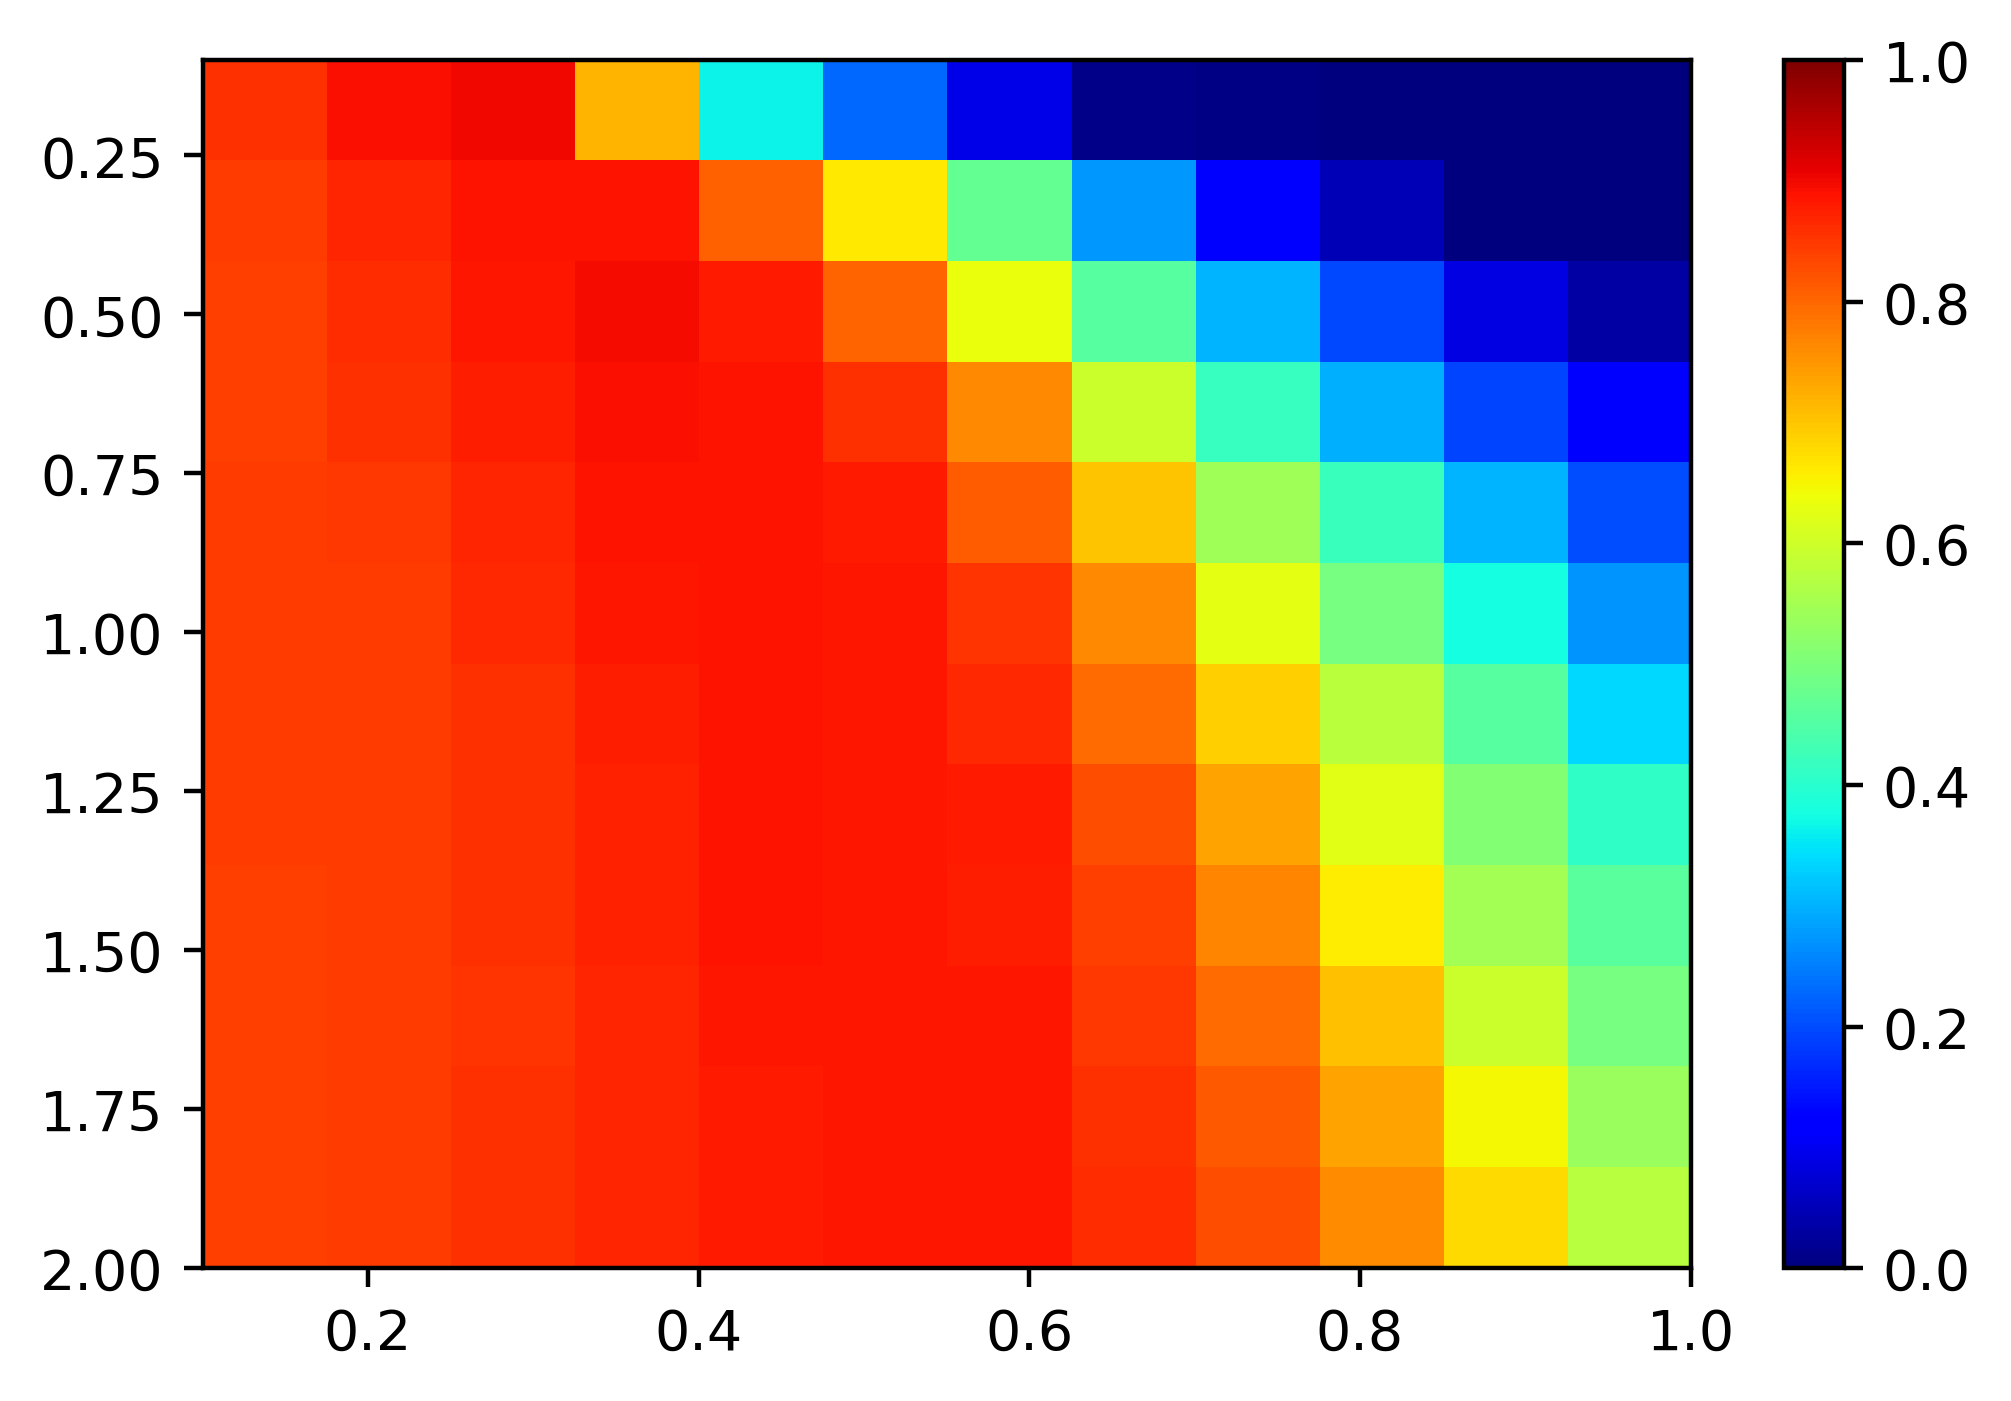

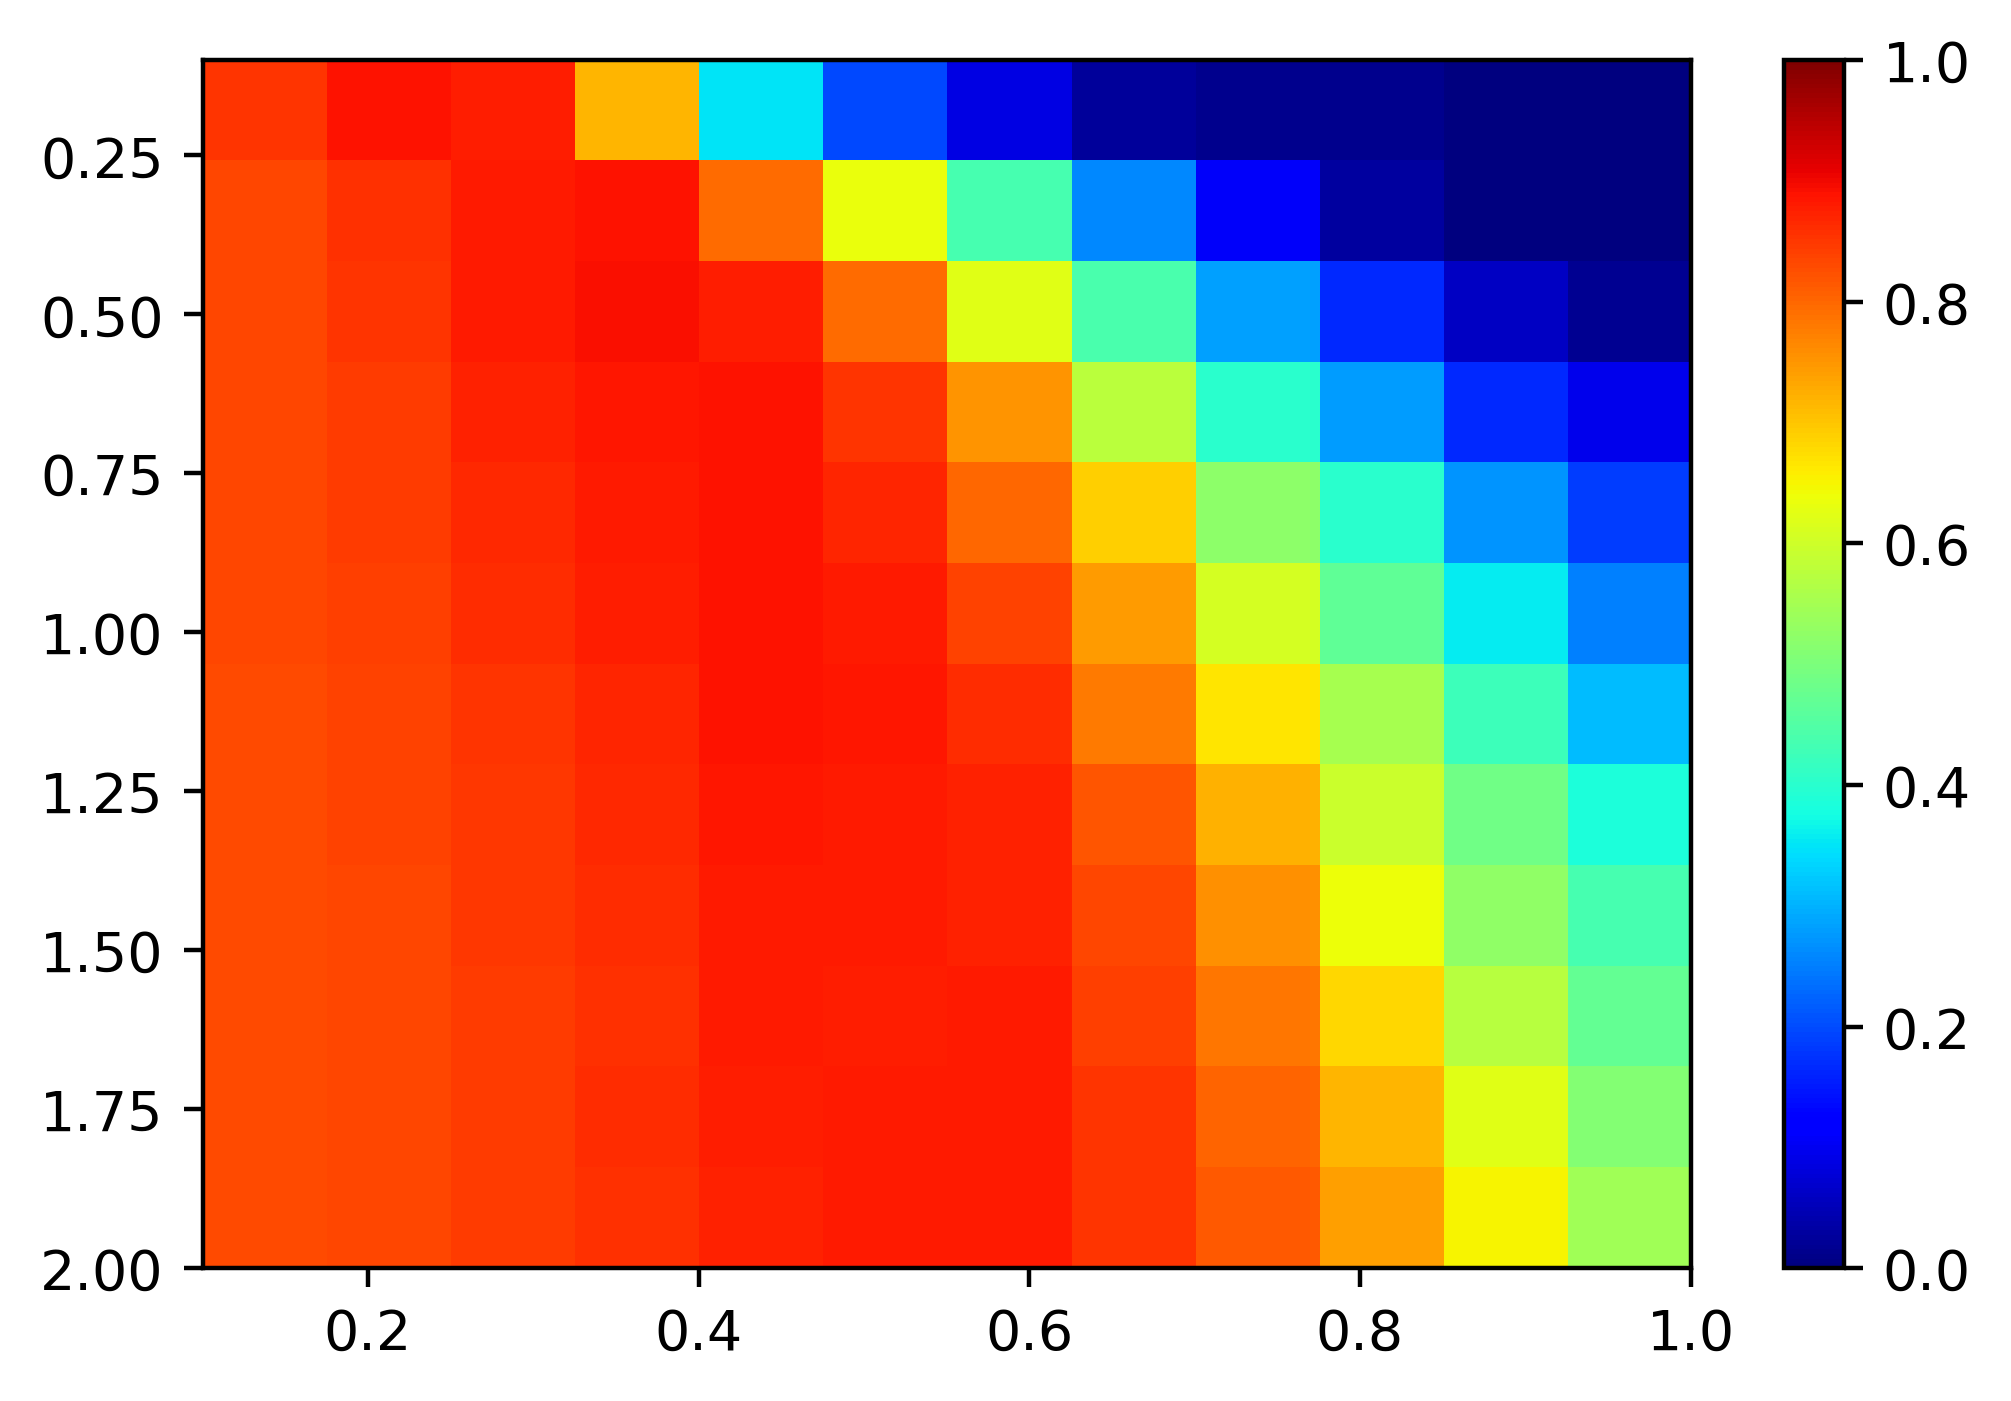

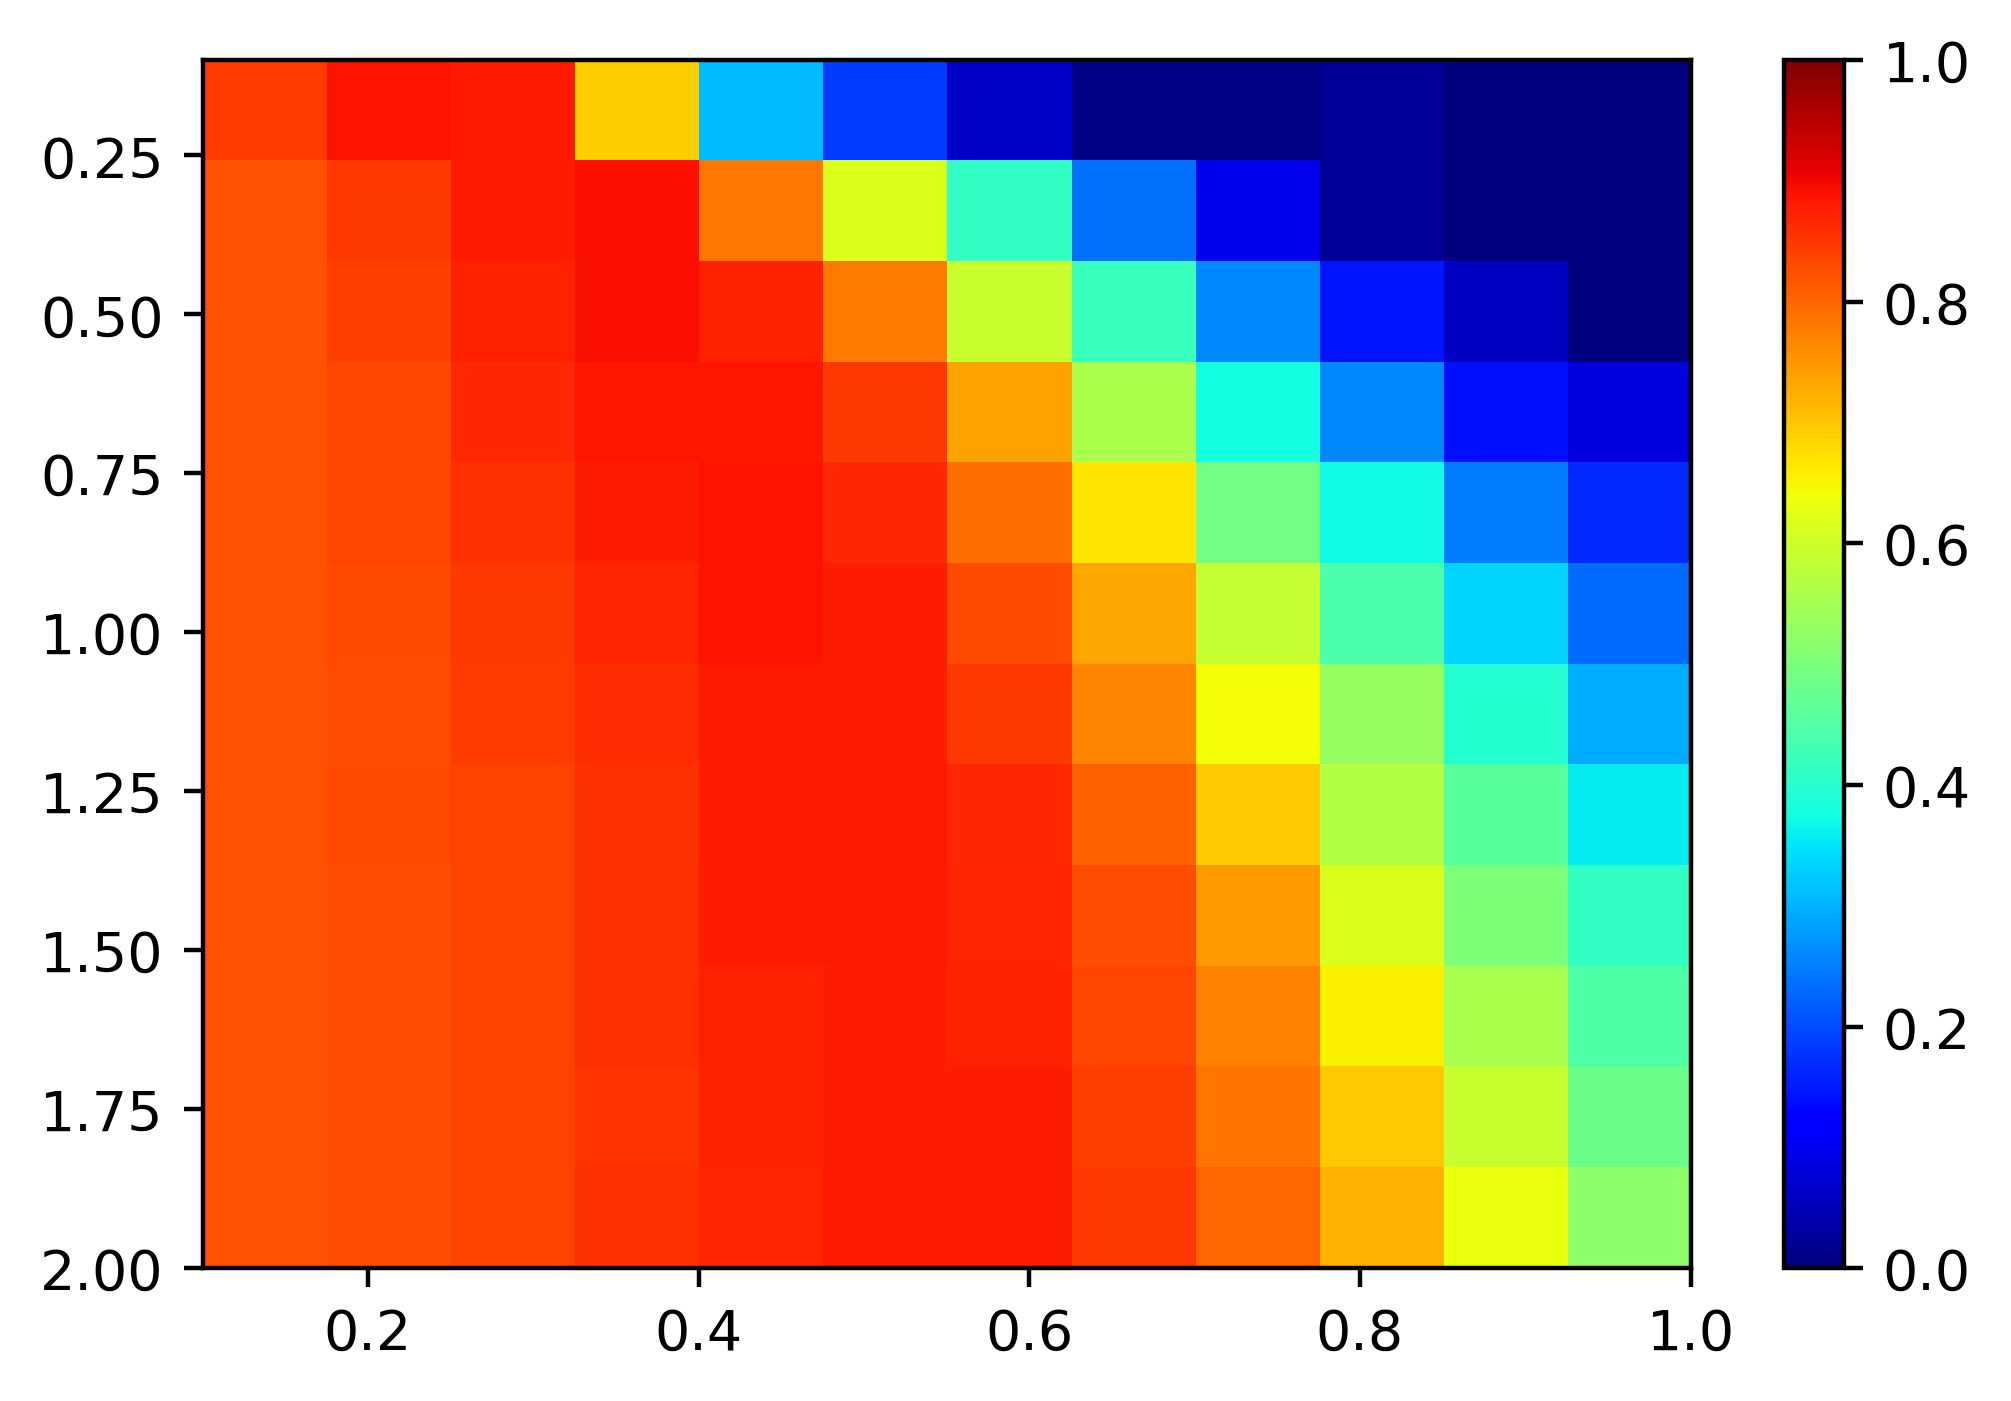

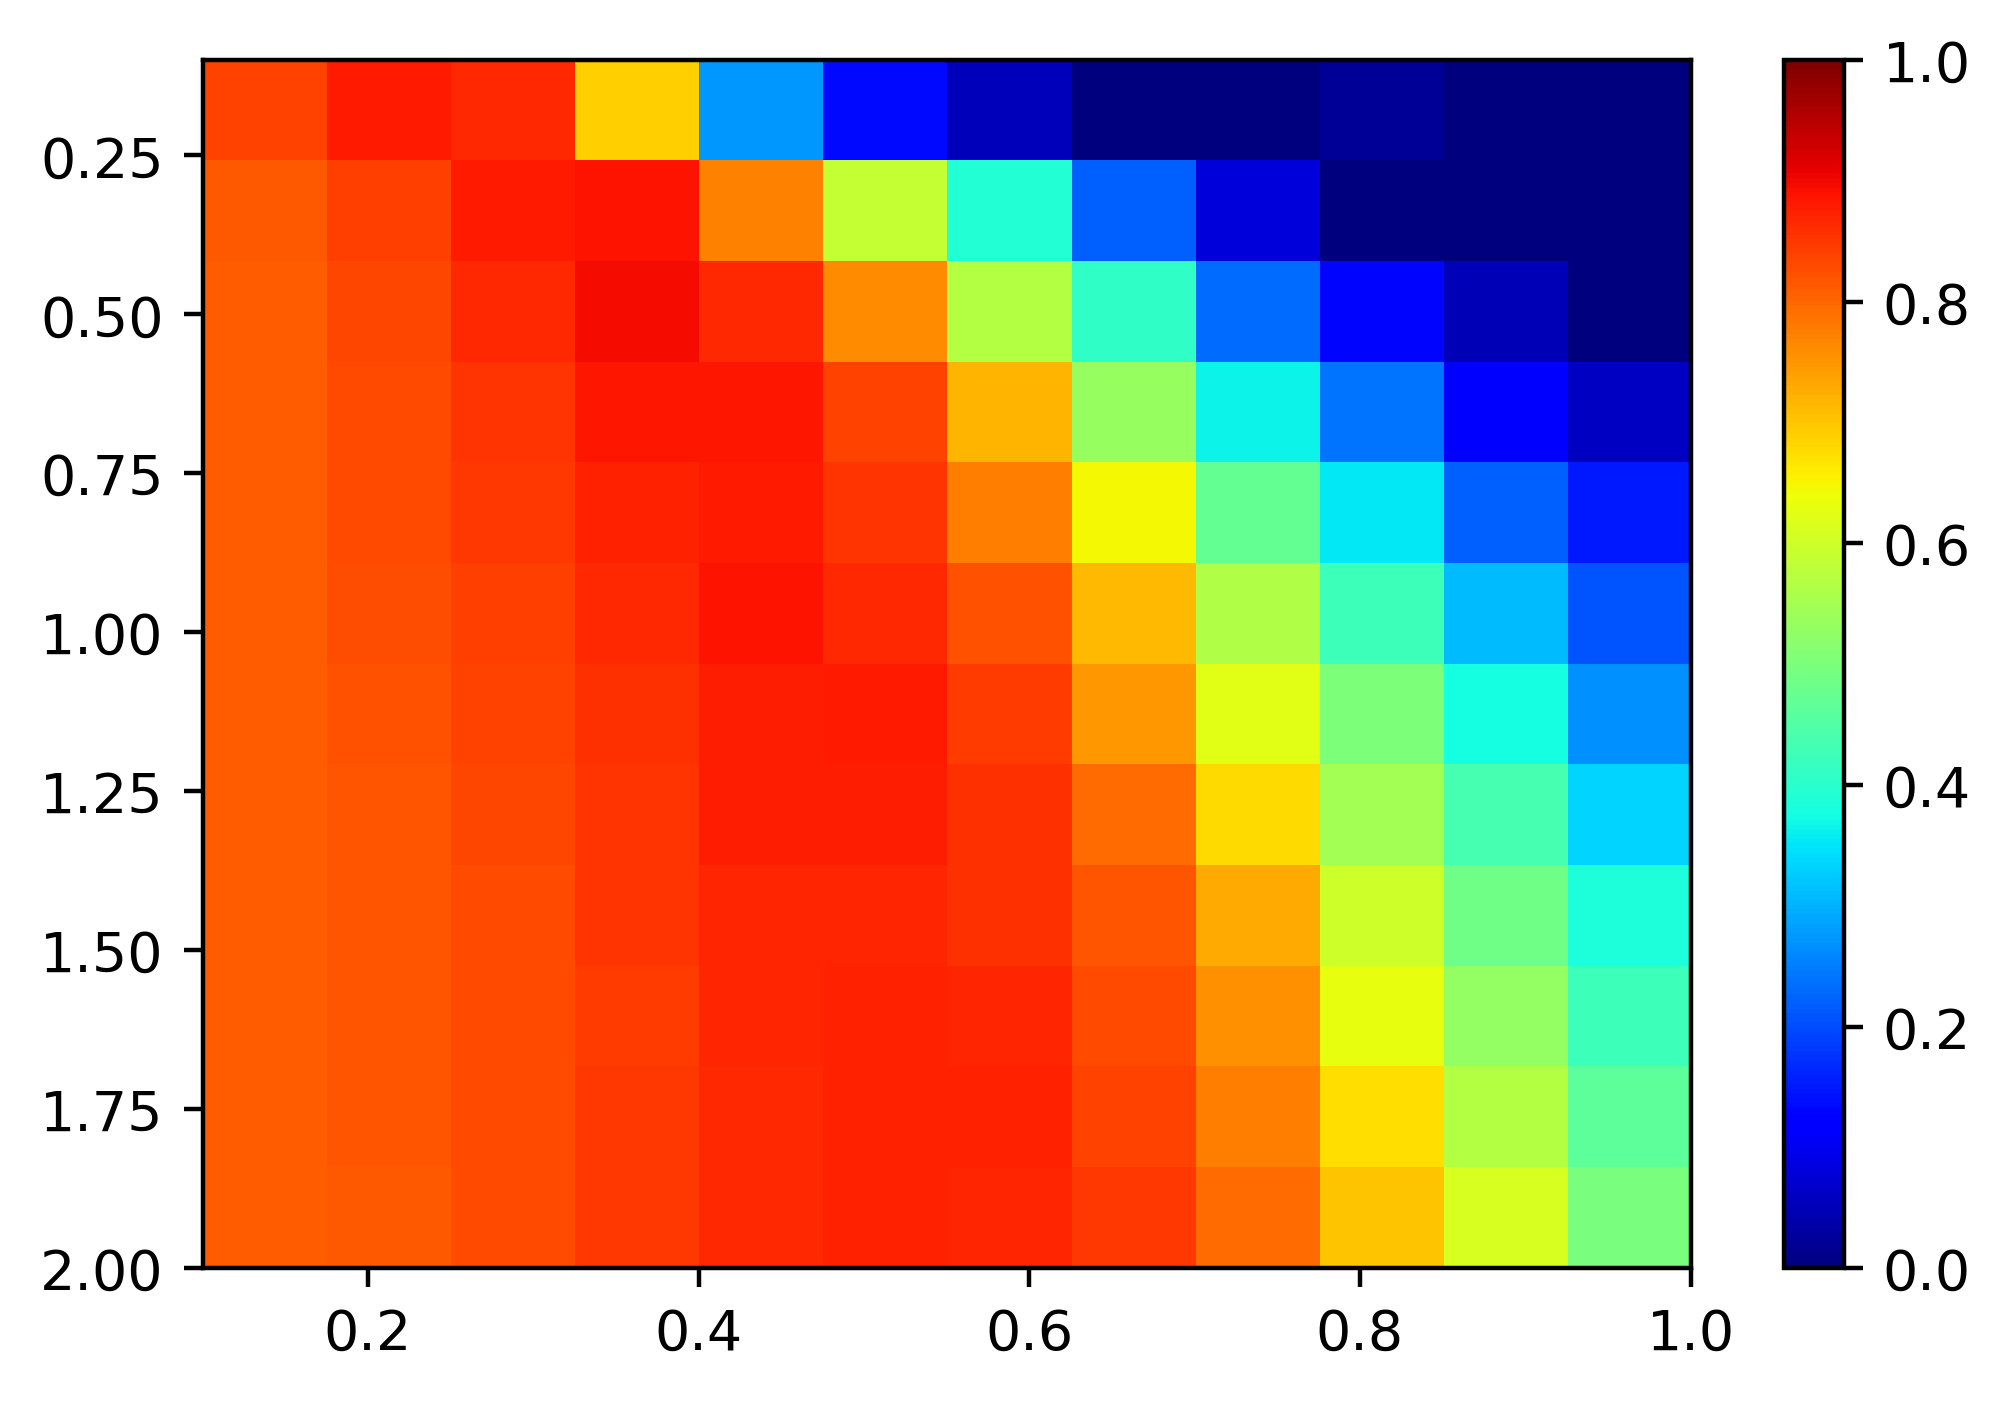

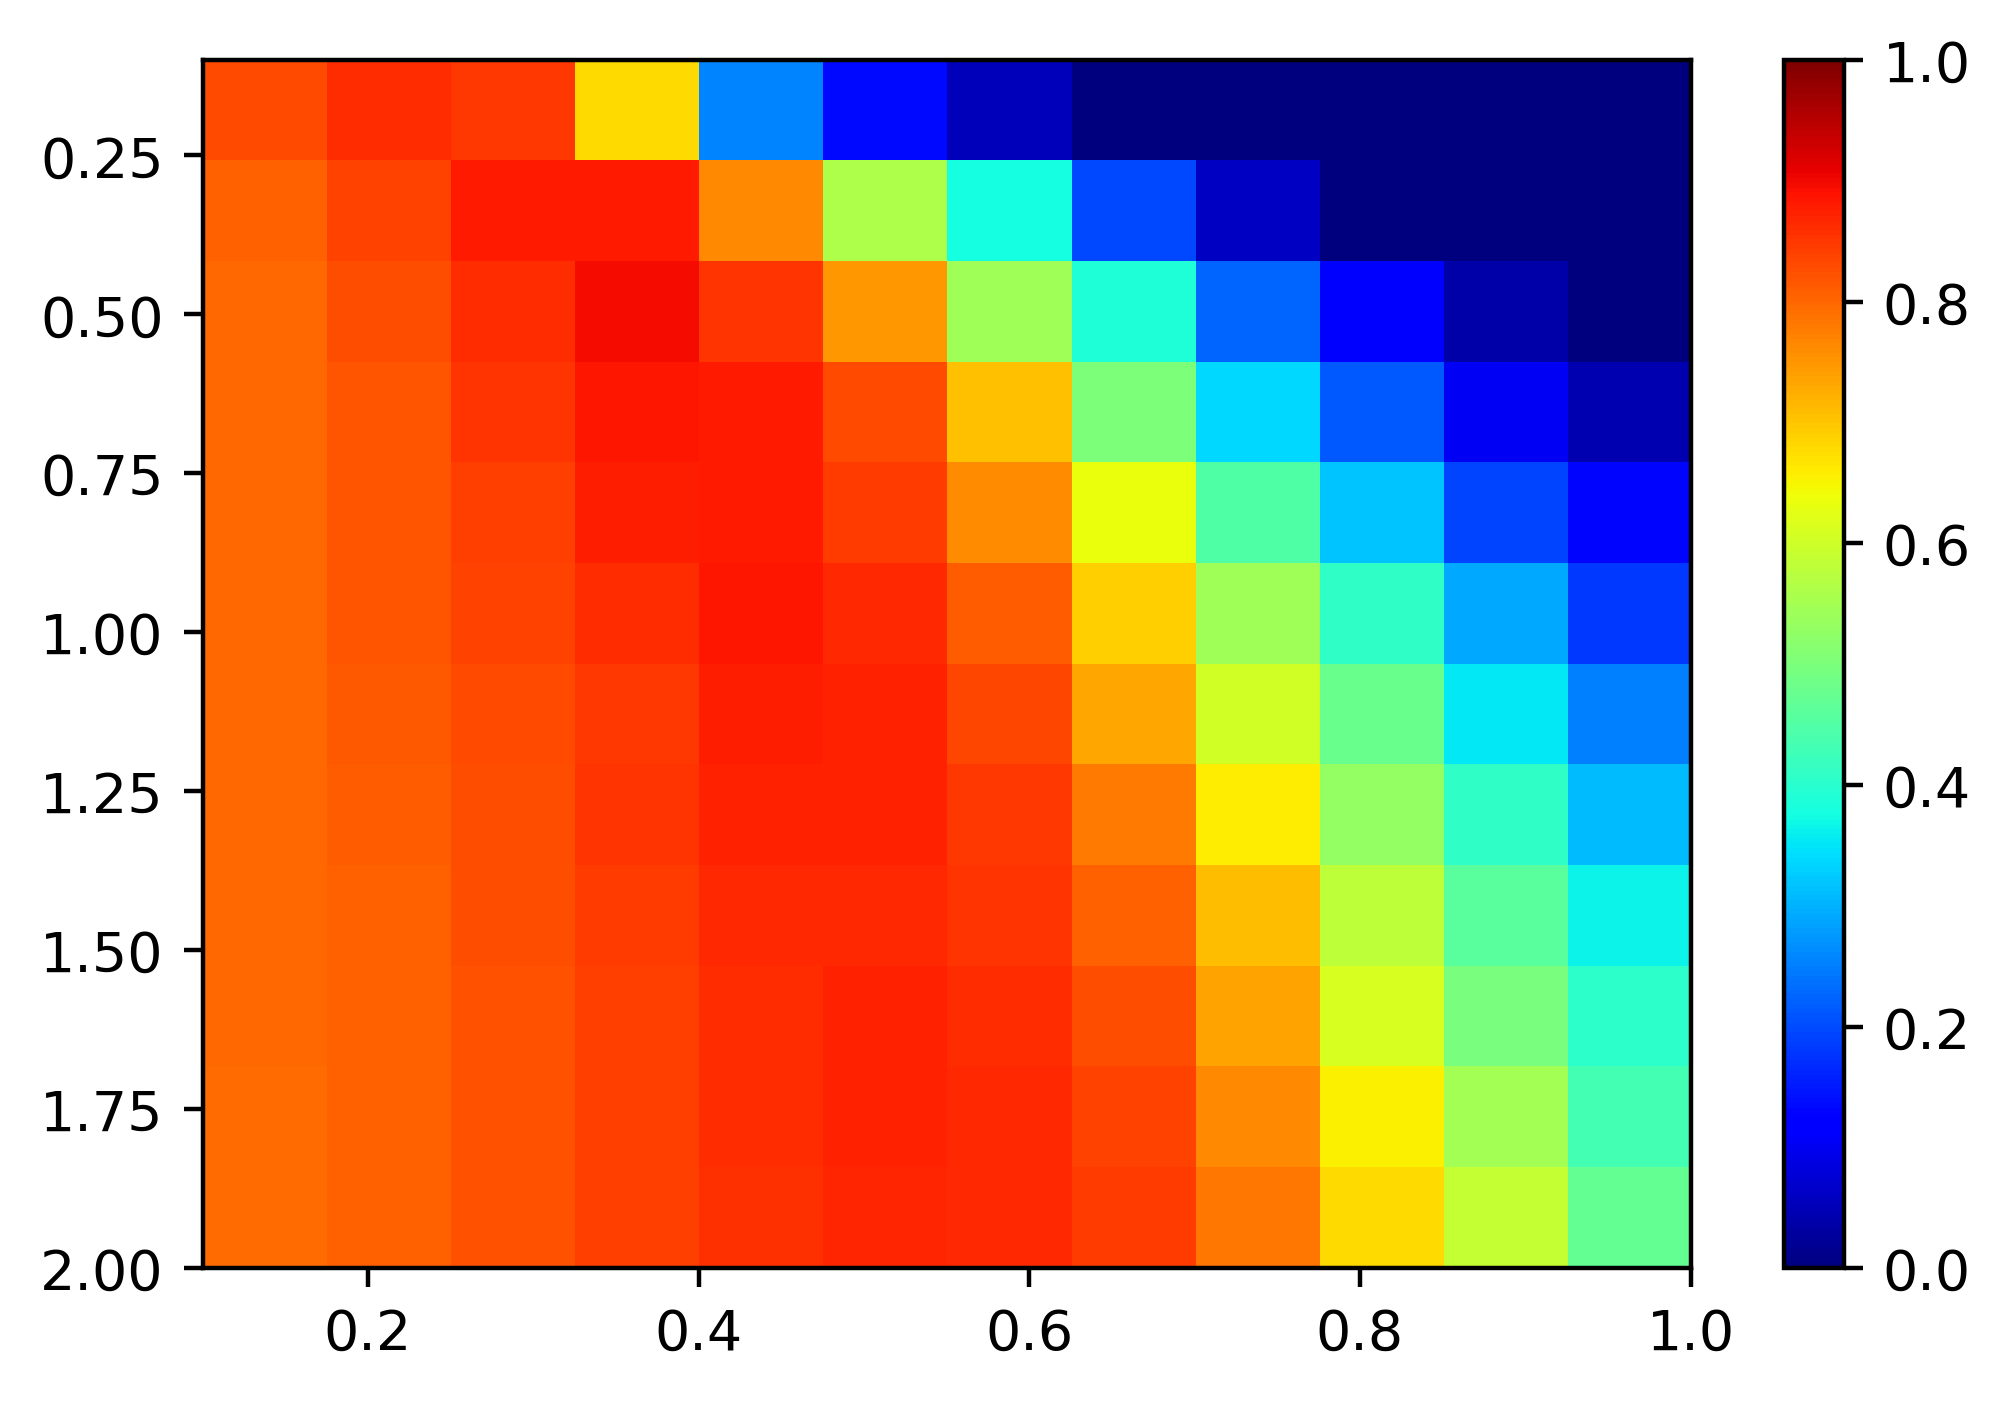

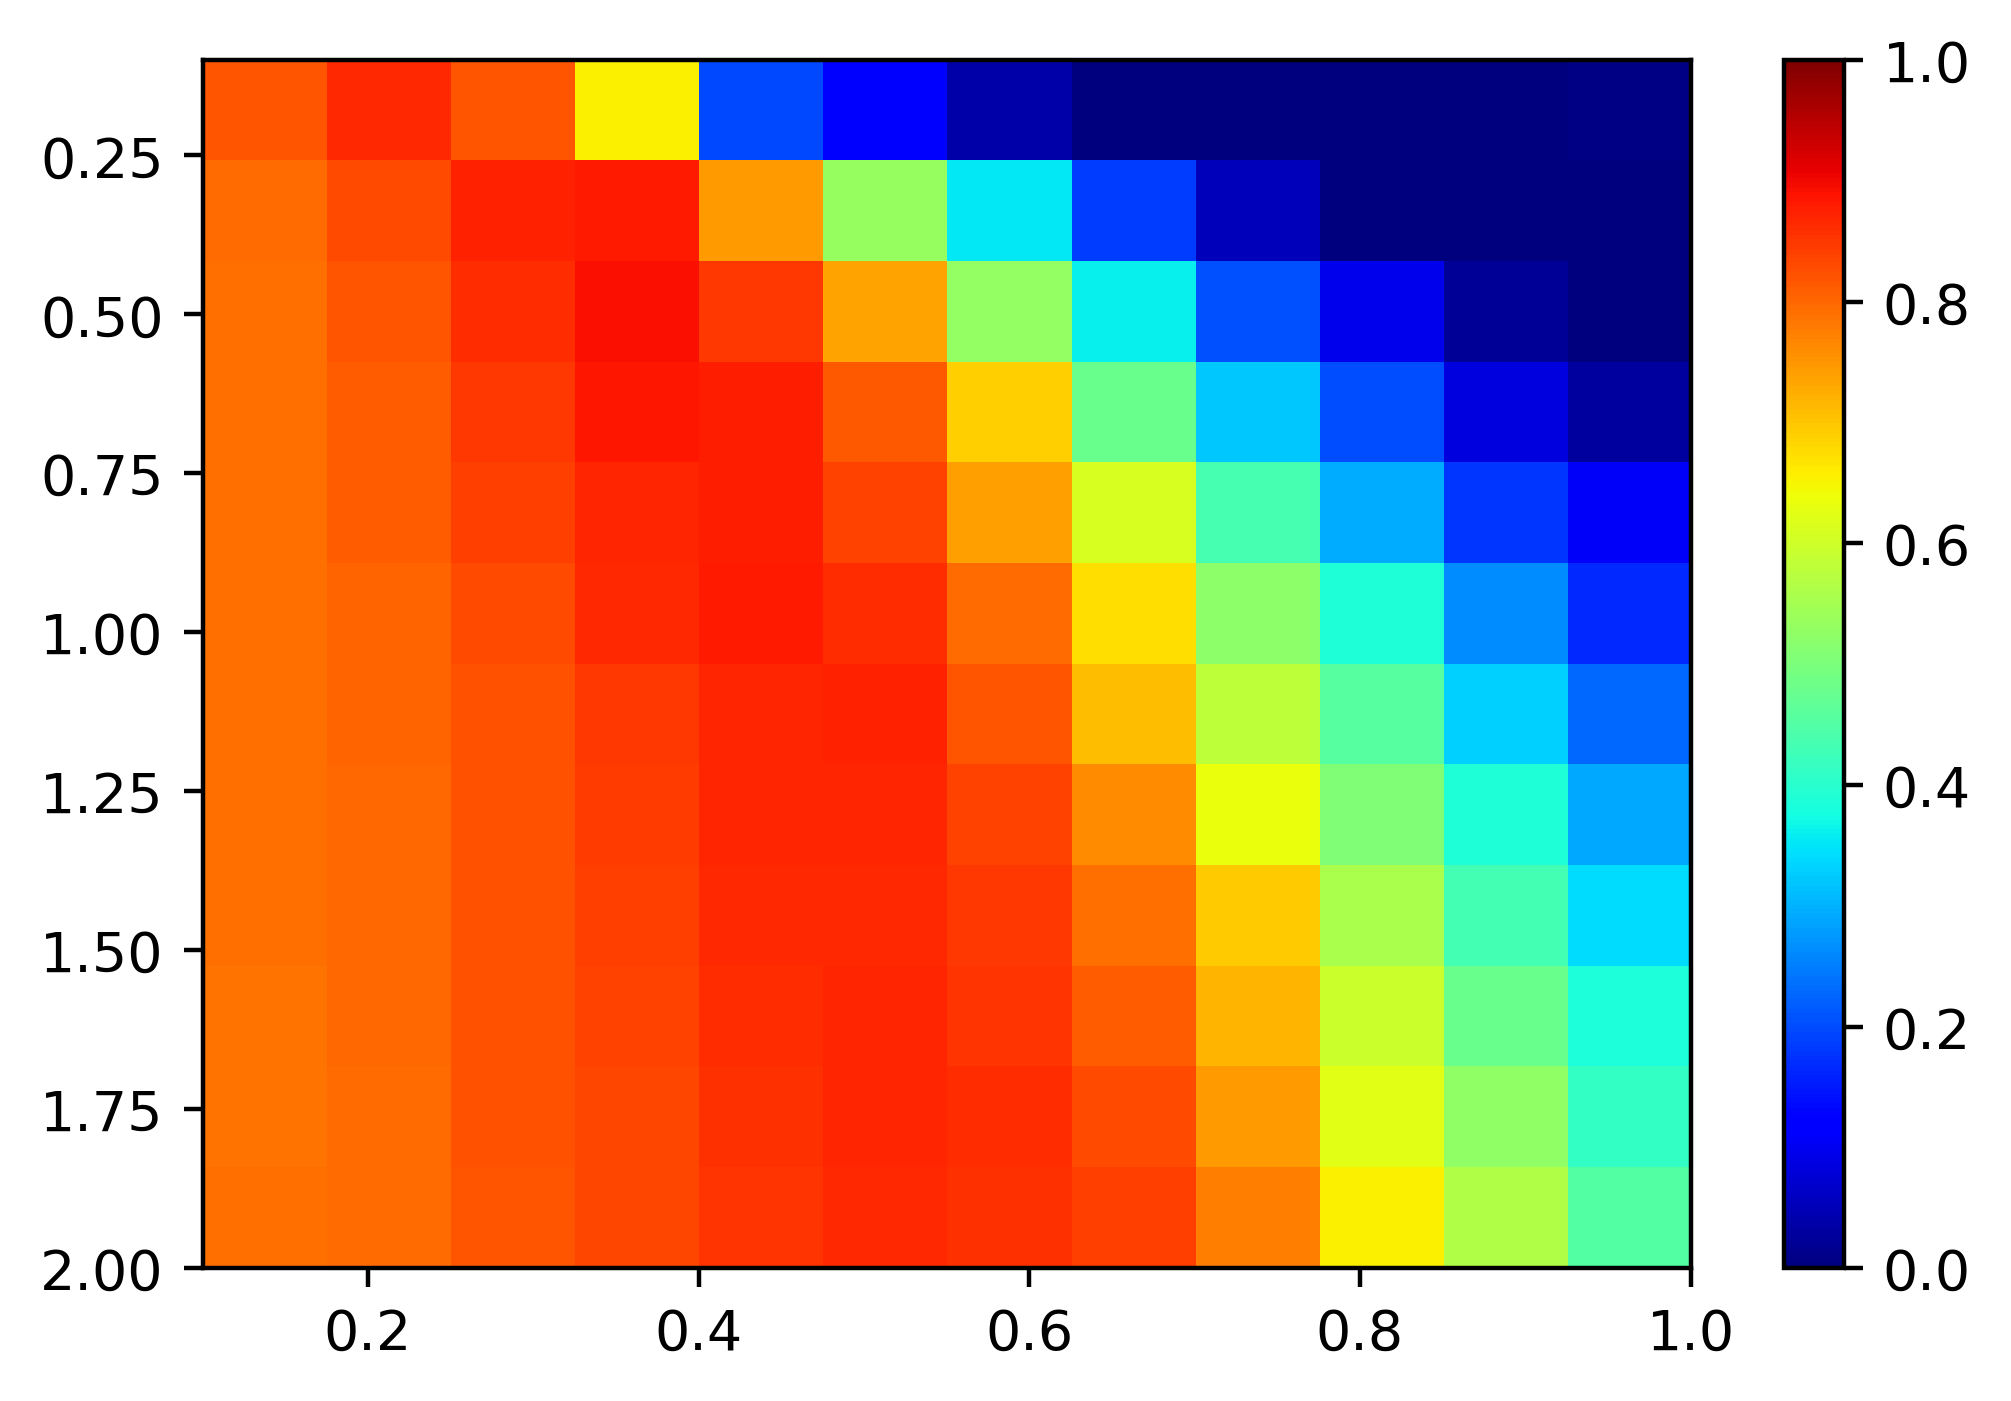

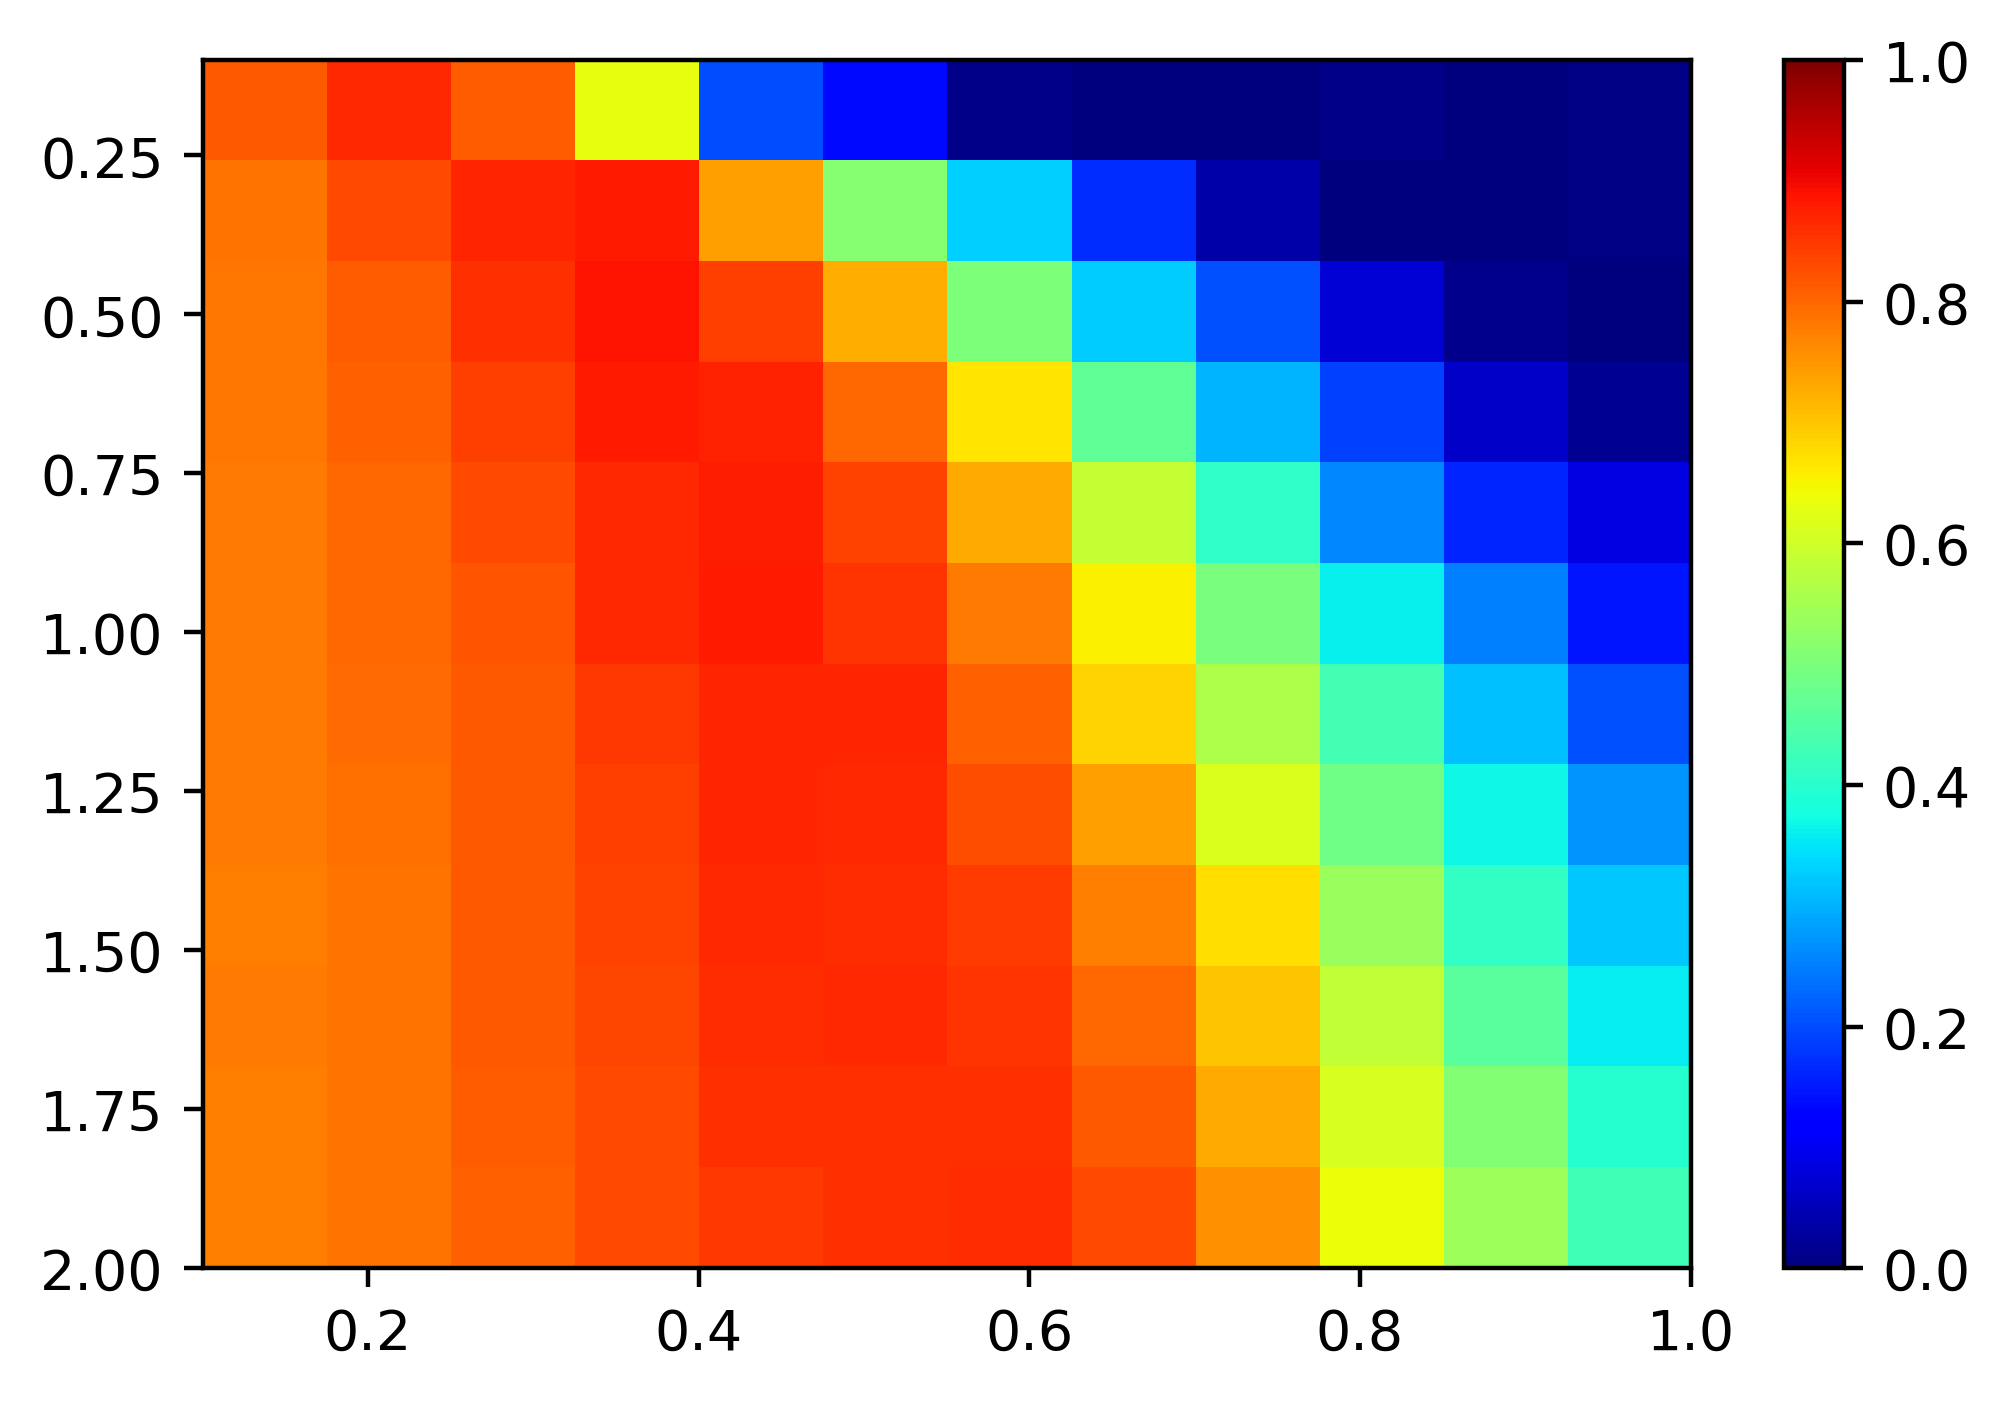

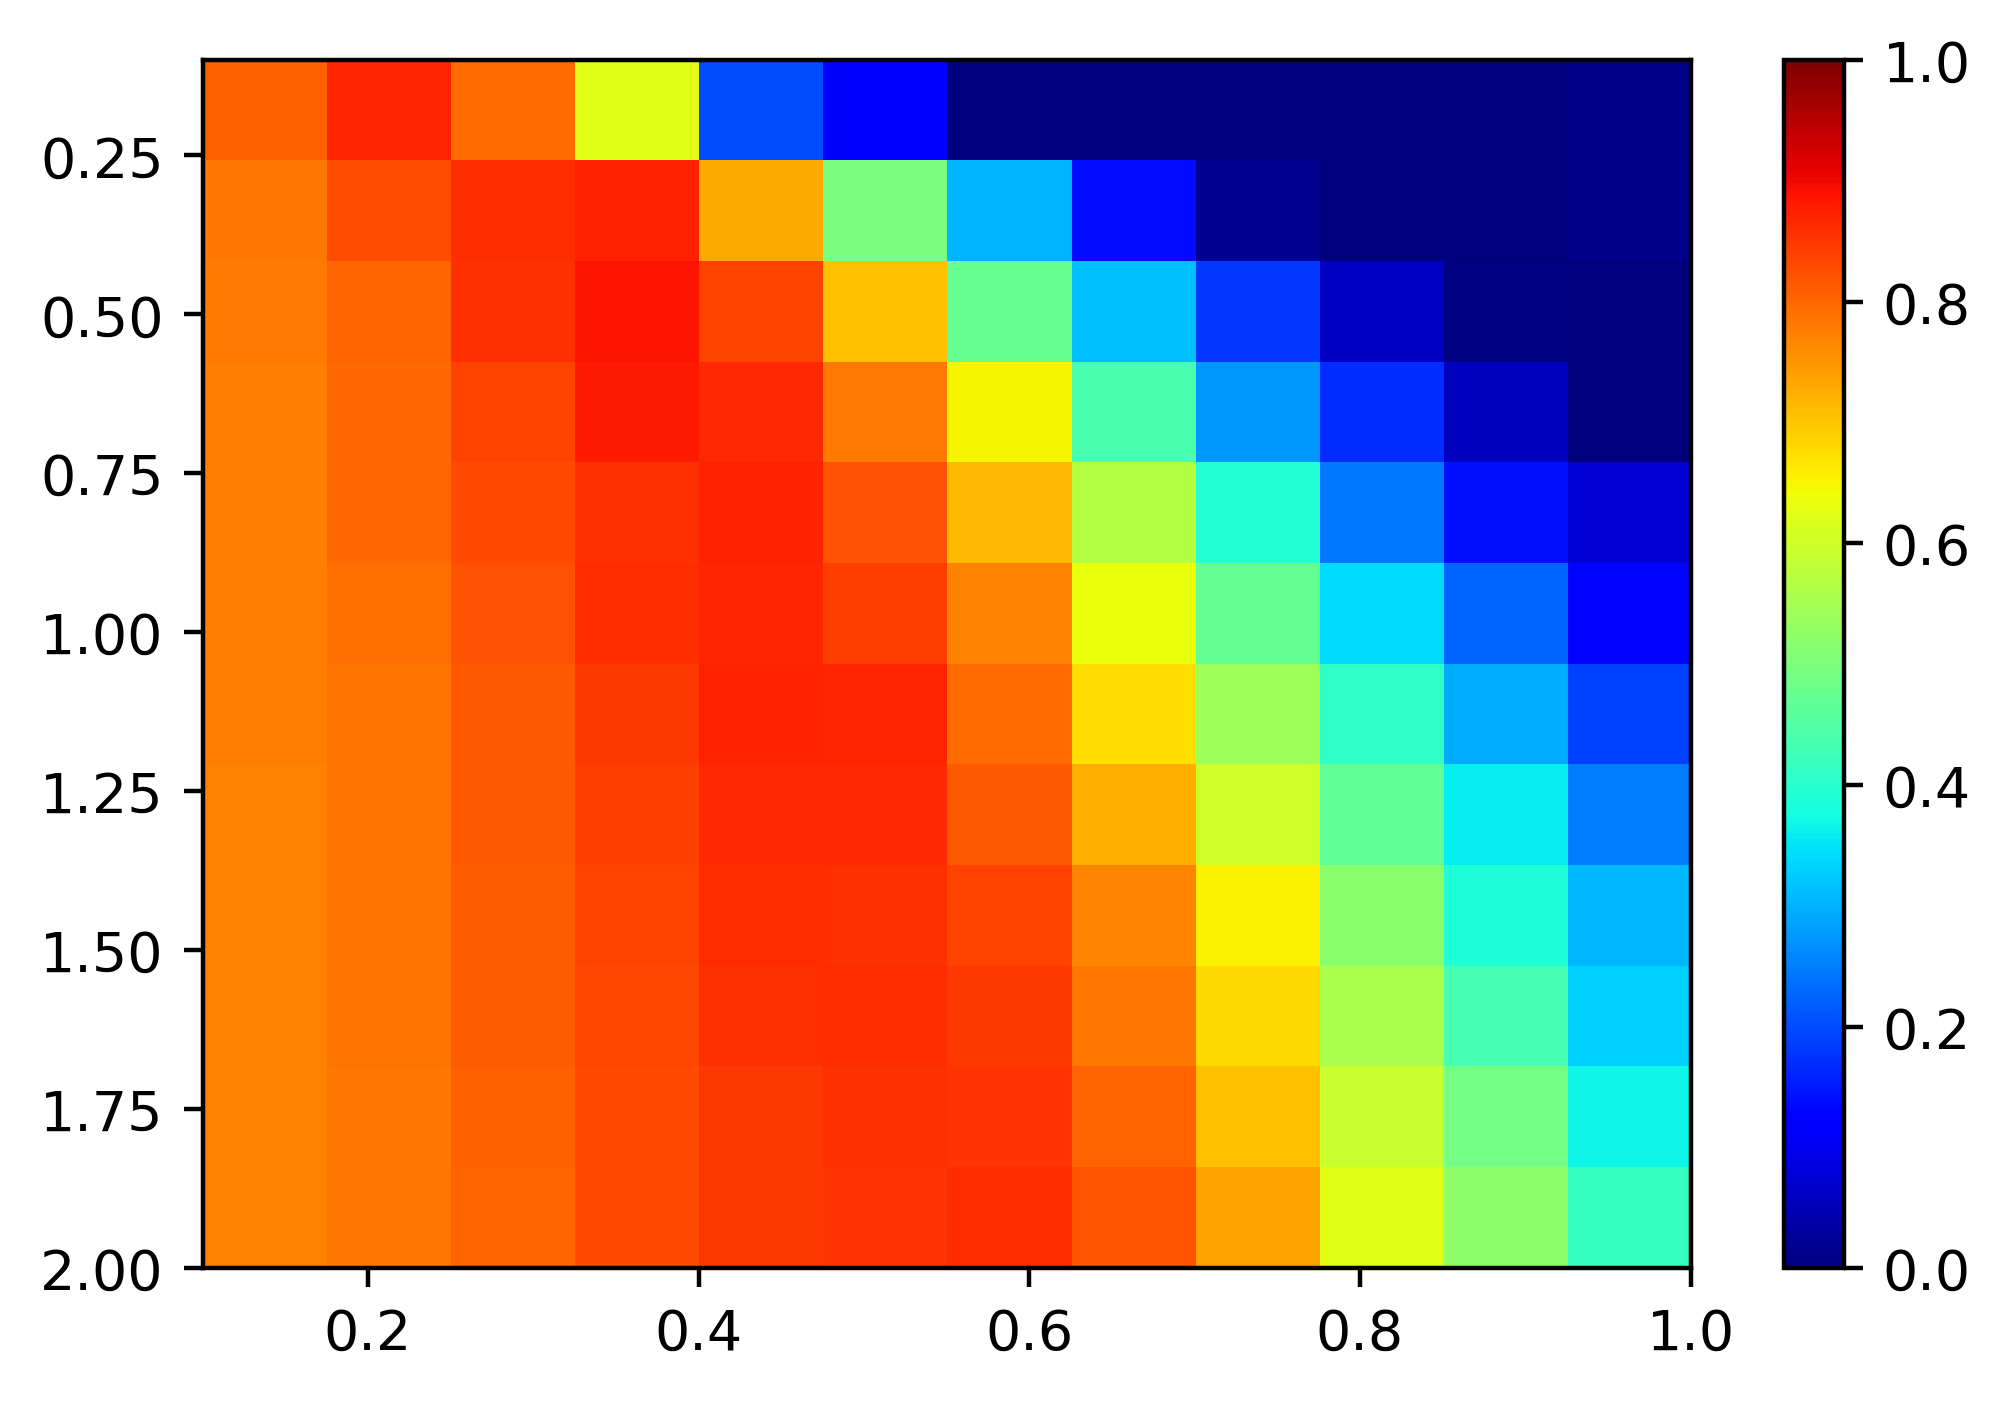

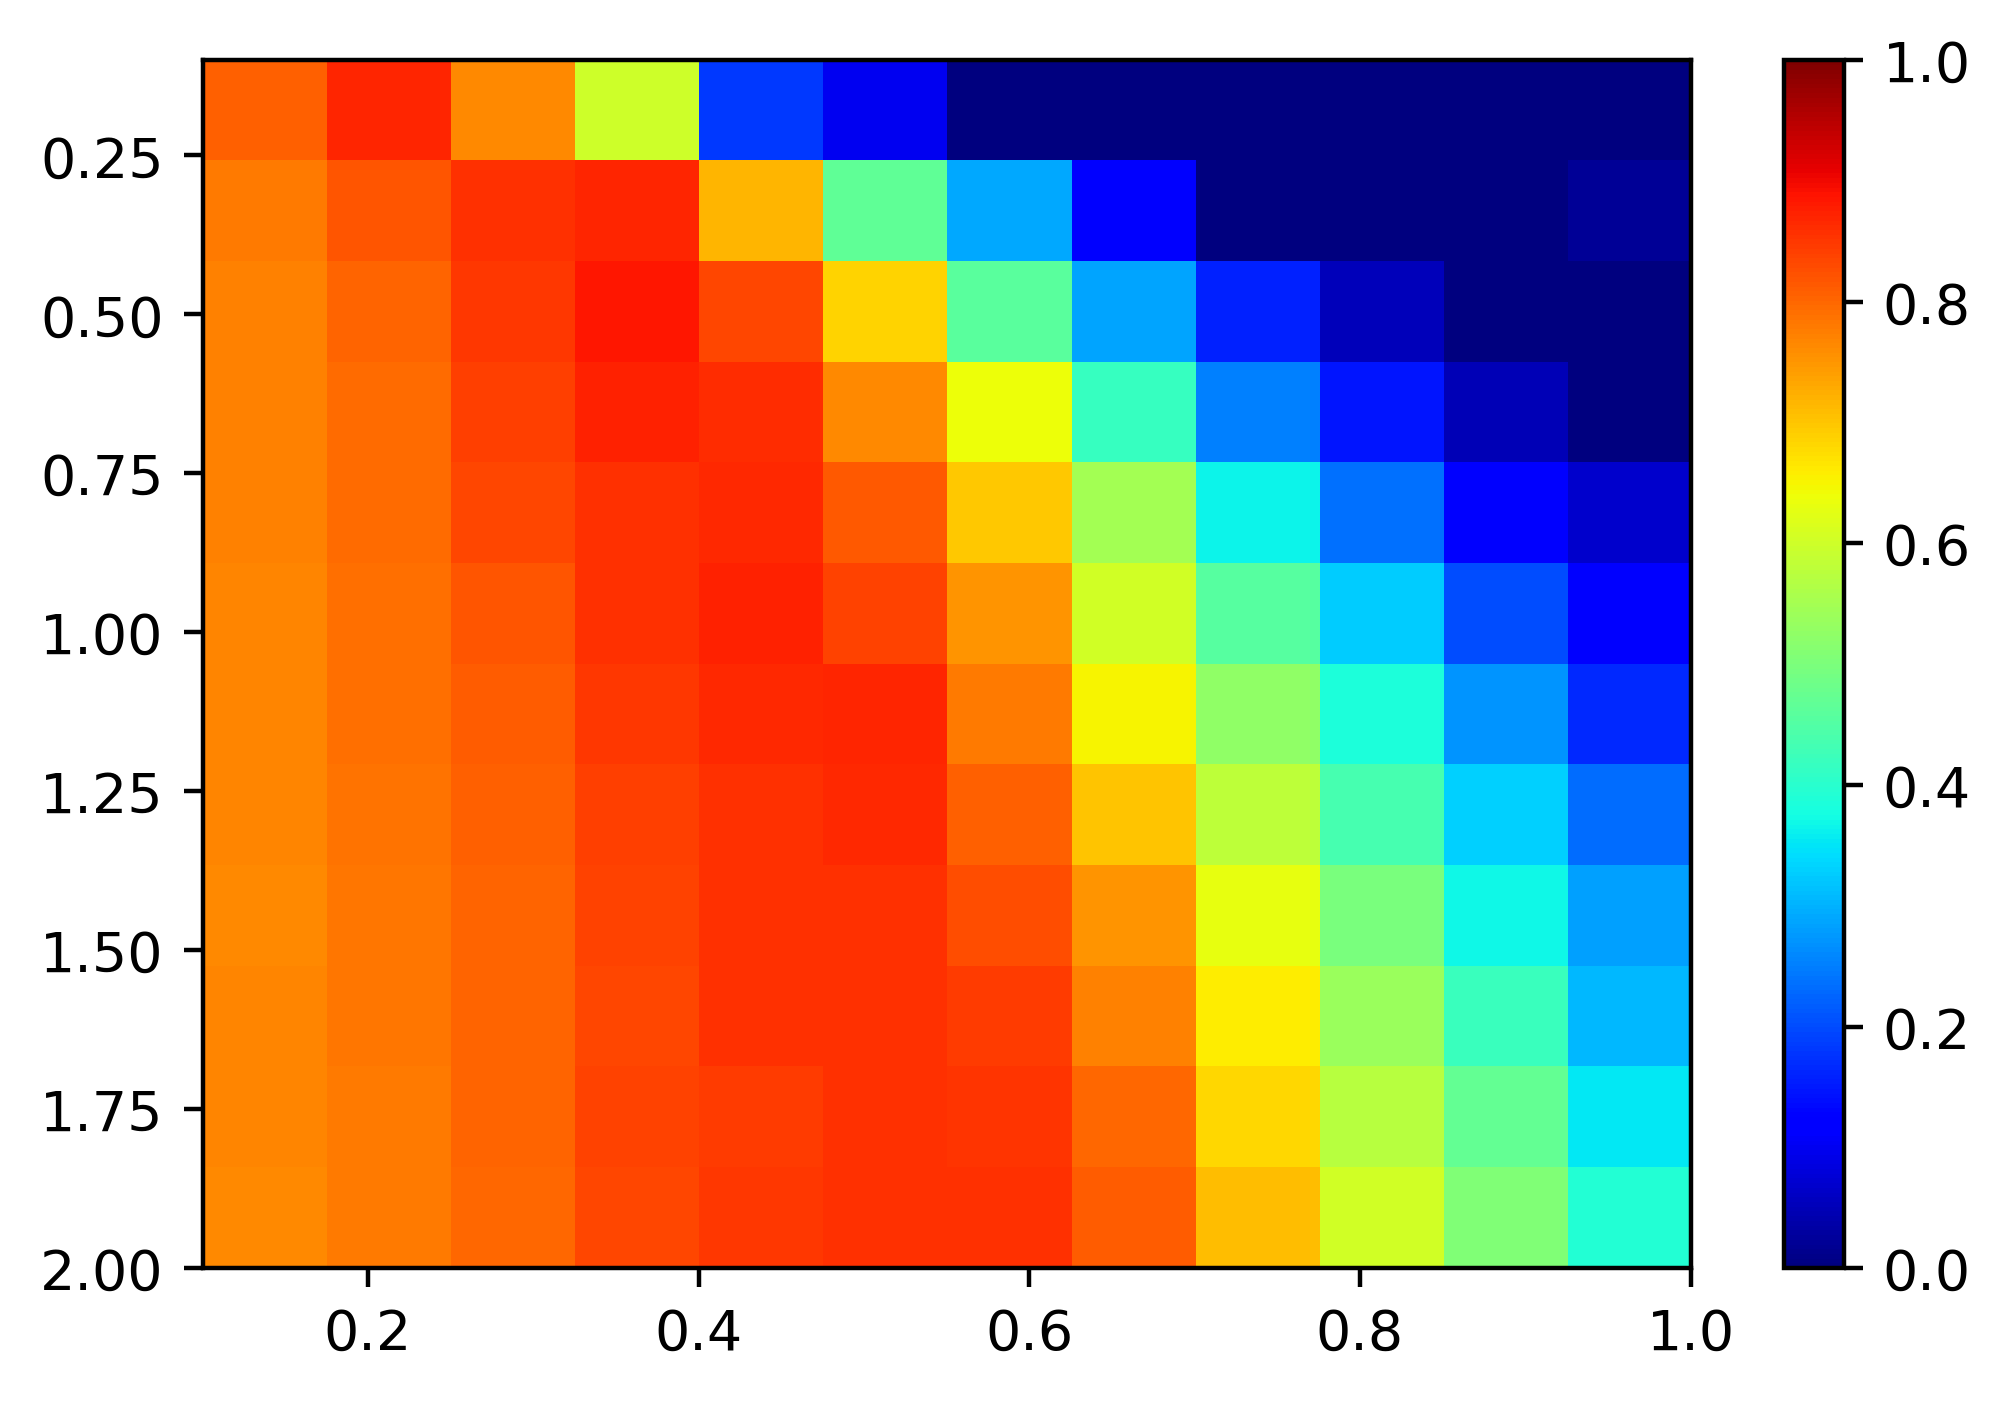

In [161]:
#print( corr[:,:,M-1] )
for i in np.arange(1,M,1):
    #ax = plt.axes()
    fig = plt.figure(dpi=400)
    plt.imshow( corr[:,:,i], cmap="jet", clim=[0,1],  extent =[I2_min, I2_max, I1_max, I1_min], aspect = 'auto' )
    plt.colorbar()
    plt.show()
    fig.savefig('corr/' + str(i) + '.png')
    